# *0. preparation of environment and datasets*

## 0.1 python environment

### 0.1.1 install python dependency

In [1]:
# !pip3 install torch
# !pip3 install numpy
# !pip3 install xgboost
# !pip3 install seaborn
# !pip3 install catboost
# !pip3 install torchvision

### 0.1.2 import the library

In [2]:
import os
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d
from scipy import stats
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import xgboost as xgb
from catboost import CatBoostRegressor

## 0.2 change to the work path

In [3]:
root_file_path = "/home/extension/kaggle/IEEE-CIS_Fraud_Detection"
# root_file_path = "/home/hdd/kaggle/ieee_cis"
# root_file_path = "../"

In [4]:
os.chdir(root_file_path)

## 0.3 read the files

In [5]:
def read_files(file_path):
    transaction_path, identity_path = file_path
    return pd.read_csv(transaction_path), pd.read_csv(identity_path)

## 0.4 string encoder

In [6]:
le = LabelEncoder()

## 0.5 merge sets

In [53]:
def merge_set(transcation_set, identity_set):
    tmp_df = pd.merge(transcation_set, identity_set, how="left", on=["TransactionID"])
    del transcation_set
    del identity_set
    return tmp_df, tmp_df.describe()

## 0.6 visualization

### 0.6.1 visualization

In [8]:
def visualization(df_train, description):
    start_index = description["TransactionID"]["min"]
    end_index = description["TransactionID"]["max"]

    for tmp_column in df_train.columns:
        print("Column Name is {}:".format(tmp_column))
        if df_train[tmp_column].dtype != np.object:
    #         df_train[tmp_column].plot(kind='line', label=tmp_column)
            tmp_plot = df_train.plot(kind="scatter", x="TransactionID", y=tmp_column)
#             tmp_plot.hlines(df_train_describe[tmp_column]["std"], start_index, end_index, linestyle='--', color='pink')
            tmp_plot.hlines(df_train_describe[tmp_column]["mean"], start_index, end_index, linestyle='--', color='black')
            tmp_plot.hlines(df_train_describe[tmp_column]["25%"], start_index, end_index, linestyle='--', color='red')
            tmp_plot.hlines(df_train_describe[tmp_column]["50%"], start_index, end_index, linestyle='--', color='green')
            tmp_plot.hlines(df_train_describe[tmp_column]["75%"], start_index, end_index, linestyle='--', color='yellow')
            tmp_plot.legend(loc='upper left')
        else:
            tmp_label = df_train[tmp_column].unique()
            tmp_ = pd.isnull(tmp_label)
            tmp_label = tmp_label[np.where(tmp_ == False)]        
            tmp_count_ = []

            for tmp in tmp_label:
                tmp_count_.append(df_train.loc[df_train[tmp_column] == tmp][tmp_column].count())

            print(tmp_label)
            print(tmp_count_)
            plt.bar(tmp_label,tmp_count_,width=0.3)
            plt.xticks(range(len(tmp_label)),tmp_label,rotation=90)

        plt.show()
        
#         tmp_count = df_train[tmp_column].count()
#         tmp_proportion = 1 - tmp_count / total_data_entry

#         print("Missing data proportion is {}".format(1 - tmp_count / total_data_entry))
#         print("-------------------------------------")

### 0.6.2 probability

In [9]:
def probability_plot(input_list, log_flag=False):
    fig = plt.figure()
  
    if log_flag:
        input_list = np.log10(input_list)
    else:
        pass

    res = stats.probplot(input_list, plot=plt)
    plt.show()

### 0.6.3 distribution

In [10]:
def distribution(input_array):
    sns.distplot(input_array, fit=norm)
    (mu, sigma) = norm.fit(input_array)
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

### 0.6.4 relational heatmap

#### 0.6.4.0 encode

In [11]:
def encode(df_train):
    for tmp_column in df_train.columns:
        if df_train[tmp_column].dtype != np.object:
            pass
        else:
            print(tmp_column)
            df_train[tmp_column] = le.fit_transform(df_train[tmp_column])

#### 0.6.4.1 relational heatmap

In [12]:
def relational_heatmap(df_train):
    encode(df_train)
    sns.heatmap(df_train.corr(), vmax=0.9, square=True)

### 0.6.5 normalization

In [13]:
def normalization(data_frame, feature_colnmns):
    np_list_train = data_frame[feature_columns].to_numpy()

    for index, tmp_row in enumerate(np_list_train):
        np_list_train[index] = tmp_row / np.linalg.norm(tmp_row, ord=2)
   
    return np_list_train

# **Training**

In [14]:
train_transcation_set, train_identity_set = read_files(["train_transaction.csv", "train_identity.csv"])

In [15]:
df_train, df_train_describe = merge_set(train_transcation_set, train_identity_set)

# *1. data preprocessing*

### 1.1 nan value

In [16]:
delete_nan_threshold = 0.4
delete_nan_threshold_row = 0.2

#### 1.2.1.1 processing the nan values in entry

In [17]:
def nan_value(column_nan_threshold, row_nan_threshold, df):
    num_entry, num_field = df.shape
    
    null_df = df.isnull()
    
    nan_proportion_column = np.sum(null_df == True) / num_entry
    useful_column = np.where(nan_proportion_column < column_nan_threshold)
    useful_column = df.columns[useful_column[0]]
    
    nan_proportion_row = np.sum(null_df[useful_column] == True, axis=1) / num_field
    row_index = np.where(nan_proportion_row < row_nan_threshold)
    
    return useful_column, row_index

In [18]:
column_index, entry_index = nan_value(delete_nan_threshold, delete_nan_threshold_row, df_train)

In [19]:
nan_train = df_train[column_index].loc[entry_index[0]]

In [20]:
del df_train

In [21]:
nan_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 522125 entries, 0 to 590539
Columns: 202 entries, TransactionID to V321
dtypes: float64(193), int64(4), object(5)
memory usage: 808.7+ MB


#### 1.2.1.2 fill nan value

In [22]:
nan_fill_dict = {"number": {}, "string": {}}

##### 1.2.1.2 fill nan value by mean and most occurance

In [23]:
for tmp_column in nan_train.columns:
    if nan_train[tmp_column].dtype != np.object:
        nan_fill_dict["number"][tmp_column] = df_train_describe[tmp_column]["mean"]
        nan_train[tmp_column].fillna(value=df_train_describe[tmp_column]["mean"], inplace=True)
    else:
        tmp_label = nan_train[tmp_column].unique()
        tmp_ = pd.isnull(tmp_label)
        tmp_label = tmp_label[np.where(tmp_ == False)]        
        tmp_count_ = []

        for tmp in tmp_label:
            tmp_count_.append(nan_train.loc[nan_train[tmp_column] == tmp][tmp_column].count())
            
        index = np.argmax(tmp_count_)
        nan_train[tmp_column].fillna(value=tmp_label[index], inplace=True)
        nan_fill_dict["string"][tmp_column] = tmp_label[index]

Column Name is TransactionID:


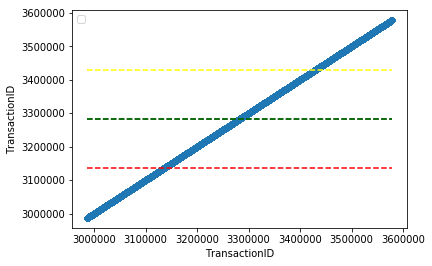

Column Name is isFraud:


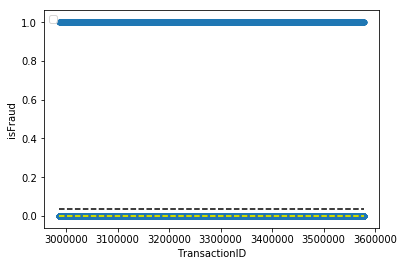

Column Name is TransactionDT:


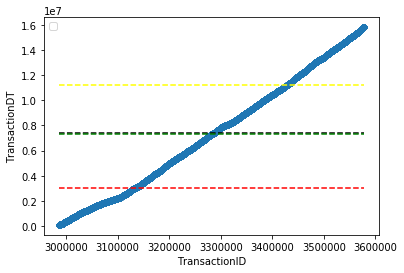

Column Name is TransactionAmt:


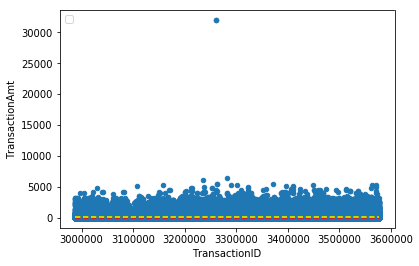

Column Name is ProductCD:
['W' 'C' 'S' 'H' 'R']
[439634, 68484, 5173, 3000, 5834]


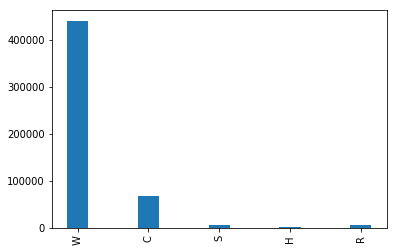

Column Name is card1:


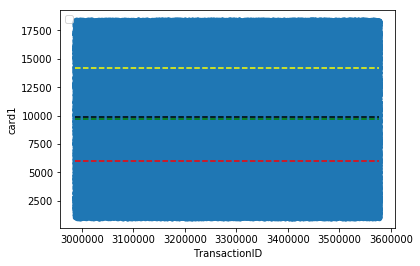

Column Name is card2:


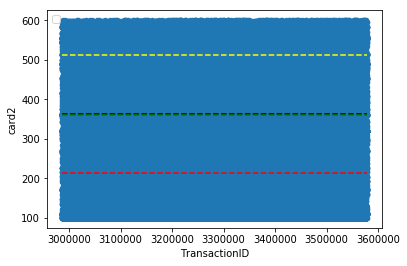

Column Name is card3:


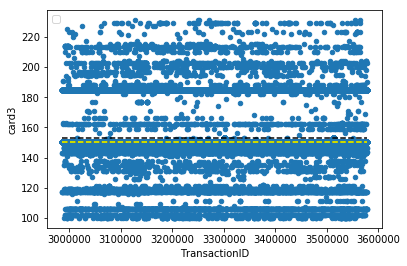

Column Name is card4:
['discover' 'mastercard' 'visa' 'american express']
[4836, 174174, 341509, 1606]


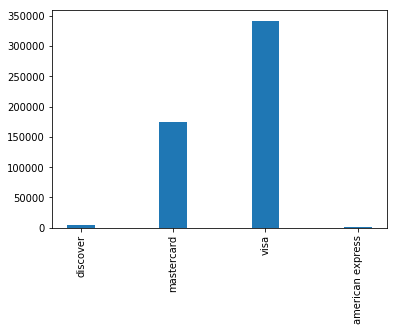

Column Name is card5:


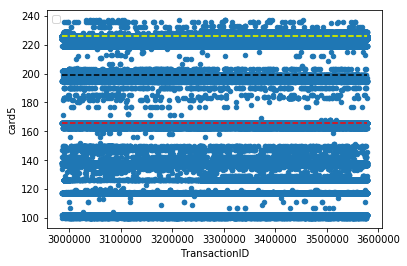

Column Name is card6:
['credit' 'debit' 'debit or credit' 'charge card']
[107550, 414533, 30, 12]


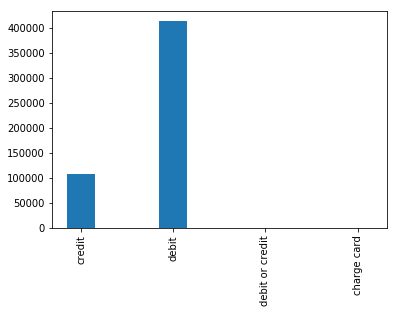

Column Name is addr1:


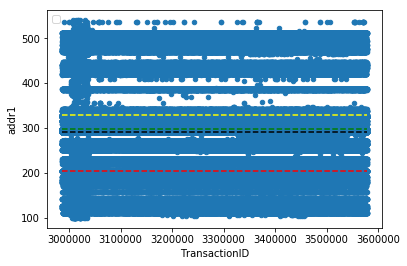

Column Name is addr2:


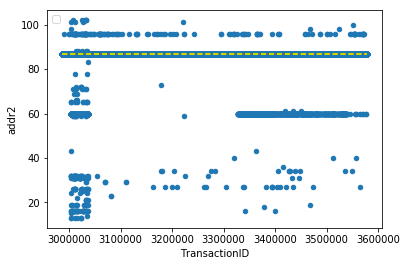

Column Name is P_emaildomain:
['gmail.com' 'outlook.com' 'yahoo.com' 'mail.com' 'hotmail.com'
 'verizon.net' 'aol.com' 'me.com' 'anonymous.com' 'comcast.net'
 'optonline.net' 'cox.net' 'rocketmail.com' 'prodigy.net.mx' 'icloud.com'
 'live.com.mx' 'gmail' 'live.com' 'att.net' 'ymail.com' 'sbcglobal.net'
 'juno.com' 'charter.net' 'bellsouth.net' 'msn.com' 'q.com' 'yahoo.com.mx'
 'centurylink.net' 'servicios-ta.com' 'earthlink.net' 'hotmail.es'
 'cfl.rr.com' 'roadrunner.com' 'netzero.net' 'gmx.de' 'suddenlink.net'
 'frontiernet.net' 'windstream.net' 'outlook.es' 'netzero.com'
 'frontier.com' 'aim.com' 'mac.com' 'web.de' 'embarqmail.com'
 'cableone.net' 'yahoo.fr' 'yahoo.de' 'twc.com' 'yahoo.es' 'sc.rr.com'
 'ptd.net' 'live.fr' 'yahoo.co.uk' 'hotmail.fr' 'hotmail.de'
 'hotmail.co.uk' 'protonmail.com' 'yahoo.co.jp']
[290744, 4732, 91512, 492, 41387, 2030, 24651, 1038, 26445, 5988, 773, 961, 604, 207, 5709, 747, 480, 2714, 3542, 2161, 2343, 270, 610, 1480, 3291, 161, 1542, 190, 35, 411, 305,

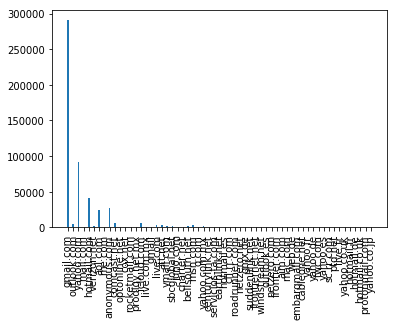

Column Name is C1:


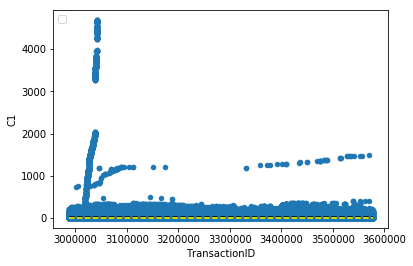

Column Name is C2:


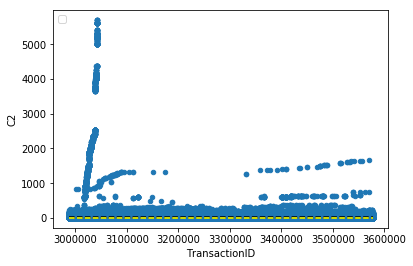

Column Name is C3:


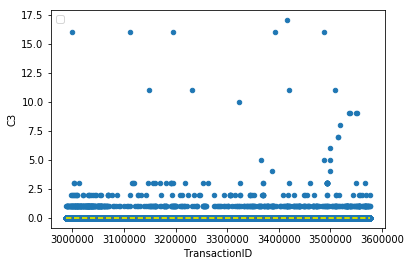

Column Name is C4:


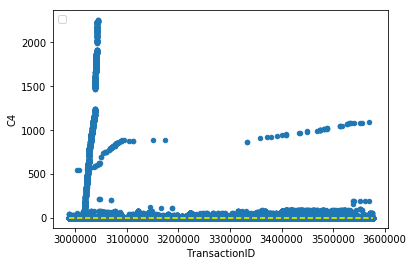

Column Name is C5:


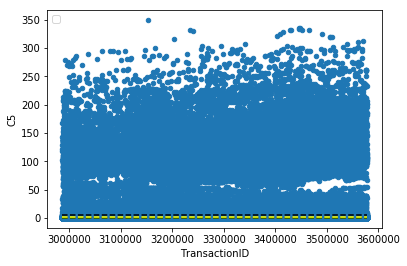

Column Name is C6:


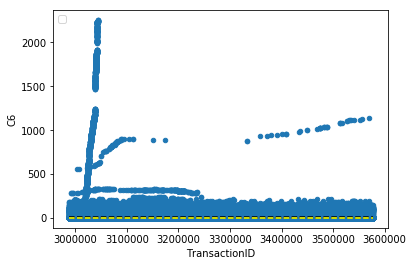

Column Name is C7:


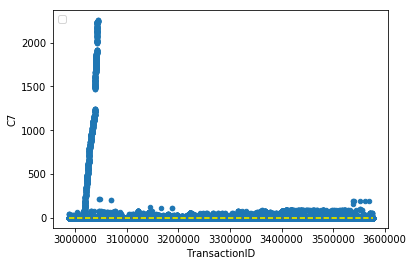

Column Name is C8:


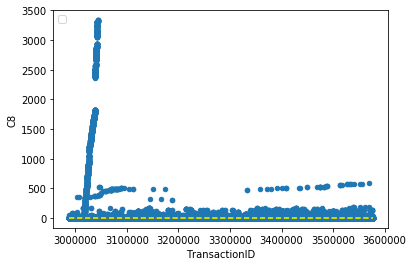

Column Name is C9:


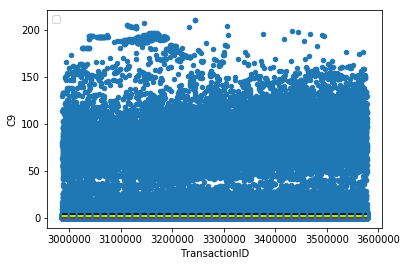

Column Name is C10:


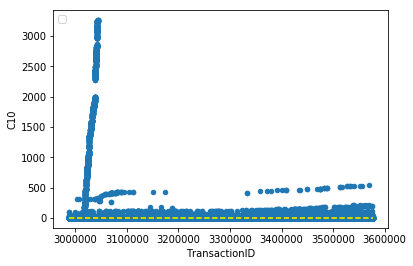

Column Name is C11:


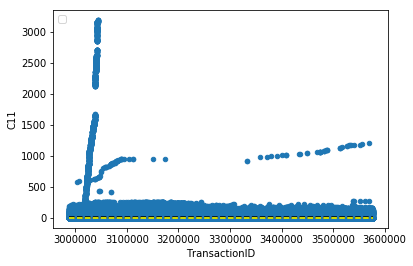

Column Name is C12:


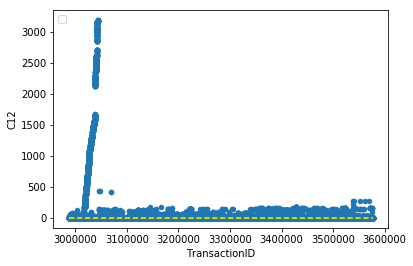

Column Name is C13:


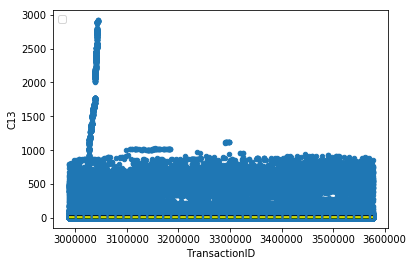

Column Name is C14:


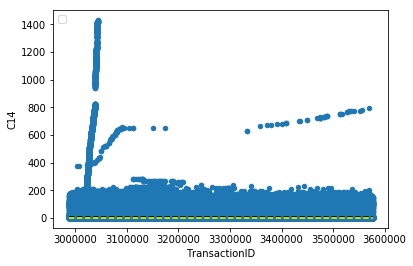

Column Name is D1:


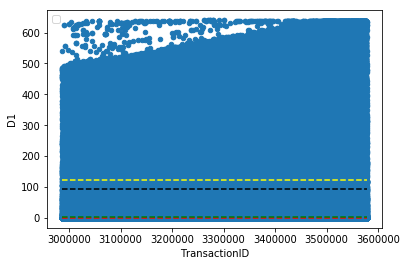

Column Name is D4:


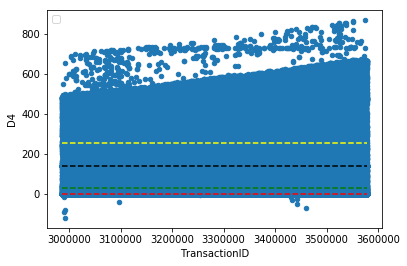

Column Name is D10:


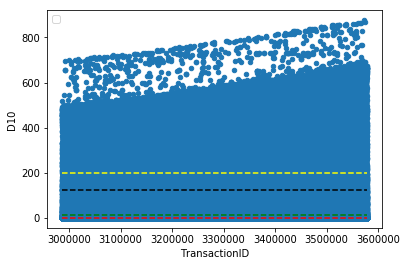

Column Name is D15:


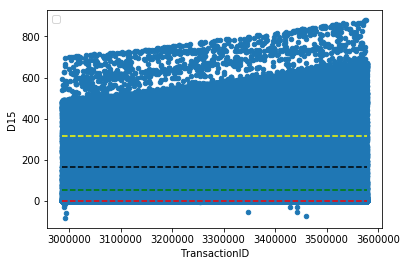

Column Name is M6:
['T' 'F']
[193313, 328812]


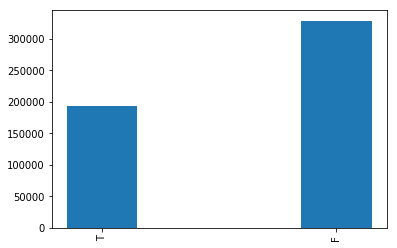

Column Name is V12:


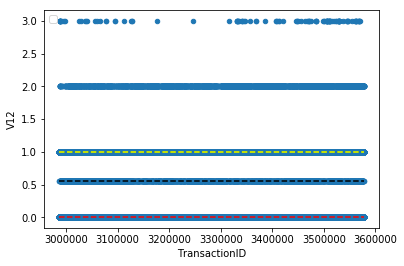

Column Name is V13:


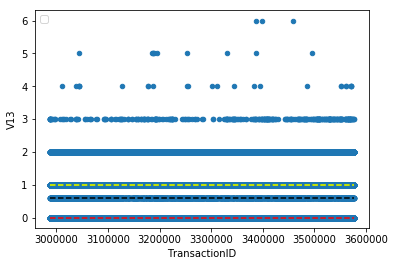

Column Name is V14:


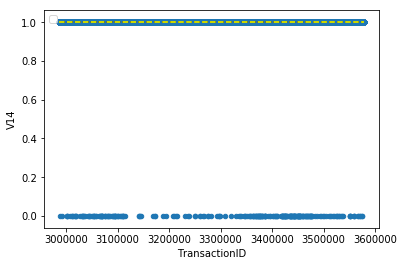

Column Name is V15:


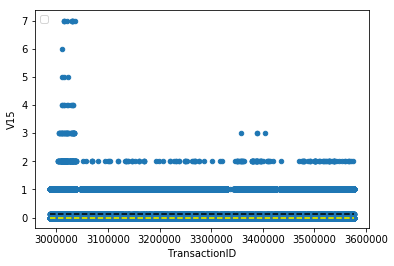

Column Name is V16:


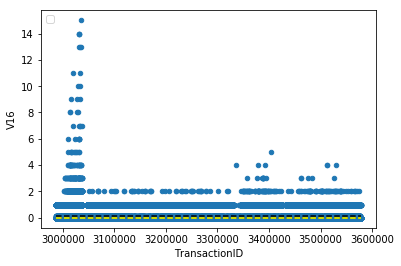

Column Name is V17:


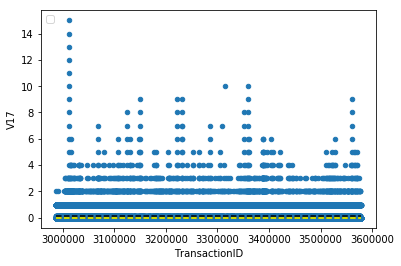

Column Name is V18:


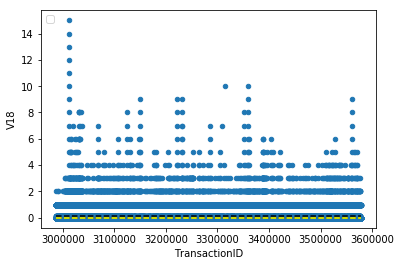

Column Name is V19:


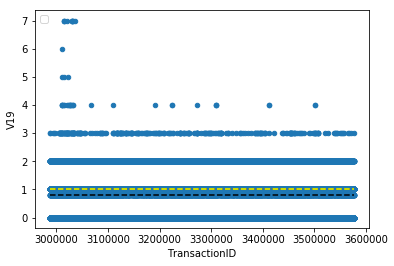

Column Name is V20:


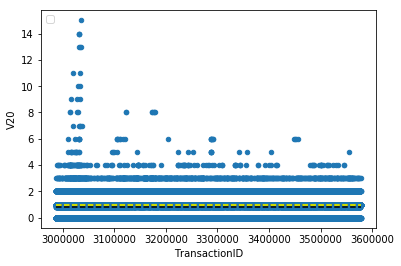

Column Name is V21:


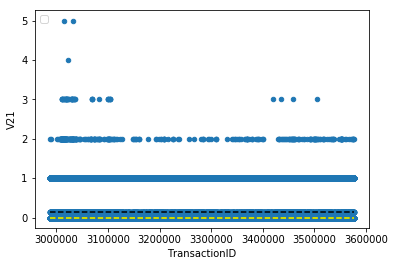

Column Name is V22:


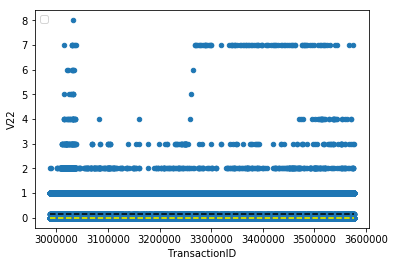

Column Name is V23:


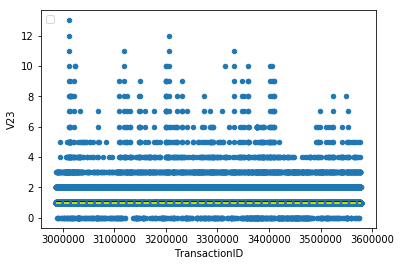

Column Name is V24:


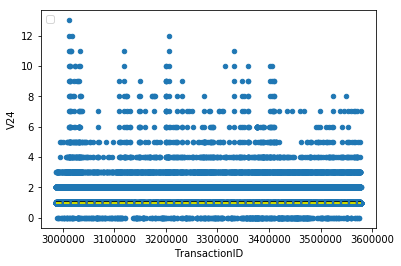

Column Name is V25:


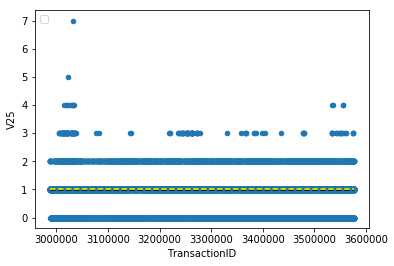

Column Name is V26:


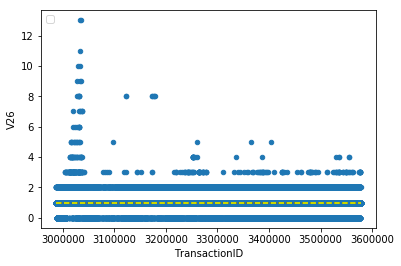

Column Name is V27:


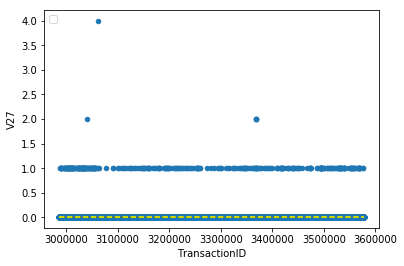

Column Name is V28:


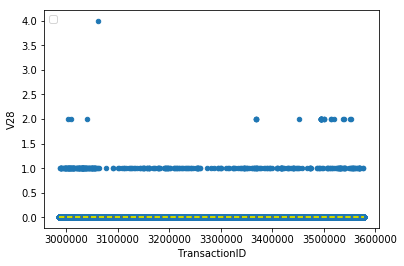

Column Name is V29:


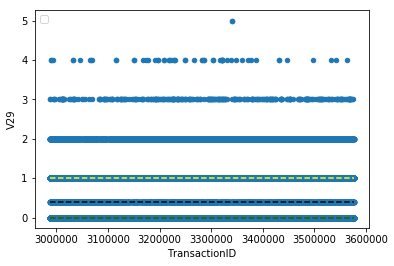

Column Name is V30:


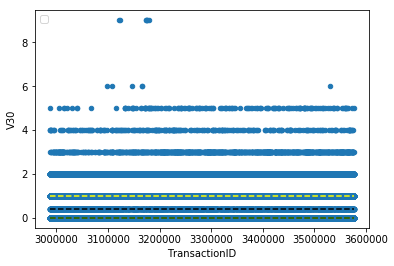

Column Name is V31:


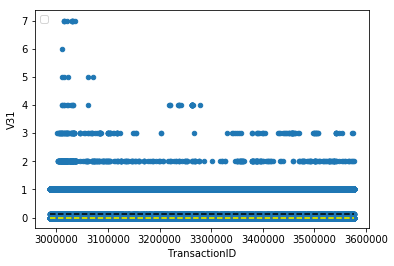

Column Name is V32:


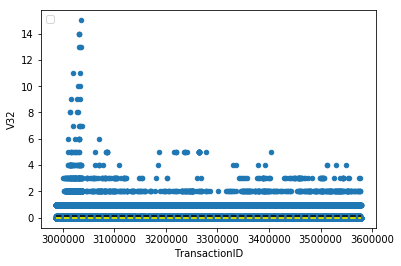

Column Name is V33:


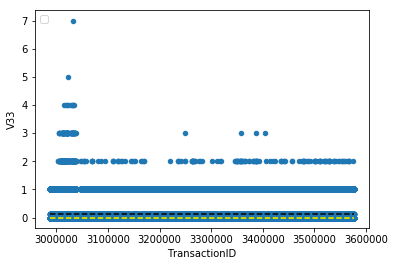

Column Name is V34:


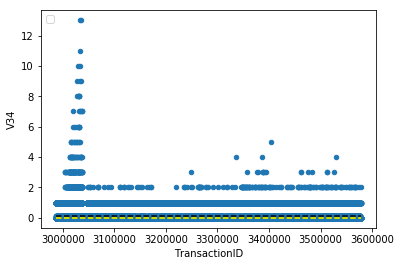

Column Name is V35:


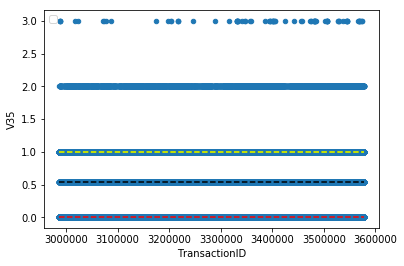

Column Name is V36:


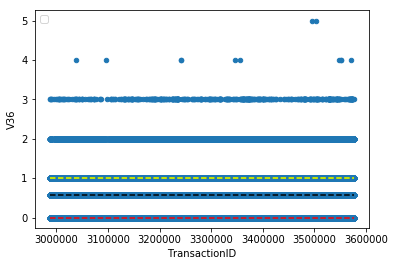

Column Name is V37:


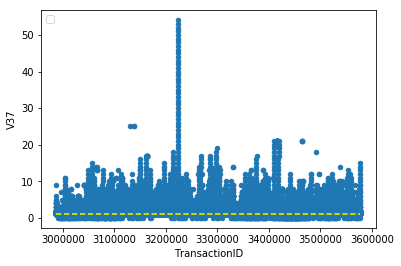

Column Name is V38:


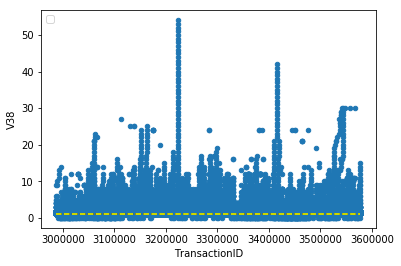

Column Name is V39:


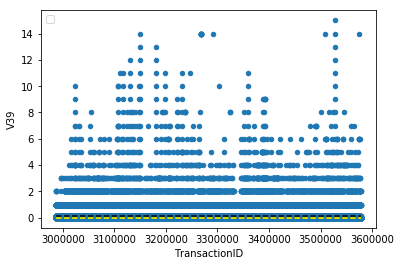

Column Name is V40:


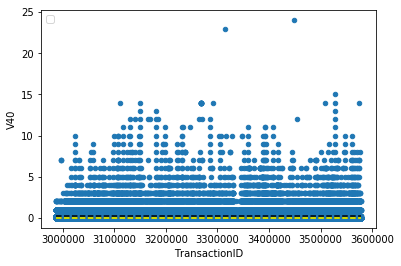

Column Name is V41:


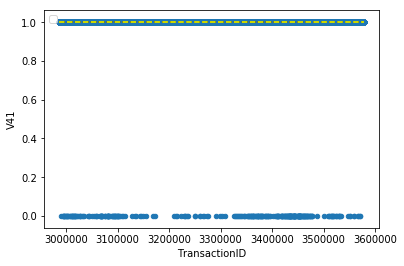

Column Name is V42:


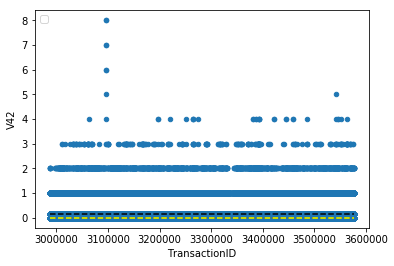

Column Name is V43:


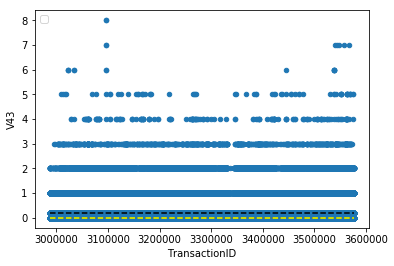

Column Name is V44:


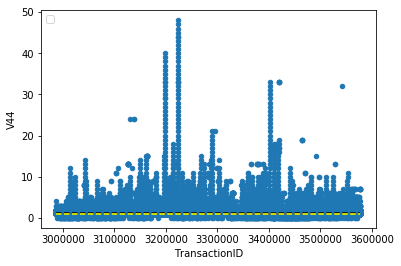

Column Name is V45:


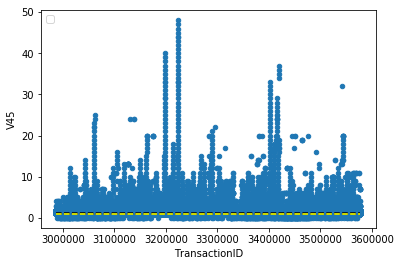

Column Name is V46:


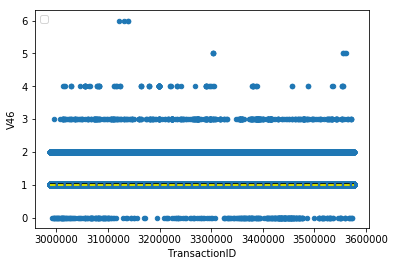

Column Name is V47:


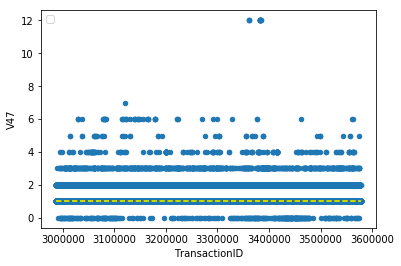

Column Name is V48:


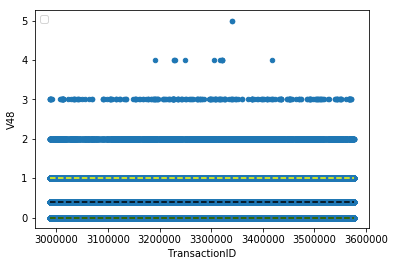

Column Name is V49:


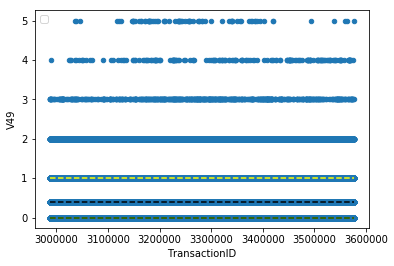

Column Name is V50:


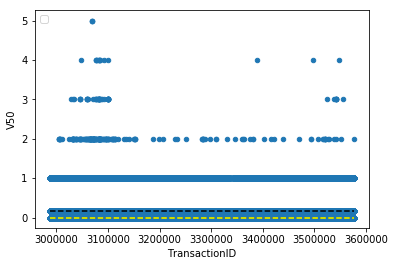

Column Name is V51:


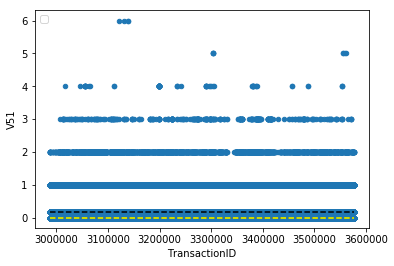

Column Name is V52:


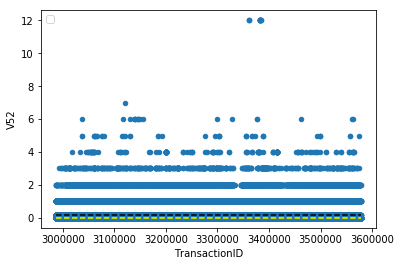

Column Name is V53:


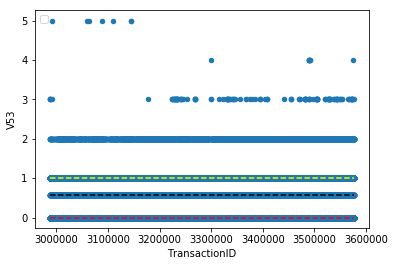

Column Name is V54:


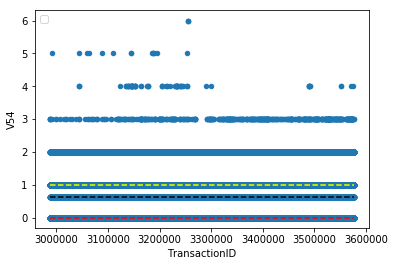

Column Name is V55:


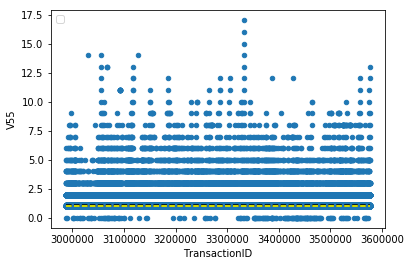

Column Name is V56:


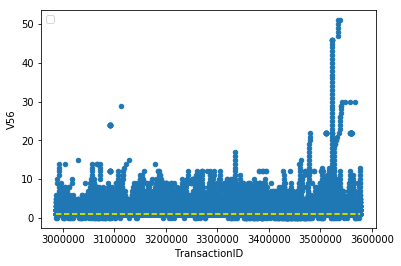

Column Name is V57:


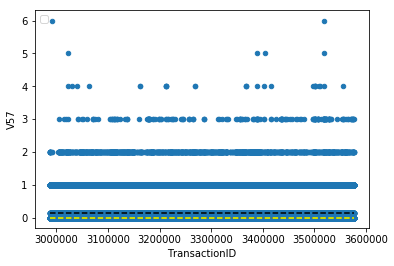

Column Name is V58:


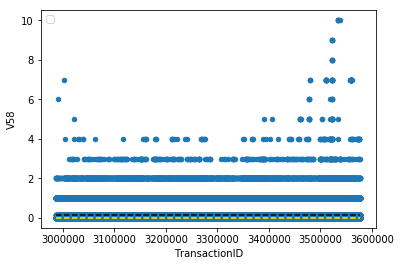

Column Name is V59:


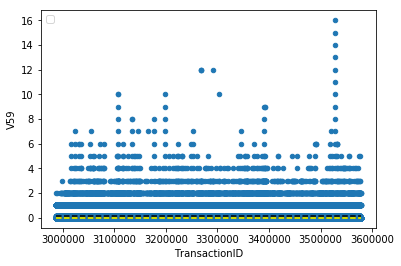

Column Name is V60:


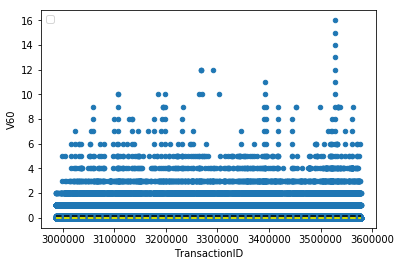

Column Name is V61:


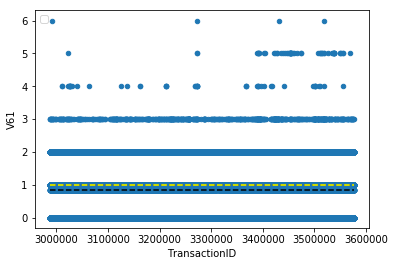

Column Name is V62:


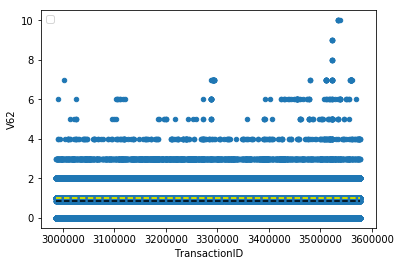

Column Name is V63:


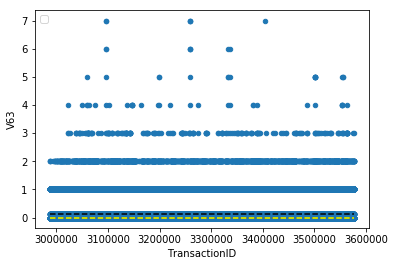

Column Name is V64:


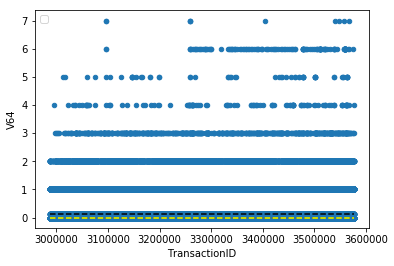

Column Name is V65:


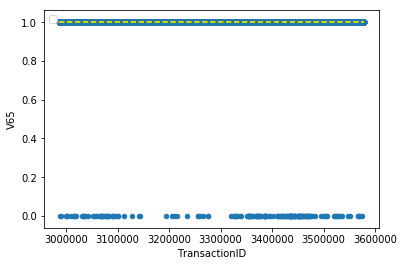

Column Name is V66:


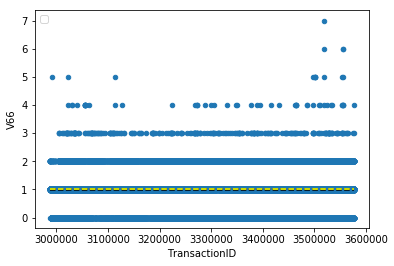

Column Name is V67:


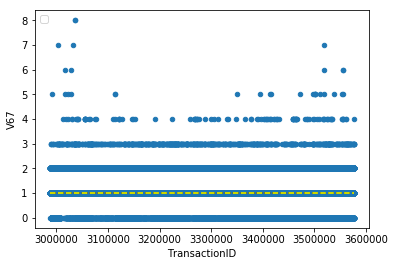

Column Name is V68:


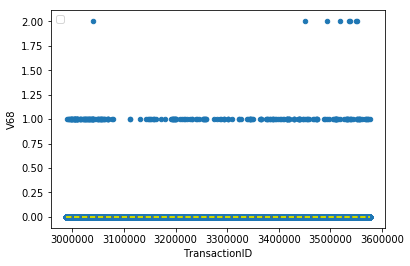

Column Name is V69:


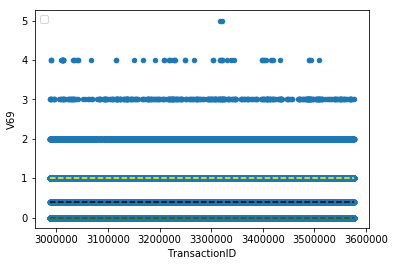

Column Name is V70:


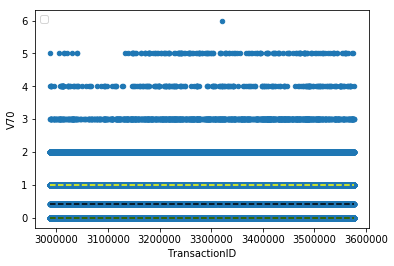

Column Name is V71:


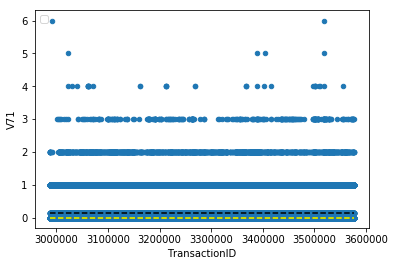

Column Name is V72:


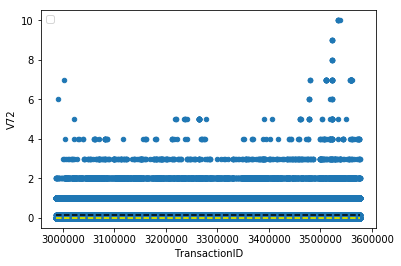

Column Name is V73:


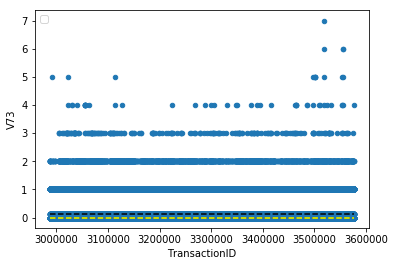

Column Name is V74:


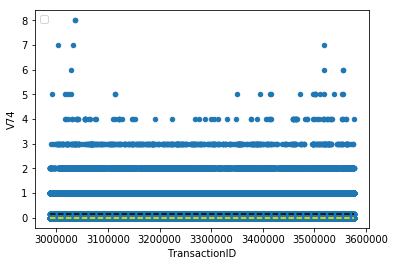

Column Name is V75:


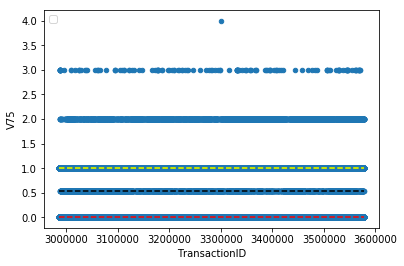

Column Name is V76:


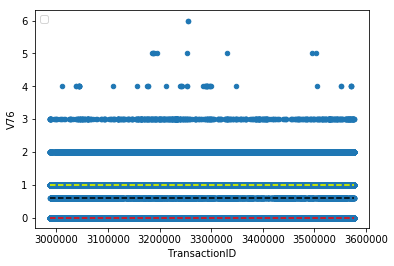

Column Name is V77:


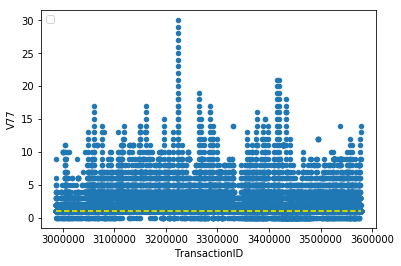

Column Name is V78:


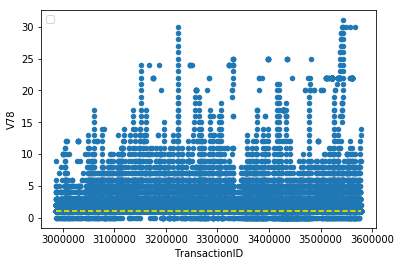

Column Name is V79:


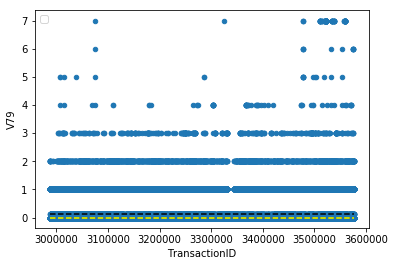

Column Name is V80:


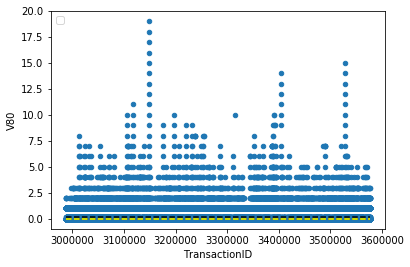

Column Name is V81:


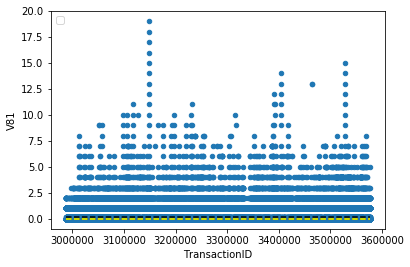

Column Name is V82:


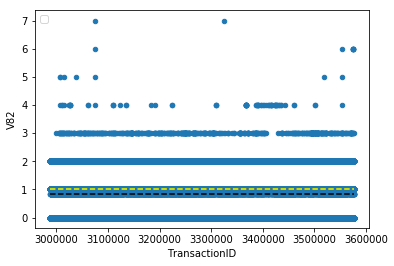

Column Name is V83:


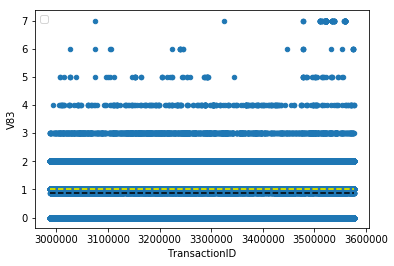

Column Name is V84:


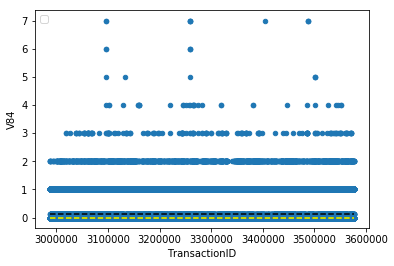

Column Name is V85:


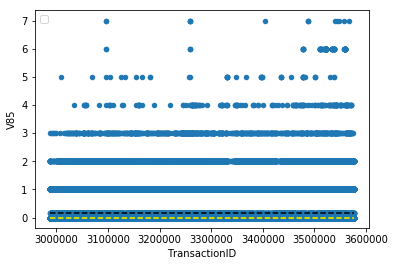

Column Name is V86:


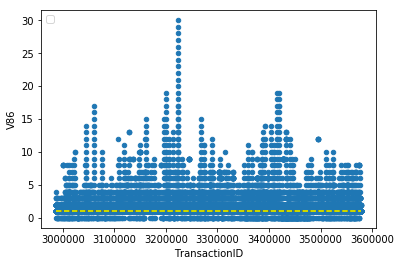

Column Name is V87:


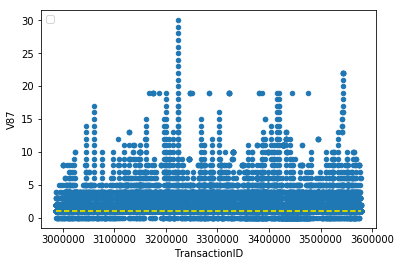

Column Name is V88:


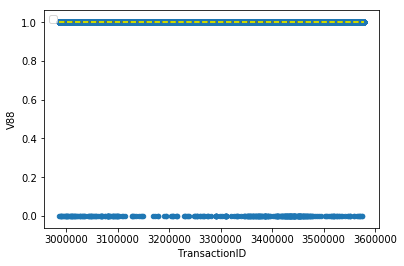

Column Name is V89:


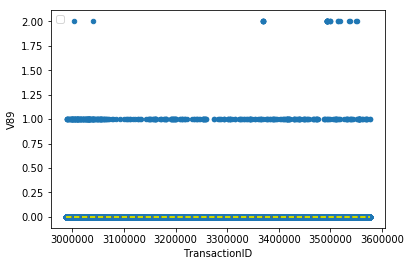

Column Name is V90:


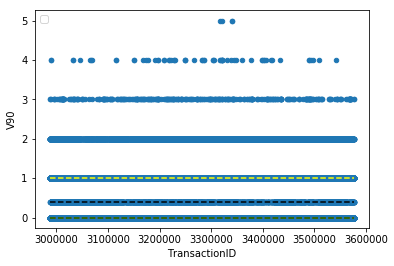

Column Name is V91:


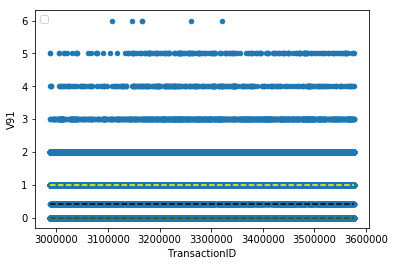

Column Name is V92:


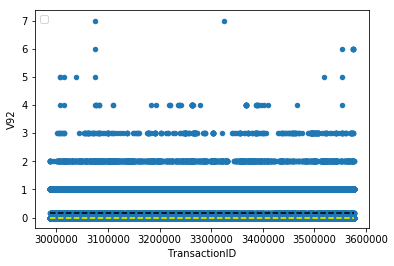

Column Name is V93:


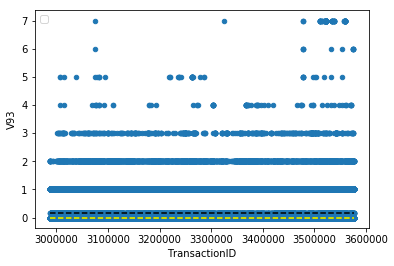

Column Name is V94:


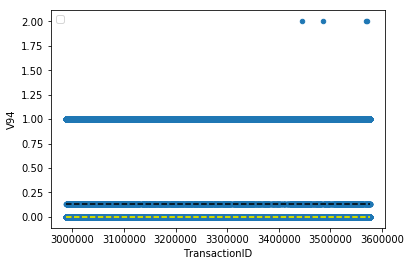

Column Name is V95:


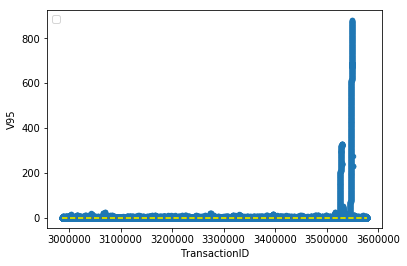

Column Name is V96:


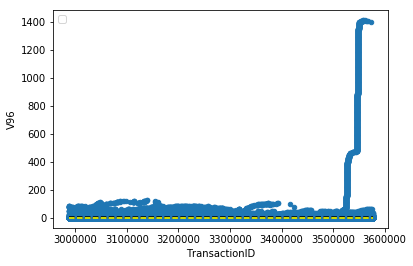

Column Name is V97:


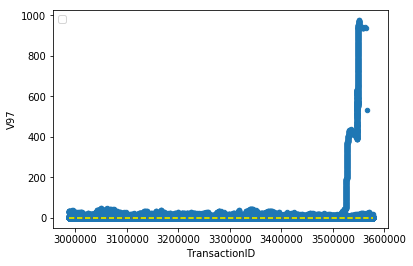

Column Name is V98:


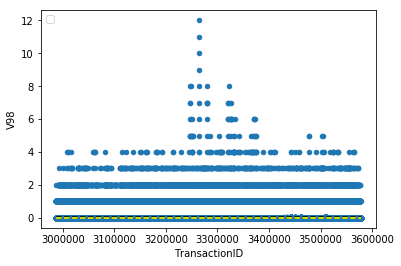

Column Name is V99:


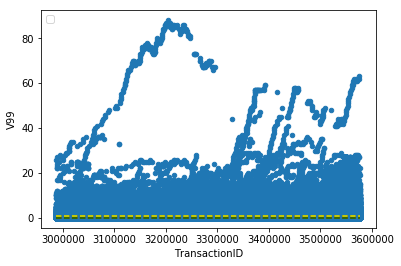

Column Name is V100:


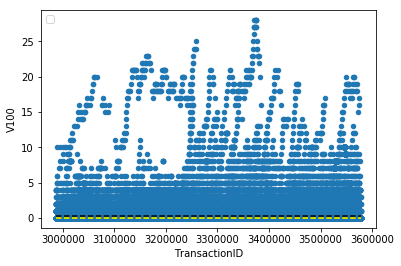

Column Name is V101:


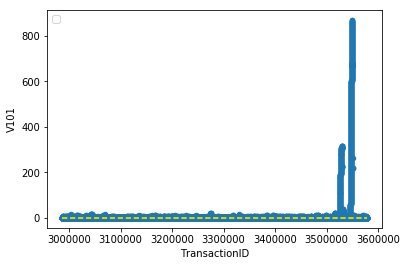

Column Name is V102:


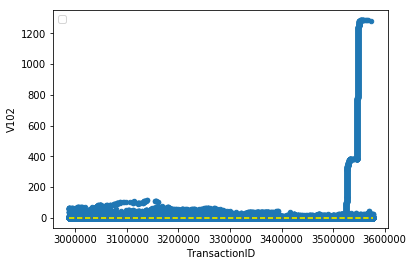

Column Name is V103:


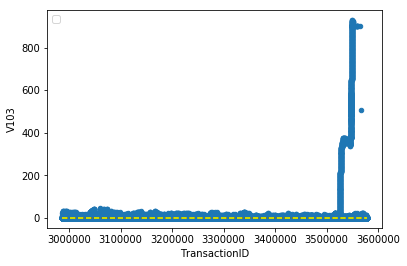

Column Name is V104:


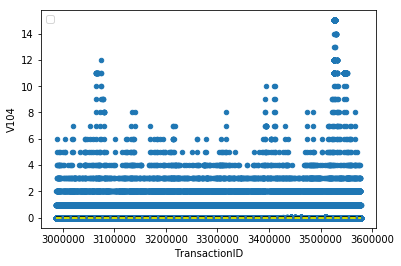

Column Name is V105:


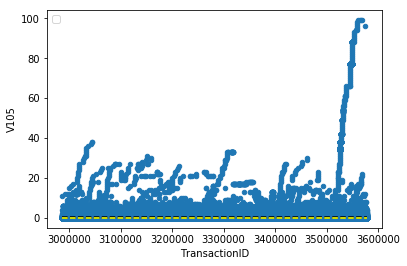

Column Name is V106:


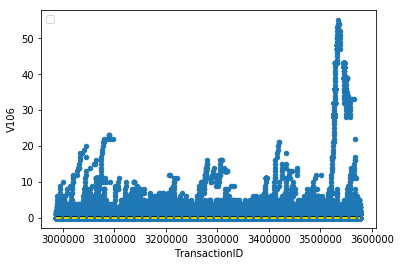

Column Name is V107:


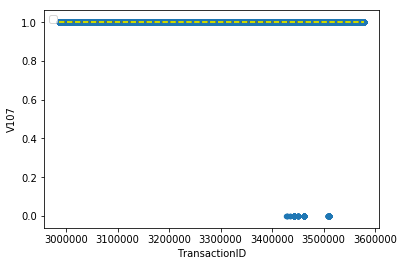

Column Name is V108:


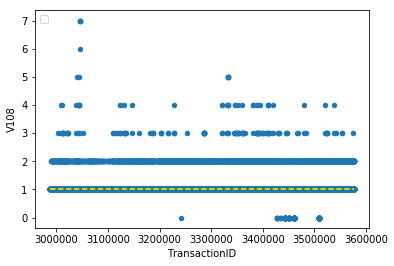

Column Name is V109:


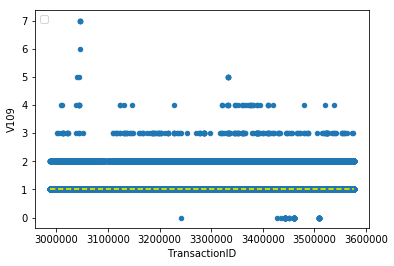

Column Name is V110:


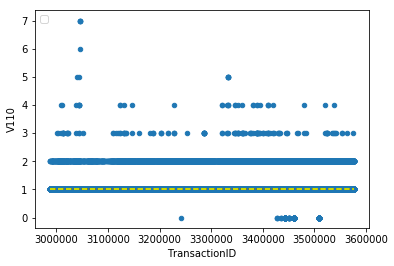

Column Name is V111:


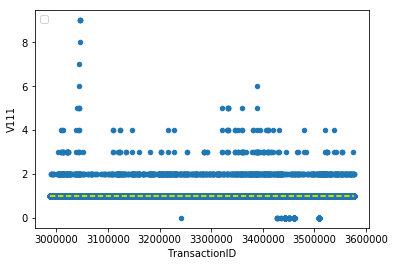

Column Name is V112:


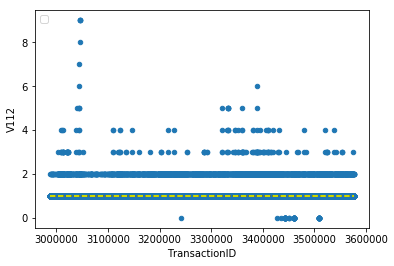

Column Name is V113:


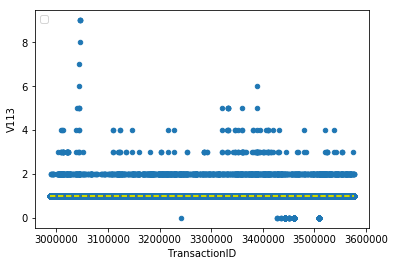

Column Name is V114:


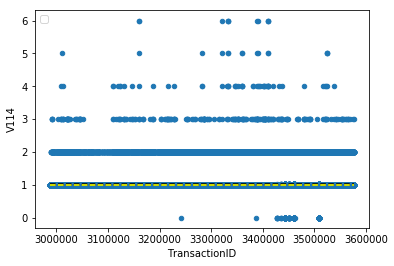

Column Name is V115:


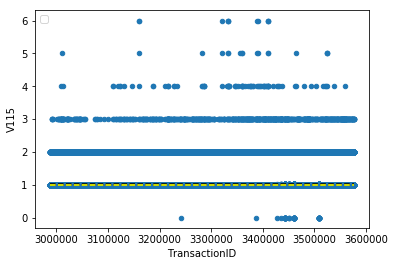

Column Name is V116:


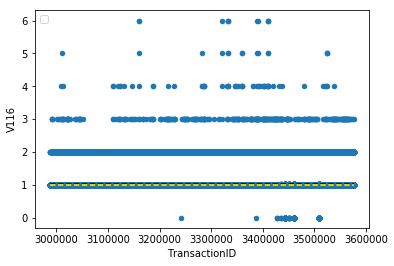

Column Name is V117:


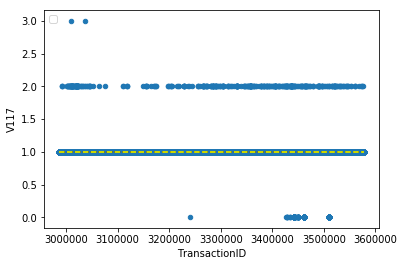

Column Name is V118:


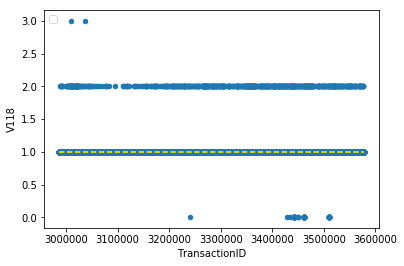

Column Name is V119:


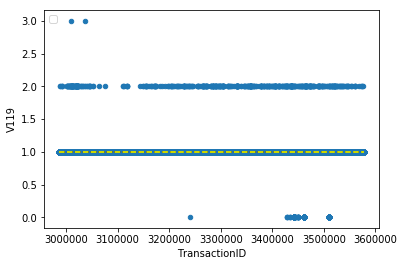

Column Name is V120:


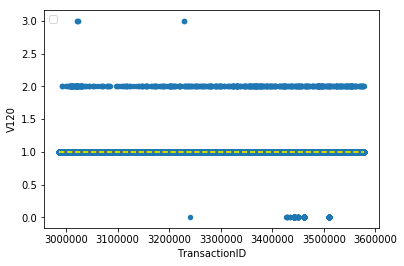

Column Name is V121:


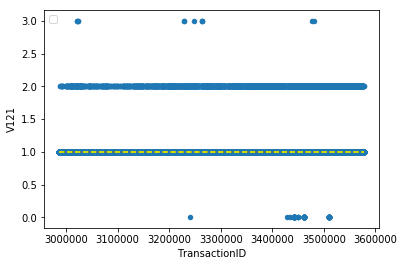

Column Name is V122:


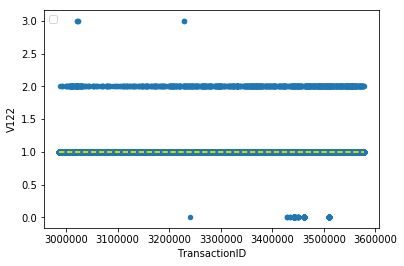

Column Name is V123:


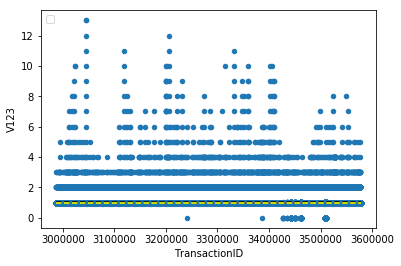

Column Name is V124:


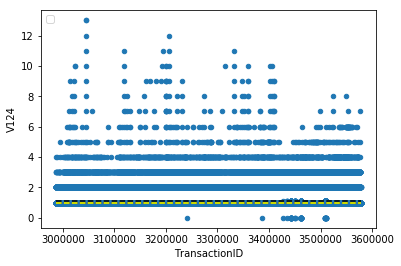

Column Name is V125:


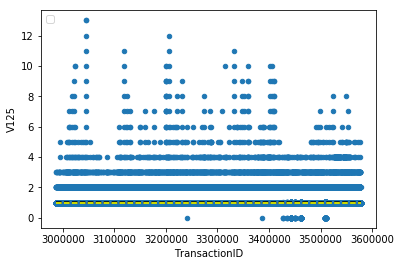

Column Name is V126:


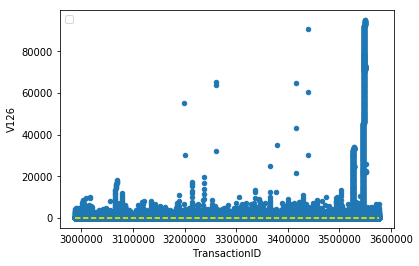

Column Name is V127:


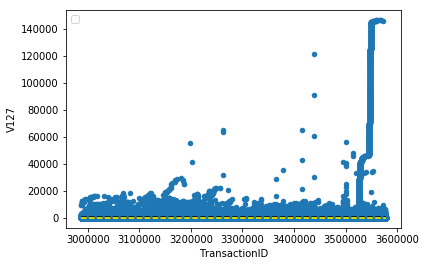

Column Name is V128:


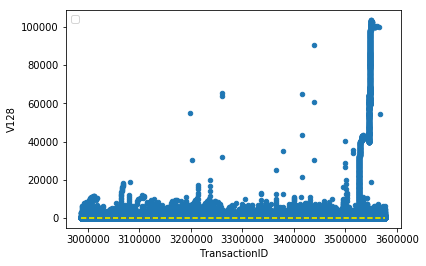

Column Name is V129:


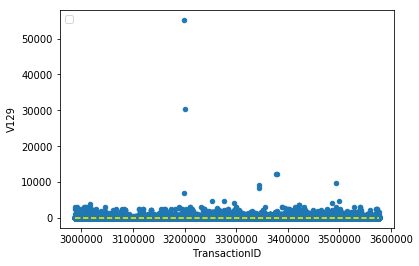

Column Name is V130:


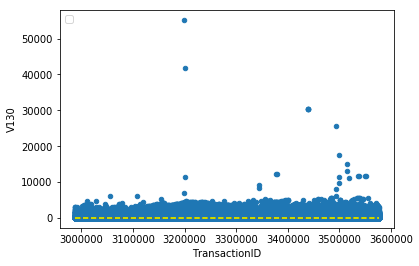

Column Name is V131:


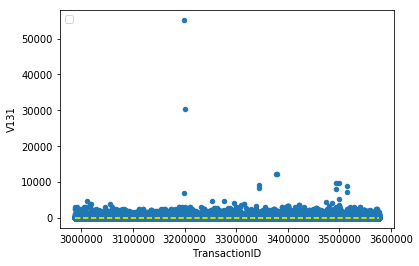

Column Name is V132:


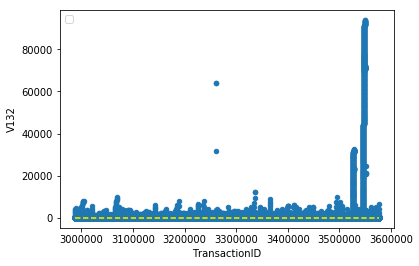

Column Name is V133:


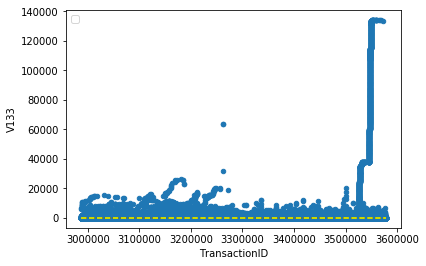

Column Name is V134:


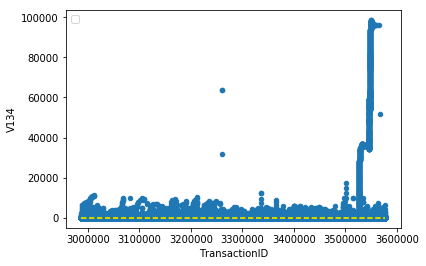

Column Name is V135:


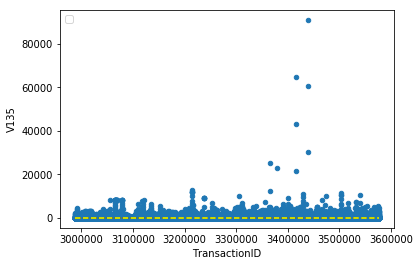

Column Name is V136:


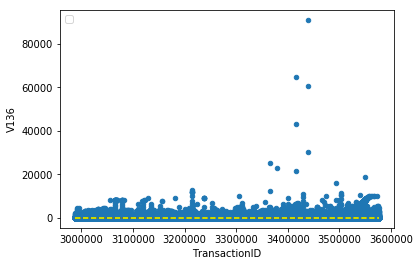

Column Name is V137:


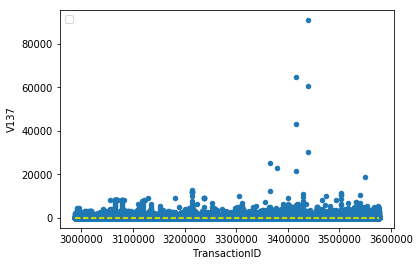

Column Name is V279:


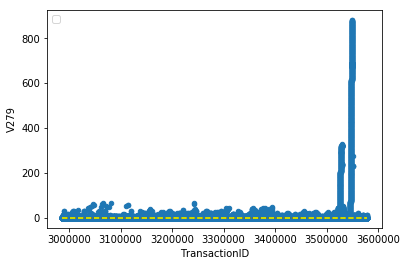

Column Name is V280:


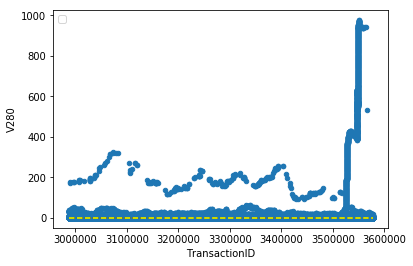

Column Name is V281:


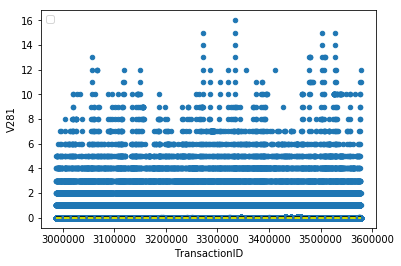

Column Name is V282:


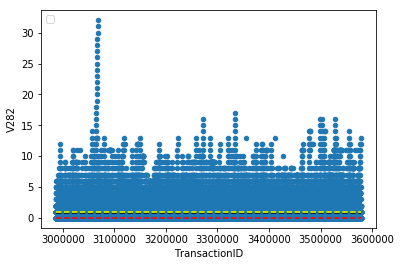

Column Name is V283:


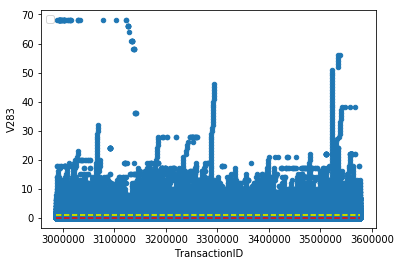

Column Name is V284:


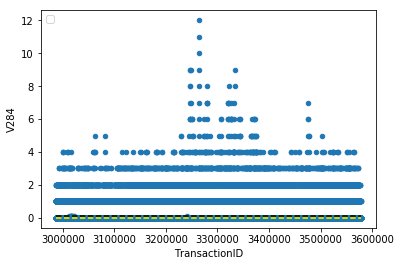

Column Name is V285:


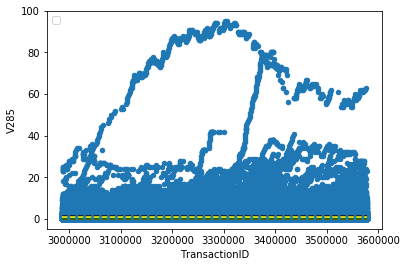

Column Name is V286:


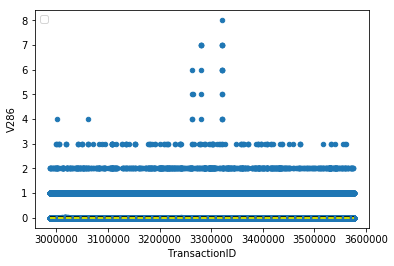

Column Name is V287:


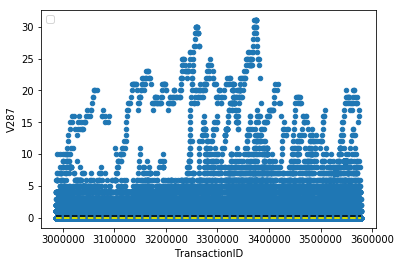

Column Name is V288:


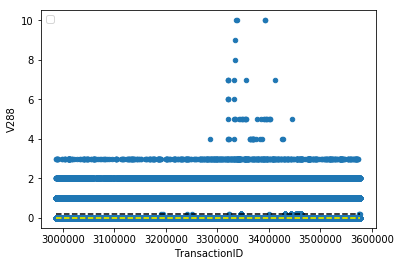

Column Name is V289:


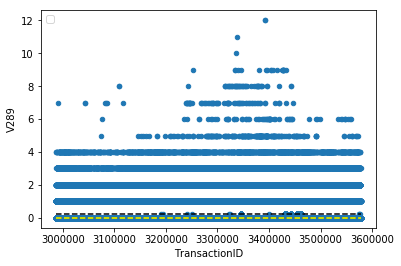

Column Name is V290:


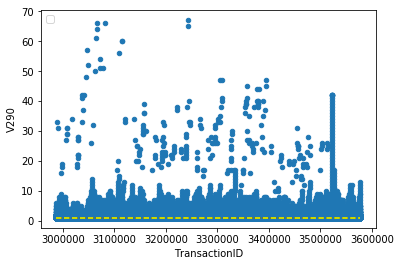

Column Name is V291:


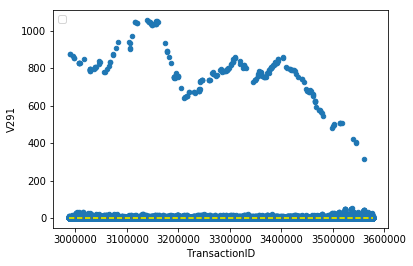

Column Name is V292:


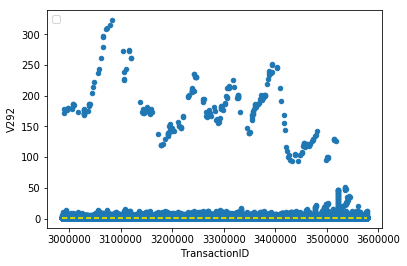

Column Name is V293:


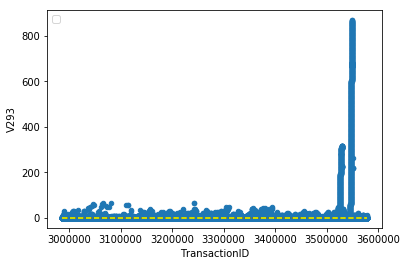

Column Name is V294:


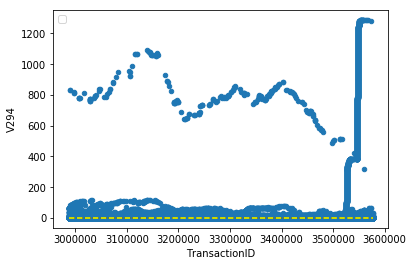

Column Name is V295:


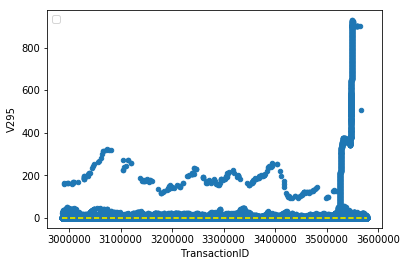

Column Name is V296:


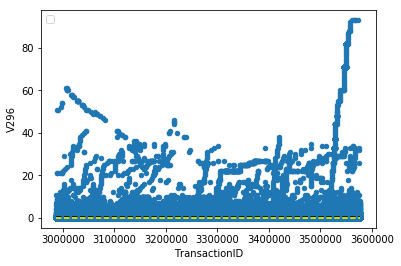

Column Name is V297:


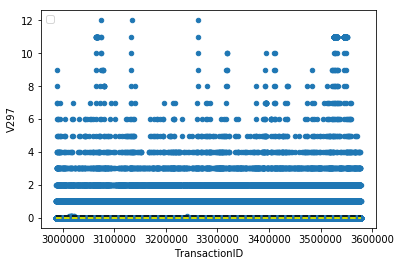

Column Name is V298:


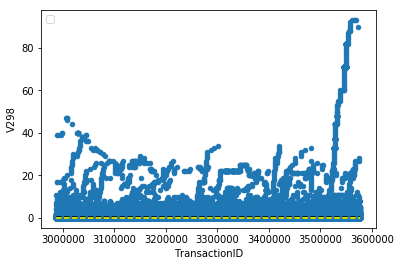

Column Name is V299:


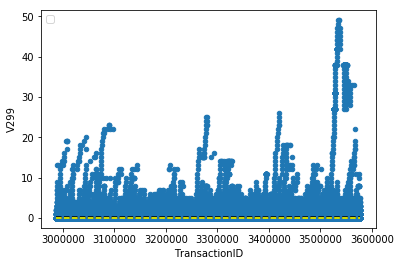

Column Name is V300:


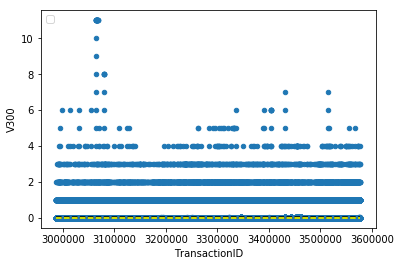

Column Name is V301:


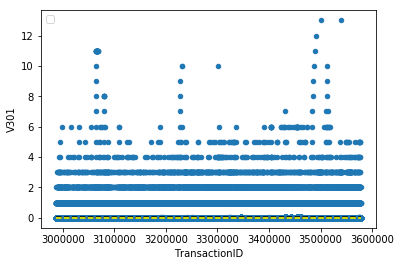

Column Name is V302:


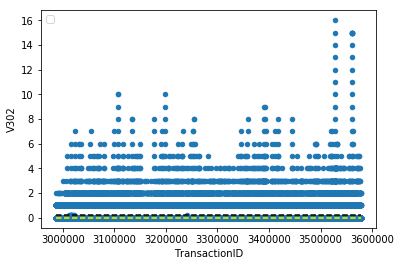

Column Name is V303:


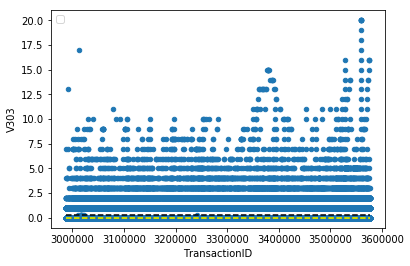

Column Name is V304:


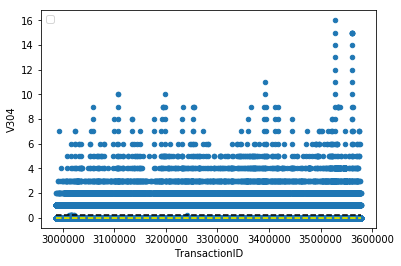

Column Name is V305:


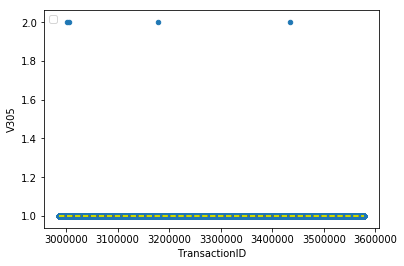

Column Name is V306:


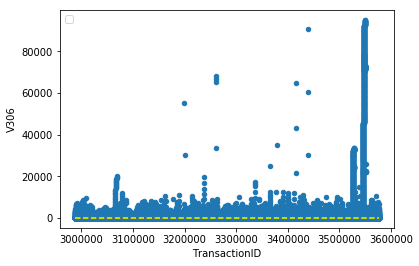

Column Name is V307:


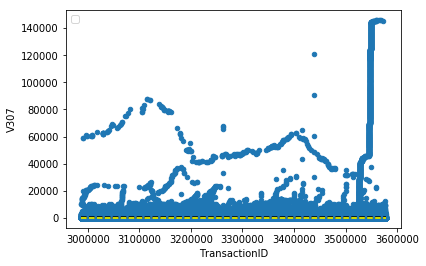

Column Name is V308:


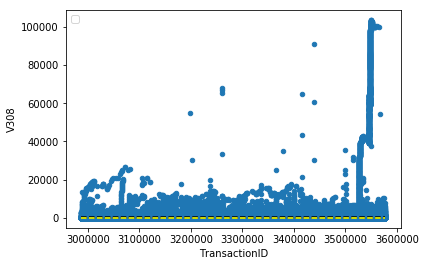

Column Name is V309:


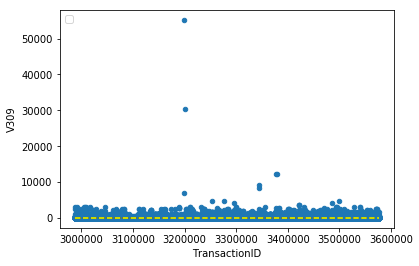

Column Name is V310:


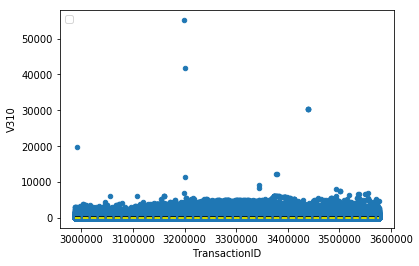

Column Name is V311:


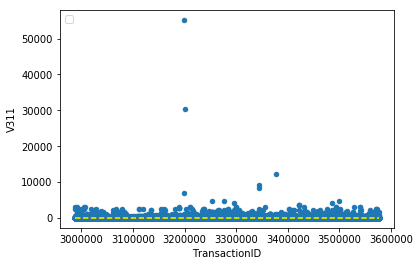

Column Name is V312:


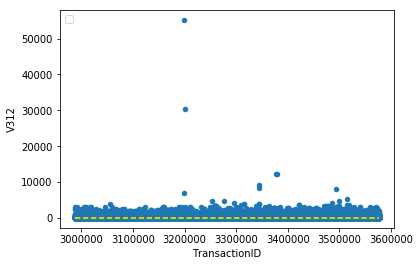

Column Name is V313:


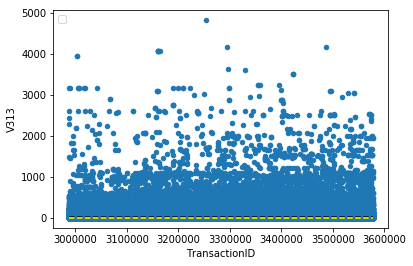

Column Name is V314:


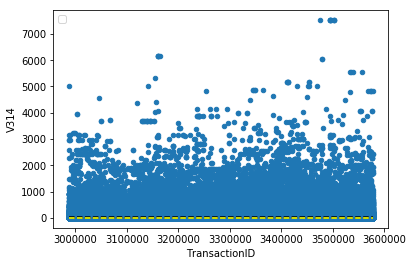

Column Name is V315:


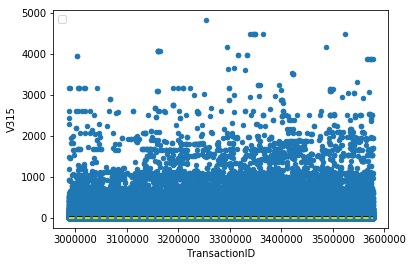

Column Name is V316:


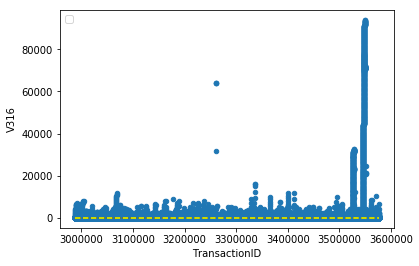

Column Name is V317:


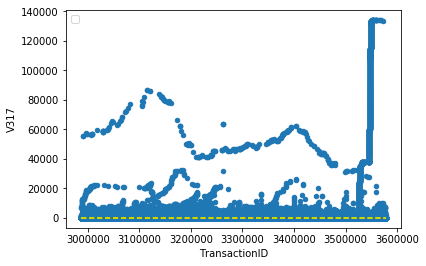

Column Name is V318:


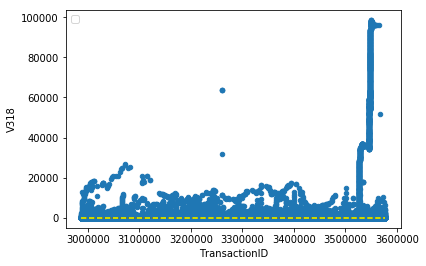

Column Name is V319:


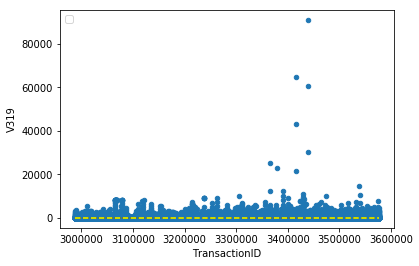

Column Name is V320:


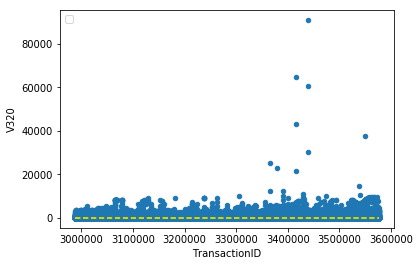

Column Name is V321:


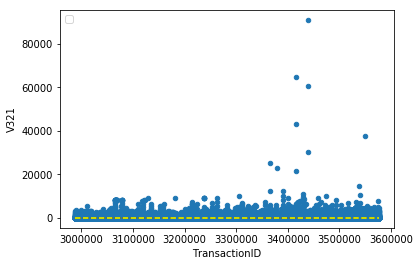

In [23]:
visualization(nan_train, df_train_describe)

### 1.2.2 outlier

#### 1.2.2.1 processing the outlier by the mean

In [24]:
time_of_mean_limitation = [3, 0.2]

In [25]:
unremove_field = ["TransactionID", "isFraud", "TransactionDT"]

In [26]:
def outlier(limitation, df, description, nan_fill_dict):
    upper_limitation, bottom_limitation = limitation
    number_field = list(nan_fill_dict["number"].keys())
    for tmp_ in unremove_field:
        number_field.remove(tmp_)
    
    mean = description.loc["mean"]
    
    for tmp_field in number_field:
        df[tmp_field].loc[df[tmp_field] > mean[tmp_field] * upper_limitation] = mean[tmp_field] * upper_limitation
        df[tmp_field].loc[df[tmp_field] < mean[tmp_field] * bottom_limitation] = mean[tmp_field] * bottom_limitation

In [27]:
outlier(time_of_mean_limitation, nan_train, df_train_describe, nan_fill_dict)

/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [ ]:
visualization(nan_train, df_train_describe)

### 1.2.3 dummy variables

In [28]:
encode(nan_train)

ProductCD
card4
card6
P_emaildomain
M6


# *2. feature engineering*

In [29]:
nan_train["P_emaildomain"].loc[nan_train["P_emaildomain"] != 0] = 1

In [30]:
label_collection = nan_train.columns

In [31]:
train_label = label_collection.drop("isFraud").drop("TransactionID")

In [32]:
train_y_label = "isFraud"

## *3. model training*

### 3.1 dataset split

In [ ]:
def create_validation(partition, trainset, testset):
    return train_test_split(trainset, testset, test_size=partition)

# kfold = StratifiedKFold(n_splits=10, shuffle=True)

### 3.2 training

#### 3.2.1 model selection

##### 3.2.1.1 catboost

In [ ]:
learning_rate = [0.1, 0.01, 0.001]
depth = [7, 8, 9]

param_dict = dict(learning_rate=learning_rate, depth=depth)

model = CatBoostRegressor()

##### 3.2.1.2 xgboost


In [ ]:
learning_rate = [0.1, 0.01, 0.001]
n_estimators = [150, 300, 450]
max_depth = [7, 8, 9]

param_dict = dict(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth)

gbm = xgb.XGBRegressor(max_depth=3, n_estimators=300, learning_rate=0.05).fit(np_list_train, train_y)

#### 3.2.2 loss function selection

In [ ]:
def self_loss(calcul_result, predict_result):
    grad = abs(predict_result - calcul_result)
    hess = np.power(np.abs(grad), 0.5)
    return grad, hess

#### 3.2.3 gridsearch

In [ ]:
grid_search = GridSearchCV(model, param_dict)
grid_search.fit(np_list_train, train_y)

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_score_

#### 3.2.4 training

In [33]:
train_x = nan_train[train_label]
train_y = nan_train[train_y_label]
eval_set = None

In [ ]:
train_x, valid_x, train_y, valid_y = create_validation(0.2, train_x, train_y)
eval_set = (valid_x, valid_y)

In [34]:
train_model = CatBoostRegressor(learning_rate=0.001, logging_level='Verbose',iterations=10000, depth=7)
train_model.fit(train_x, train_y, eval_set=eval_set,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.1824015	total: 174ms	remaining: 28m 56s
1:	learn: 0.1823603	total: 316ms	remaining: 26m 19s
2:	learn: 0.1823193	total: 456ms	remaining: 25m 19s
3:	learn: 0.1822790	total: 586ms	remaining: 24m 23s
4:	learn: 0.1822380	total: 723ms	remaining: 24m 4s
5:	learn: 0.1821974	total: 871ms	remaining: 24m 11s
6:	learn: 0.1821570	total: 1s	remaining: 23m 48s
7:	learn: 0.1821164	total: 1.12s	remaining: 23m 24s
8:	learn: 0.1820761	total: 1.25s	remaining: 23m 2s
9:	learn: 0.1820364	total: 1.39s	remaining: 23m 5s
10:	learn: 0.1819966	total: 1.51s	remaining: 22m 55s
11:	learn: 0.1819560	total: 1.63s	remaining: 22m 39s
12:	learn: 0.1819155	total: 1.76s	remaining: 22m 31s
13:	learn: 0.1818764	total: 1.89s	remaining: 22m 25s
14:	learn: 0.1818359	total: 2.03s	remaining: 22m 32s
15:	learn: 0.1817967	total: 2.17s	remaining: 22m 32s
16:	learn: 0.1817567	total: 2.3s	remaining: 22m 32s
17:	learn: 0.1817163	total: 2.42s	remaining: 22m 21s
18:	learn: 0.1816762	total: 2.56s	remaining: 22m 26s
19:	learn:

156:	learn: 0.1767729	total: 20.8s	remaining: 21m 44s
157:	learn: 0.1767415	total: 21s	remaining: 21m 47s
158:	learn: 0.1767100	total: 21.1s	remaining: 21m 48s
159:	learn: 0.1766795	total: 21.3s	remaining: 21m 49s
160:	learn: 0.1766483	total: 21.4s	remaining: 21m 48s
161:	learn: 0.1766169	total: 21.6s	remaining: 21m 50s
162:	learn: 0.1765851	total: 21.7s	remaining: 21m 50s
163:	learn: 0.1765534	total: 21.9s	remaining: 21m 53s
164:	learn: 0.1765218	total: 22s	remaining: 21m 54s
165:	learn: 0.1764901	total: 22.2s	remaining: 21m 52s
166:	learn: 0.1764580	total: 22.3s	remaining: 21m 52s
167:	learn: 0.1764270	total: 22.4s	remaining: 21m 51s
168:	learn: 0.1763956	total: 22.6s	remaining: 21m 51s
169:	learn: 0.1763640	total: 22.7s	remaining: 21m 53s
170:	learn: 0.1763328	total: 22.9s	remaining: 21m 54s
171:	learn: 0.1763018	total: 23s	remaining: 21m 53s
172:	learn: 0.1762712	total: 23.1s	remaining: 21m 53s
173:	learn: 0.1762396	total: 23.3s	remaining: 21m 55s
174:	learn: 0.1762083	total: 23.4s

310:	learn: 0.1724171	total: 42.6s	remaining: 22m 6s
311:	learn: 0.1723918	total: 42.7s	remaining: 22m 6s
312:	learn: 0.1723672	total: 42.9s	remaining: 22m 6s
313:	learn: 0.1723416	total: 43s	remaining: 22m 7s
314:	learn: 0.1723159	total: 43.1s	remaining: 22m 6s
315:	learn: 0.1722901	total: 43.3s	remaining: 22m 6s
316:	learn: 0.1722650	total: 43.4s	remaining: 22m 6s
317:	learn: 0.1722392	total: 43.6s	remaining: 22m 7s
318:	learn: 0.1722145	total: 43.7s	remaining: 22m 7s
319:	learn: 0.1721899	total: 43.9s	remaining: 22m 6s
320:	learn: 0.1721665	total: 44s	remaining: 22m 7s
321:	learn: 0.1721413	total: 44.2s	remaining: 22m 7s
322:	learn: 0.1721166	total: 44.3s	remaining: 22m 7s
323:	learn: 0.1720918	total: 44.5s	remaining: 22m 7s
324:	learn: 0.1720683	total: 44.6s	remaining: 22m 8s
325:	learn: 0.1720441	total: 44.8s	remaining: 22m 8s
326:	learn: 0.1720198	total: 44.9s	remaining: 22m 8s
327:	learn: 0.1719955	total: 45.1s	remaining: 22m 9s
328:	learn: 0.1719713	total: 45.2s	remaining: 22m 

465:	learn: 0.1689742	total: 1m 4s	remaining: 21m 58s
466:	learn: 0.1689547	total: 1m 4s	remaining: 21m 58s
467:	learn: 0.1689349	total: 1m 4s	remaining: 21m 58s
468:	learn: 0.1689147	total: 1m 4s	remaining: 21m 58s
469:	learn: 0.1688956	total: 1m 4s	remaining: 21m 57s
470:	learn: 0.1688762	total: 1m 5s	remaining: 21m 57s
471:	learn: 0.1688570	total: 1m 5s	remaining: 21m 56s
472:	learn: 0.1688381	total: 1m 5s	remaining: 21m 57s
473:	learn: 0.1688180	total: 1m 5s	remaining: 21m 58s
474:	learn: 0.1687994	total: 1m 5s	remaining: 21m 58s
475:	learn: 0.1687795	total: 1m 5s	remaining: 21m 58s
476:	learn: 0.1687601	total: 1m 6s	remaining: 21m 58s
477:	learn: 0.1687417	total: 1m 6s	remaining: 21m 59s
478:	learn: 0.1687226	total: 1m 6s	remaining: 21m 59s
479:	learn: 0.1687038	total: 1m 6s	remaining: 21m 59s
480:	learn: 0.1686844	total: 1m 6s	remaining: 21m 59s
481:	learn: 0.1686657	total: 1m 6s	remaining: 21m 59s
482:	learn: 0.1686471	total: 1m 7s	remaining: 22m
483:	learn: 0.1686282	total: 1m 

617:	learn: 0.1663072	total: 1m 28s	remaining: 22m 22s
618:	learn: 0.1662916	total: 1m 28s	remaining: 22m 22s
619:	learn: 0.1662757	total: 1m 28s	remaining: 22m 22s
620:	learn: 0.1662601	total: 1m 28s	remaining: 22m 22s
621:	learn: 0.1662441	total: 1m 29s	remaining: 22m 21s
622:	learn: 0.1662281	total: 1m 29s	remaining: 22m 21s
623:	learn: 0.1662129	total: 1m 29s	remaining: 22m 21s
624:	learn: 0.1661971	total: 1m 29s	remaining: 22m 22s
625:	learn: 0.1661820	total: 1m 29s	remaining: 22m 22s
626:	learn: 0.1661664	total: 1m 29s	remaining: 22m 22s
627:	learn: 0.1661512	total: 1m 29s	remaining: 22m 22s
628:	learn: 0.1661359	total: 1m 30s	remaining: 22m 22s
629:	learn: 0.1661205	total: 1m 30s	remaining: 22m 22s
630:	learn: 0.1661040	total: 1m 30s	remaining: 22m 22s
631:	learn: 0.1660880	total: 1m 30s	remaining: 22m 22s
632:	learn: 0.1660731	total: 1m 30s	remaining: 22m 21s
633:	learn: 0.1660579	total: 1m 30s	remaining: 22m 21s
634:	learn: 0.1660426	total: 1m 30s	remaining: 22m 21s
635:	learn

766:	learn: 0.1642014	total: 1m 51s	remaining: 22m 22s
767:	learn: 0.1641878	total: 1m 51s	remaining: 22m 23s
768:	learn: 0.1641753	total: 1m 51s	remaining: 22m 23s
769:	learn: 0.1641630	total: 1m 52s	remaining: 22m 22s
770:	learn: 0.1641505	total: 1m 52s	remaining: 22m 22s
771:	learn: 0.1641380	total: 1m 52s	remaining: 22m 22s
772:	learn: 0.1641251	total: 1m 52s	remaining: 22m 22s
773:	learn: 0.1641125	total: 1m 52s	remaining: 22m 22s
774:	learn: 0.1641002	total: 1m 52s	remaining: 22m 21s
775:	learn: 0.1640879	total: 1m 52s	remaining: 22m 21s
776:	learn: 0.1640754	total: 1m 53s	remaining: 22m 21s
777:	learn: 0.1640623	total: 1m 53s	remaining: 22m 21s
778:	learn: 0.1640501	total: 1m 53s	remaining: 22m 21s
779:	learn: 0.1640375	total: 1m 53s	remaining: 22m 21s
780:	learn: 0.1640247	total: 1m 53s	remaining: 22m 21s
781:	learn: 0.1640108	total: 1m 53s	remaining: 22m 21s
782:	learn: 0.1639975	total: 1m 53s	remaining: 22m 21s
783:	learn: 0.1639852	total: 1m 54s	remaining: 22m 21s
784:	learn

920:	learn: 0.1624306	total: 2m 13s	remaining: 21m 55s
921:	learn: 0.1624205	total: 2m 13s	remaining: 21m 55s
922:	learn: 0.1624103	total: 2m 13s	remaining: 21m 55s
923:	learn: 0.1624008	total: 2m 13s	remaining: 21m 55s
924:	learn: 0.1623911	total: 2m 14s	remaining: 21m 55s
925:	learn: 0.1623792	total: 2m 14s	remaining: 21m 55s
926:	learn: 0.1623681	total: 2m 14s	remaining: 21m 55s
927:	learn: 0.1623579	total: 2m 14s	remaining: 21m 54s
928:	learn: 0.1623465	total: 2m 14s	remaining: 21m 54s
929:	learn: 0.1623365	total: 2m 14s	remaining: 21m 54s
930:	learn: 0.1623246	total: 2m 14s	remaining: 21m 54s
931:	learn: 0.1623146	total: 2m 15s	remaining: 21m 53s
932:	learn: 0.1623043	total: 2m 15s	remaining: 21m 53s
933:	learn: 0.1622929	total: 2m 15s	remaining: 21m 53s
934:	learn: 0.1622815	total: 2m 15s	remaining: 21m 53s
935:	learn: 0.1622710	total: 2m 15s	remaining: 21m 53s
936:	learn: 0.1622607	total: 2m 15s	remaining: 21m 53s
937:	learn: 0.1622500	total: 2m 15s	remaining: 21m 52s
938:	learn

1068:	learn: 0.1609874	total: 2m 36s	remaining: 21m 44s
1069:	learn: 0.1609771	total: 2m 36s	remaining: 21m 44s
1070:	learn: 0.1609669	total: 2m 36s	remaining: 21m 44s
1071:	learn: 0.1609574	total: 2m 36s	remaining: 21m 44s
1072:	learn: 0.1609471	total: 2m 36s	remaining: 21m 44s
1073:	learn: 0.1609375	total: 2m 36s	remaining: 21m 43s
1074:	learn: 0.1609289	total: 2m 37s	remaining: 21m 43s
1075:	learn: 0.1609201	total: 2m 37s	remaining: 21m 43s
1076:	learn: 0.1609123	total: 2m 37s	remaining: 21m 43s
1077:	learn: 0.1609022	total: 2m 37s	remaining: 21m 43s
1078:	learn: 0.1608923	total: 2m 37s	remaining: 21m 43s
1079:	learn: 0.1608823	total: 2m 37s	remaining: 21m 42s
1080:	learn: 0.1608741	total: 2m 37s	remaining: 21m 42s
1081:	learn: 0.1608638	total: 2m 38s	remaining: 21m 42s
1082:	learn: 0.1608555	total: 2m 38s	remaining: 21m 42s
1083:	learn: 0.1608466	total: 2m 38s	remaining: 21m 42s
1084:	learn: 0.1608378	total: 2m 38s	remaining: 21m 42s
1085:	learn: 0.1608295	total: 2m 38s	remaining: 

1216:	learn: 0.1597411	total: 2m 58s	remaining: 21m 27s
1217:	learn: 0.1597336	total: 2m 58s	remaining: 21m 27s
1218:	learn: 0.1597268	total: 2m 58s	remaining: 21m 27s
1219:	learn: 0.1597200	total: 2m 58s	remaining: 21m 26s
1220:	learn: 0.1597115	total: 2m 58s	remaining: 21m 26s
1221:	learn: 0.1597030	total: 2m 59s	remaining: 21m 26s
1222:	learn: 0.1596954	total: 2m 59s	remaining: 21m 26s
1223:	learn: 0.1596881	total: 2m 59s	remaining: 21m 26s
1224:	learn: 0.1596813	total: 2m 59s	remaining: 21m 26s
1225:	learn: 0.1596741	total: 2m 59s	remaining: 21m 26s
1226:	learn: 0.1596672	total: 2m 59s	remaining: 21m 25s
1227:	learn: 0.1596605	total: 3m	remaining: 21m 25s
1228:	learn: 0.1596532	total: 3m	remaining: 21m 25s
1229:	learn: 0.1596459	total: 3m	remaining: 21m 25s
1230:	learn: 0.1596394	total: 3m	remaining: 21m 24s
1231:	learn: 0.1596323	total: 3m	remaining: 21m 24s
1232:	learn: 0.1596255	total: 3m	remaining: 21m 24s
1233:	learn: 0.1596171	total: 3m	remaining: 21m 24s
1234:	learn: 0.15960

1365:	learn: 0.1586874	total: 3m 20s	remaining: 21m 7s
1366:	learn: 0.1586801	total: 3m 20s	remaining: 21m 7s
1367:	learn: 0.1586728	total: 3m 20s	remaining: 21m 7s
1368:	learn: 0.1586671	total: 3m 21s	remaining: 21m 7s
1369:	learn: 0.1586599	total: 3m 21s	remaining: 21m 7s
1370:	learn: 0.1586540	total: 3m 21s	remaining: 21m 7s
1371:	learn: 0.1586481	total: 3m 21s	remaining: 21m 7s
1372:	learn: 0.1586406	total: 3m 21s	remaining: 21m 6s
1373:	learn: 0.1586345	total: 3m 21s	remaining: 21m 6s
1374:	learn: 0.1586277	total: 3m 21s	remaining: 21m 6s
1375:	learn: 0.1586205	total: 3m 22s	remaining: 21m 6s
1376:	learn: 0.1586145	total: 3m 22s	remaining: 21m 6s
1377:	learn: 0.1586085	total: 3m 22s	remaining: 21m 6s
1378:	learn: 0.1586022	total: 3m 22s	remaining: 21m 6s
1379:	learn: 0.1585953	total: 3m 22s	remaining: 21m 6s
1380:	learn: 0.1585882	total: 3m 22s	remaining: 21m 5s
1381:	learn: 0.1585823	total: 3m 23s	remaining: 21m 6s
1382:	learn: 0.1585755	total: 3m 23s	remaining: 21m 5s
1383:	lear

1513:	learn: 0.1578051	total: 3m 43s	remaining: 20m 52s
1514:	learn: 0.1577999	total: 3m 43s	remaining: 20m 52s
1515:	learn: 0.1577940	total: 3m 43s	remaining: 20m 52s
1516:	learn: 0.1577877	total: 3m 43s	remaining: 20m 52s
1517:	learn: 0.1577827	total: 3m 44s	remaining: 20m 52s
1518:	learn: 0.1577765	total: 3m 44s	remaining: 20m 52s
1519:	learn: 0.1577715	total: 3m 44s	remaining: 20m 52s
1520:	learn: 0.1577660	total: 3m 44s	remaining: 20m 51s
1521:	learn: 0.1577606	total: 3m 44s	remaining: 20m 51s
1522:	learn: 0.1577552	total: 3m 44s	remaining: 20m 51s
1523:	learn: 0.1577503	total: 3m 44s	remaining: 20m 51s
1524:	learn: 0.1577451	total: 3m 45s	remaining: 20m 51s
1525:	learn: 0.1577400	total: 3m 45s	remaining: 20m 51s
1526:	learn: 0.1577341	total: 3m 45s	remaining: 20m 51s
1527:	learn: 0.1577279	total: 3m 45s	remaining: 20m 51s
1528:	learn: 0.1577222	total: 3m 45s	remaining: 20m 51s
1529:	learn: 0.1577173	total: 3m 46s	remaining: 20m 51s
1530:	learn: 0.1577116	total: 3m 46s	remaining: 

1661:	learn: 0.1570441	total: 4m 6s	remaining: 20m 37s
1662:	learn: 0.1570396	total: 4m 6s	remaining: 20m 37s
1663:	learn: 0.1570356	total: 4m 7s	remaining: 20m 37s
1664:	learn: 0.1570308	total: 4m 7s	remaining: 20m 37s
1665:	learn: 0.1570256	total: 4m 7s	remaining: 20m 37s
1666:	learn: 0.1570209	total: 4m 7s	remaining: 20m 37s
1667:	learn: 0.1570161	total: 4m 7s	remaining: 20m 37s
1668:	learn: 0.1570113	total: 4m 7s	remaining: 20m 37s
1669:	learn: 0.1570073	total: 4m 7s	remaining: 20m 36s
1670:	learn: 0.1570024	total: 4m 8s	remaining: 20m 36s
1671:	learn: 0.1569975	total: 4m 8s	remaining: 20m 36s
1672:	learn: 0.1569928	total: 4m 8s	remaining: 20m 36s
1673:	learn: 0.1569878	total: 4m 8s	remaining: 20m 36s
1674:	learn: 0.1569833	total: 4m 8s	remaining: 20m 35s
1675:	learn: 0.1569782	total: 4m 8s	remaining: 20m 35s
1676:	learn: 0.1569735	total: 4m 8s	remaining: 20m 35s
1677:	learn: 0.1569695	total: 4m 9s	remaining: 20m 35s
1678:	learn: 0.1569649	total: 4m 9s	remaining: 20m 35s
1679:	lear

1809:	learn: 0.1563962	total: 4m 28s	remaining: 20m 13s
1810:	learn: 0.1563916	total: 4m 28s	remaining: 20m 13s
1811:	learn: 0.1563876	total: 4m 28s	remaining: 20m 12s
1812:	learn: 0.1563839	total: 4m 28s	remaining: 20m 12s
1813:	learn: 0.1563791	total: 4m 28s	remaining: 20m 12s
1814:	learn: 0.1563742	total: 4m 28s	remaining: 20m 12s
1815:	learn: 0.1563693	total: 4m 29s	remaining: 20m 12s
1816:	learn: 0.1563651	total: 4m 29s	remaining: 20m 12s
1817:	learn: 0.1563605	total: 4m 29s	remaining: 20m 11s
1818:	learn: 0.1563563	total: 4m 29s	remaining: 20m 11s
1819:	learn: 0.1563519	total: 4m 29s	remaining: 20m 11s
1820:	learn: 0.1563481	total: 4m 29s	remaining: 20m 11s
1821:	learn: 0.1563433	total: 4m 29s	remaining: 20m 11s
1822:	learn: 0.1563397	total: 4m 30s	remaining: 20m 11s
1823:	learn: 0.1563358	total: 4m 30s	remaining: 20m 11s
1824:	learn: 0.1563316	total: 4m 30s	remaining: 20m 10s
1825:	learn: 0.1563278	total: 4m 30s	remaining: 20m 10s
1826:	learn: 0.1563233	total: 4m 30s	remaining: 

1958:	learn: 0.1558250	total: 4m 49s	remaining: 19m 48s
1959:	learn: 0.1558212	total: 4m 49s	remaining: 19m 48s
1960:	learn: 0.1558180	total: 4m 49s	remaining: 19m 48s
1961:	learn: 0.1558143	total: 4m 50s	remaining: 19m 48s
1962:	learn: 0.1558107	total: 4m 50s	remaining: 19m 48s
1963:	learn: 0.1558072	total: 4m 50s	remaining: 19m 48s
1964:	learn: 0.1558036	total: 4m 50s	remaining: 19m 47s
1965:	learn: 0.1557996	total: 4m 50s	remaining: 19m 47s
1966:	learn: 0.1557957	total: 4m 50s	remaining: 19m 47s
1967:	learn: 0.1557926	total: 4m 50s	remaining: 19m 47s
1968:	learn: 0.1557889	total: 4m 51s	remaining: 19m 47s
1969:	learn: 0.1557848	total: 4m 51s	remaining: 19m 47s
1970:	learn: 0.1557813	total: 4m 51s	remaining: 19m 46s
1971:	learn: 0.1557782	total: 4m 51s	remaining: 19m 46s
1972:	learn: 0.1557744	total: 4m 51s	remaining: 19m 46s
1973:	learn: 0.1557710	total: 4m 51s	remaining: 19m 46s
1974:	learn: 0.1557671	total: 4m 51s	remaining: 19m 46s
1975:	learn: 0.1557638	total: 4m 52s	remaining: 

2106:	learn: 0.1553159	total: 5m 11s	remaining: 19m 27s
2107:	learn: 0.1553127	total: 5m 11s	remaining: 19m 27s
2108:	learn: 0.1553092	total: 5m 11s	remaining: 19m 26s
2109:	learn: 0.1553058	total: 5m 12s	remaining: 19m 27s
2110:	learn: 0.1553027	total: 5m 12s	remaining: 19m 27s
2111:	learn: 0.1552995	total: 5m 12s	remaining: 19m 26s
2112:	learn: 0.1552963	total: 5m 12s	remaining: 19m 26s
2113:	learn: 0.1552930	total: 5m 12s	remaining: 19m 26s
2114:	learn: 0.1552902	total: 5m 12s	remaining: 19m 26s
2115:	learn: 0.1552869	total: 5m 13s	remaining: 19m 26s
2116:	learn: 0.1552835	total: 5m 13s	remaining: 19m 26s
2117:	learn: 0.1552802	total: 5m 13s	remaining: 19m 26s
2118:	learn: 0.1552769	total: 5m 13s	remaining: 19m 26s
2119:	learn: 0.1552744	total: 5m 13s	remaining: 19m 25s
2120:	learn: 0.1552706	total: 5m 13s	remaining: 19m 25s
2121:	learn: 0.1552678	total: 5m 13s	remaining: 19m 25s
2122:	learn: 0.1552642	total: 5m 14s	remaining: 19m 25s
2123:	learn: 0.1552610	total: 5m 14s	remaining: 

2253:	learn: 0.1548614	total: 5m 33s	remaining: 19m 5s
2254:	learn: 0.1548580	total: 5m 33s	remaining: 19m 5s
2255:	learn: 0.1548555	total: 5m 33s	remaining: 19m 5s
2256:	learn: 0.1548530	total: 5m 33s	remaining: 19m 5s
2257:	learn: 0.1548500	total: 5m 34s	remaining: 19m 5s
2258:	learn: 0.1548469	total: 5m 34s	remaining: 19m 5s
2259:	learn: 0.1548438	total: 5m 34s	remaining: 19m 4s
2260:	learn: 0.1548405	total: 5m 34s	remaining: 19m 4s
2261:	learn: 0.1548376	total: 5m 34s	remaining: 19m 4s
2262:	learn: 0.1548342	total: 5m 34s	remaining: 19m 4s
2263:	learn: 0.1548310	total: 5m 34s	remaining: 19m 4s
2264:	learn: 0.1548282	total: 5m 35s	remaining: 19m 4s
2265:	learn: 0.1548257	total: 5m 35s	remaining: 19m 3s
2266:	learn: 0.1548230	total: 5m 35s	remaining: 19m 3s
2267:	learn: 0.1548199	total: 5m 35s	remaining: 19m 3s
2268:	learn: 0.1548175	total: 5m 35s	remaining: 19m 3s
2269:	learn: 0.1548144	total: 5m 35s	remaining: 19m 3s
2270:	learn: 0.1548120	total: 5m 35s	remaining: 19m 3s
2271:	lear

2401:	learn: 0.1544446	total: 5m 55s	remaining: 18m 43s
2402:	learn: 0.1544419	total: 5m 55s	remaining: 18m 43s
2403:	learn: 0.1544390	total: 5m 55s	remaining: 18m 42s
2404:	learn: 0.1544364	total: 5m 55s	remaining: 18m 42s
2405:	learn: 0.1544338	total: 5m 55s	remaining: 18m 42s
2406:	learn: 0.1544309	total: 5m 55s	remaining: 18m 42s
2407:	learn: 0.1544286	total: 5m 56s	remaining: 18m 42s
2408:	learn: 0.1544261	total: 5m 56s	remaining: 18m 42s
2409:	learn: 0.1544238	total: 5m 56s	remaining: 18m 42s
2410:	learn: 0.1544216	total: 5m 56s	remaining: 18m 41s
2411:	learn: 0.1544189	total: 5m 56s	remaining: 18m 41s
2412:	learn: 0.1544166	total: 5m 56s	remaining: 18m 41s
2413:	learn: 0.1544135	total: 5m 56s	remaining: 18m 41s
2414:	learn: 0.1544114	total: 5m 56s	remaining: 18m 40s
2415:	learn: 0.1544090	total: 5m 57s	remaining: 18m 40s
2416:	learn: 0.1544059	total: 5m 57s	remaining: 18m 40s
2417:	learn: 0.1544026	total: 5m 57s	remaining: 18m 40s
2418:	learn: 0.1544001	total: 5m 57s	remaining: 

2549:	learn: 0.1540727	total: 6m 16s	remaining: 18m 20s
2550:	learn: 0.1540704	total: 6m 16s	remaining: 18m 20s
2551:	learn: 0.1540675	total: 6m 17s	remaining: 18m 20s
2552:	learn: 0.1540653	total: 6m 17s	remaining: 18m 20s
2553:	learn: 0.1540628	total: 6m 17s	remaining: 18m 20s
2554:	learn: 0.1540605	total: 6m 17s	remaining: 18m 19s
2555:	learn: 0.1540578	total: 6m 17s	remaining: 18m 19s
2556:	learn: 0.1540550	total: 6m 17s	remaining: 18m 19s
2557:	learn: 0.1540527	total: 6m 17s	remaining: 18m 19s
2558:	learn: 0.1540500	total: 6m 18s	remaining: 18m 19s
2559:	learn: 0.1540476	total: 6m 18s	remaining: 18m 19s
2560:	learn: 0.1540452	total: 6m 18s	remaining: 18m 19s
2561:	learn: 0.1540430	total: 6m 18s	remaining: 18m 18s
2562:	learn: 0.1540403	total: 6m 18s	remaining: 18m 18s
2563:	learn: 0.1540379	total: 6m 18s	remaining: 18m 18s
2564:	learn: 0.1540354	total: 6m 18s	remaining: 18m 18s
2565:	learn: 0.1540327	total: 6m 19s	remaining: 18m 18s
2566:	learn: 0.1540301	total: 6m 19s	remaining: 

2699:	learn: 0.1537164	total: 6m 39s	remaining: 17m 59s
2700:	learn: 0.1537143	total: 6m 39s	remaining: 17m 59s
2701:	learn: 0.1537122	total: 6m 39s	remaining: 17m 59s
2702:	learn: 0.1537088	total: 6m 39s	remaining: 17m 58s
2703:	learn: 0.1537063	total: 6m 39s	remaining: 17m 58s
2704:	learn: 0.1537033	total: 6m 39s	remaining: 17m 58s
2705:	learn: 0.1537013	total: 6m 40s	remaining: 17m 58s
2706:	learn: 0.1536992	total: 6m 40s	remaining: 17m 58s
2707:	learn: 0.1536970	total: 6m 40s	remaining: 17m 58s
2708:	learn: 0.1536954	total: 6m 40s	remaining: 17m 57s
2709:	learn: 0.1536936	total: 6m 40s	remaining: 17m 57s
2710:	learn: 0.1536907	total: 6m 40s	remaining: 17m 57s
2711:	learn: 0.1536884	total: 6m 40s	remaining: 17m 57s
2712:	learn: 0.1536859	total: 6m 41s	remaining: 17m 57s
2713:	learn: 0.1536840	total: 6m 41s	remaining: 17m 57s
2714:	learn: 0.1536817	total: 6m 41s	remaining: 17m 56s
2715:	learn: 0.1536796	total: 6m 41s	remaining: 17m 56s
2716:	learn: 0.1536766	total: 6m 41s	remaining: 

2846:	learn: 0.1533805	total: 7m 1s	remaining: 17m 39s
2847:	learn: 0.1533785	total: 7m 1s	remaining: 17m 38s
2848:	learn: 0.1533764	total: 7m 1s	remaining: 17m 38s
2849:	learn: 0.1533746	total: 7m 1s	remaining: 17m 38s
2850:	learn: 0.1533722	total: 7m 2s	remaining: 17m 38s
2851:	learn: 0.1533704	total: 7m 2s	remaining: 17m 38s
2852:	learn: 0.1533684	total: 7m 2s	remaining: 17m 38s
2853:	learn: 0.1533663	total: 7m 2s	remaining: 17m 38s
2854:	learn: 0.1533646	total: 7m 2s	remaining: 17m 37s
2855:	learn: 0.1533622	total: 7m 2s	remaining: 17m 37s
2856:	learn: 0.1533604	total: 7m 3s	remaining: 17m 37s
2857:	learn: 0.1533581	total: 7m 3s	remaining: 17m 37s
2858:	learn: 0.1533561	total: 7m 3s	remaining: 17m 37s
2859:	learn: 0.1533533	total: 7m 3s	remaining: 17m 37s
2860:	learn: 0.1533511	total: 7m 3s	remaining: 17m 37s
2861:	learn: 0.1533495	total: 7m 3s	remaining: 17m 36s
2862:	learn: 0.1533475	total: 7m 3s	remaining: 17m 36s
2863:	learn: 0.1533457	total: 7m 4s	remaining: 17m 36s
2864:	lear

2995:	learn: 0.1530705	total: 7m 23s	remaining: 17m 17s
2996:	learn: 0.1530685	total: 7m 23s	remaining: 17m 17s
2997:	learn: 0.1530662	total: 7m 23s	remaining: 17m 16s
2998:	learn: 0.1530639	total: 7m 24s	remaining: 17m 17s
2999:	learn: 0.1530623	total: 7m 24s	remaining: 17m 16s
3000:	learn: 0.1530596	total: 7m 24s	remaining: 17m 16s
3001:	learn: 0.1530580	total: 7m 24s	remaining: 17m 16s
3002:	learn: 0.1530559	total: 7m 24s	remaining: 17m 16s
3003:	learn: 0.1530532	total: 7m 24s	remaining: 17m 16s
3004:	learn: 0.1530514	total: 7m 25s	remaining: 17m 16s
3005:	learn: 0.1530492	total: 7m 25s	remaining: 17m 15s
3006:	learn: 0.1530468	total: 7m 25s	remaining: 17m 15s
3007:	learn: 0.1530446	total: 7m 25s	remaining: 17m 15s
3008:	learn: 0.1530428	total: 7m 25s	remaining: 17m 15s
3009:	learn: 0.1530408	total: 7m 25s	remaining: 17m 15s
3010:	learn: 0.1530386	total: 7m 26s	remaining: 17m 15s
3011:	learn: 0.1530365	total: 7m 26s	remaining: 17m 15s
3012:	learn: 0.1530342	total: 7m 26s	remaining: 

3143:	learn: 0.1527670	total: 7m 46s	remaining: 16m 56s
3144:	learn: 0.1527654	total: 7m 46s	remaining: 16m 56s
3145:	learn: 0.1527632	total: 7m 46s	remaining: 16m 56s
3146:	learn: 0.1527618	total: 7m 46s	remaining: 16m 56s
3147:	learn: 0.1527600	total: 7m 46s	remaining: 16m 56s
3148:	learn: 0.1527586	total: 7m 46s	remaining: 16m 55s
3149:	learn: 0.1527567	total: 7m 47s	remaining: 16m 55s
3150:	learn: 0.1527539	total: 7m 47s	remaining: 16m 55s
3151:	learn: 0.1527521	total: 7m 47s	remaining: 16m 55s
3152:	learn: 0.1527503	total: 7m 47s	remaining: 16m 55s
3153:	learn: 0.1527483	total: 7m 47s	remaining: 16m 55s
3154:	learn: 0.1527465	total: 7m 47s	remaining: 16m 55s
3155:	learn: 0.1527445	total: 7m 48s	remaining: 16m 54s
3156:	learn: 0.1527427	total: 7m 48s	remaining: 16m 54s
3157:	learn: 0.1527409	total: 7m 48s	remaining: 16m 54s
3158:	learn: 0.1527393	total: 7m 48s	remaining: 16m 54s
3159:	learn: 0.1527370	total: 7m 48s	remaining: 16m 54s
3160:	learn: 0.1527346	total: 7m 48s	remaining: 

3291:	learn: 0.1524870	total: 8m 8s	remaining: 16m 35s
3292:	learn: 0.1524855	total: 8m 8s	remaining: 16m 35s
3293:	learn: 0.1524839	total: 8m 9s	remaining: 16m 35s
3294:	learn: 0.1524825	total: 8m 9s	remaining: 16m 35s
3295:	learn: 0.1524812	total: 8m 9s	remaining: 16m 35s
3296:	learn: 0.1524797	total: 8m 9s	remaining: 16m 34s
3297:	learn: 0.1524784	total: 8m 9s	remaining: 16m 34s
3298:	learn: 0.1524768	total: 8m 9s	remaining: 16m 34s
3299:	learn: 0.1524755	total: 8m 9s	remaining: 16m 34s
3300:	learn: 0.1524732	total: 8m 9s	remaining: 16m 34s
3301:	learn: 0.1524712	total: 8m 10s	remaining: 16m 34s
3302:	learn: 0.1524698	total: 8m 10s	remaining: 16m 33s
3303:	learn: 0.1524682	total: 8m 10s	remaining: 16m 33s
3304:	learn: 0.1524663	total: 8m 10s	remaining: 16m 33s
3305:	learn: 0.1524646	total: 8m 10s	remaining: 16m 33s
3306:	learn: 0.1524625	total: 8m 10s	remaining: 16m 33s
3307:	learn: 0.1524609	total: 8m 11s	remaining: 16m 33s
3308:	learn: 0.1524594	total: 8m 11s	remaining: 16m 33s
33

3439:	learn: 0.1522236	total: 8m 31s	remaining: 16m 15s
3440:	learn: 0.1522212	total: 8m 31s	remaining: 16m 14s
3441:	learn: 0.1522195	total: 8m 31s	remaining: 16m 14s
3442:	learn: 0.1522176	total: 8m 31s	remaining: 16m 14s
3443:	learn: 0.1522158	total: 8m 31s	remaining: 16m 14s
3444:	learn: 0.1522139	total: 8m 32s	remaining: 16m 14s
3445:	learn: 0.1522119	total: 8m 32s	remaining: 16m 14s
3446:	learn: 0.1522097	total: 8m 32s	remaining: 16m 14s
3447:	learn: 0.1522077	total: 8m 32s	remaining: 16m 14s
3448:	learn: 0.1522062	total: 8m 32s	remaining: 16m 13s
3449:	learn: 0.1522048	total: 8m 32s	remaining: 16m 13s
3450:	learn: 0.1522031	total: 8m 33s	remaining: 16m 13s
3451:	learn: 0.1522013	total: 8m 33s	remaining: 16m 13s
3452:	learn: 0.1521992	total: 8m 33s	remaining: 16m 13s
3453:	learn: 0.1521974	total: 8m 33s	remaining: 16m 13s
3454:	learn: 0.1521961	total: 8m 33s	remaining: 16m 13s
3455:	learn: 0.1521948	total: 8m 33s	remaining: 16m 12s
3456:	learn: 0.1521924	total: 8m 33s	remaining: 

3587:	learn: 0.1519600	total: 8m 54s	remaining: 15m 55s
3588:	learn: 0.1519585	total: 8m 54s	remaining: 15m 55s
3589:	learn: 0.1519565	total: 8m 54s	remaining: 15m 54s
3590:	learn: 0.1519549	total: 8m 54s	remaining: 15m 54s
3591:	learn: 0.1519531	total: 8m 55s	remaining: 15m 54s
3592:	learn: 0.1519519	total: 8m 55s	remaining: 15m 54s
3593:	learn: 0.1519505	total: 8m 55s	remaining: 15m 54s
3594:	learn: 0.1519487	total: 8m 55s	remaining: 15m 54s
3595:	learn: 0.1519472	total: 8m 55s	remaining: 15m 54s
3596:	learn: 0.1519454	total: 8m 55s	remaining: 15m 53s
3597:	learn: 0.1519435	total: 8m 56s	remaining: 15m 53s
3598:	learn: 0.1519424	total: 8m 56s	remaining: 15m 53s
3599:	learn: 0.1519410	total: 8m 56s	remaining: 15m 53s
3600:	learn: 0.1519395	total: 8m 56s	remaining: 15m 53s
3601:	learn: 0.1519383	total: 8m 56s	remaining: 15m 53s
3602:	learn: 0.1519368	total: 8m 56s	remaining: 15m 52s
3603:	learn: 0.1519356	total: 8m 56s	remaining: 15m 52s
3604:	learn: 0.1519340	total: 8m 57s	remaining: 

3736:	learn: 0.1517052	total: 9m 18s	remaining: 15m 35s
3737:	learn: 0.1517031	total: 9m 18s	remaining: 15m 35s
3738:	learn: 0.1517008	total: 9m 18s	remaining: 15m 35s
3739:	learn: 0.1516993	total: 9m 18s	remaining: 15m 35s
3740:	learn: 0.1516979	total: 9m 18s	remaining: 15m 34s
3741:	learn: 0.1516962	total: 9m 18s	remaining: 15m 34s
3742:	learn: 0.1516951	total: 9m 19s	remaining: 15m 34s
3743:	learn: 0.1516933	total: 9m 19s	remaining: 15m 34s
3744:	learn: 0.1516919	total: 9m 19s	remaining: 15m 34s
3745:	learn: 0.1516901	total: 9m 19s	remaining: 15m 34s
3746:	learn: 0.1516875	total: 9m 19s	remaining: 15m 34s
3747:	learn: 0.1516853	total: 9m 19s	remaining: 15m 33s
3748:	learn: 0.1516836	total: 9m 20s	remaining: 15m 33s
3749:	learn: 0.1516817	total: 9m 20s	remaining: 15m 33s
3750:	learn: 0.1516802	total: 9m 20s	remaining: 15m 33s
3751:	learn: 0.1516778	total: 9m 20s	remaining: 15m 33s
3752:	learn: 0.1516754	total: 9m 20s	remaining: 15m 33s
3753:	learn: 0.1516735	total: 9m 20s	remaining: 

3884:	learn: 0.1514644	total: 9m 41s	remaining: 15m 15s
3885:	learn: 0.1514624	total: 9m 41s	remaining: 15m 15s
3886:	learn: 0.1514610	total: 9m 41s	remaining: 15m 15s
3887:	learn: 0.1514588	total: 9m 42s	remaining: 15m 14s
3888:	learn: 0.1514579	total: 9m 42s	remaining: 15m 14s
3889:	learn: 0.1514562	total: 9m 42s	remaining: 15m 14s
3890:	learn: 0.1514546	total: 9m 42s	remaining: 15m 14s
3891:	learn: 0.1514534	total: 9m 42s	remaining: 15m 14s
3892:	learn: 0.1514518	total: 9m 42s	remaining: 15m 14s
3893:	learn: 0.1514506	total: 9m 42s	remaining: 15m 13s
3894:	learn: 0.1514493	total: 9m 42s	remaining: 15m 13s
3895:	learn: 0.1514474	total: 9m 43s	remaining: 15m 13s
3896:	learn: 0.1514461	total: 9m 43s	remaining: 15m 13s
3897:	learn: 0.1514441	total: 9m 43s	remaining: 15m 13s
3898:	learn: 0.1514425	total: 9m 43s	remaining: 15m 13s
3899:	learn: 0.1514408	total: 9m 43s	remaining: 15m 13s
3900:	learn: 0.1514393	total: 9m 43s	remaining: 15m 12s
3901:	learn: 0.1514378	total: 9m 44s	remaining: 

4033:	learn: 0.1512277	total: 10m 4s	remaining: 14m 54s
4034:	learn: 0.1512264	total: 10m 4s	remaining: 14m 54s
4035:	learn: 0.1512251	total: 10m 5s	remaining: 14m 54s
4036:	learn: 0.1512232	total: 10m 5s	remaining: 14m 54s
4037:	learn: 0.1512214	total: 10m 5s	remaining: 14m 53s
4038:	learn: 0.1512200	total: 10m 5s	remaining: 14m 53s
4039:	learn: 0.1512185	total: 10m 5s	remaining: 14m 53s
4040:	learn: 0.1512168	total: 10m 5s	remaining: 14m 53s
4041:	learn: 0.1512157	total: 10m 6s	remaining: 14m 53s
4042:	learn: 0.1512144	total: 10m 6s	remaining: 14m 53s
4043:	learn: 0.1512122	total: 10m 6s	remaining: 14m 53s
4044:	learn: 0.1512105	total: 10m 6s	remaining: 14m 52s
4045:	learn: 0.1512089	total: 10m 6s	remaining: 14m 52s
4046:	learn: 0.1512078	total: 10m 6s	remaining: 14m 52s
4047:	learn: 0.1512065	total: 10m 7s	remaining: 14m 52s
4048:	learn: 0.1512049	total: 10m 7s	remaining: 14m 52s
4049:	learn: 0.1512036	total: 10m 7s	remaining: 14m 52s
4050:	learn: 0.1512021	total: 10m 7s	remaining: 

4178:	learn: 0.1510153	total: 10m 27s	remaining: 14m 34s
4179:	learn: 0.1510140	total: 10m 28s	remaining: 14m 34s
4180:	learn: 0.1510129	total: 10m 28s	remaining: 14m 34s
4181:	learn: 0.1510115	total: 10m 28s	remaining: 14m 34s
4182:	learn: 0.1510103	total: 10m 28s	remaining: 14m 34s
4183:	learn: 0.1510084	total: 10m 28s	remaining: 14m 34s
4184:	learn: 0.1510067	total: 10m 28s	remaining: 14m 33s
4185:	learn: 0.1510049	total: 10m 29s	remaining: 14m 33s
4186:	learn: 0.1510040	total: 10m 29s	remaining: 14m 33s
4187:	learn: 0.1510027	total: 10m 29s	remaining: 14m 33s
4188:	learn: 0.1510012	total: 10m 29s	remaining: 14m 33s
4189:	learn: 0.1509999	total: 10m 29s	remaining: 14m 33s
4190:	learn: 0.1509986	total: 10m 29s	remaining: 14m 33s
4191:	learn: 0.1509967	total: 10m 30s	remaining: 14m 32s
4192:	learn: 0.1509953	total: 10m 30s	remaining: 14m 32s
4193:	learn: 0.1509930	total: 10m 30s	remaining: 14m 32s
4194:	learn: 0.1509917	total: 10m 30s	remaining: 14m 32s
4195:	learn: 0.1509906	total: 1

4323:	learn: 0.1508069	total: 10m 51s	remaining: 14m 14s
4324:	learn: 0.1508057	total: 10m 51s	remaining: 14m 14s
4325:	learn: 0.1508034	total: 10m 51s	remaining: 14m 14s
4326:	learn: 0.1508023	total: 10m 51s	remaining: 14m 14s
4327:	learn: 0.1508009	total: 10m 51s	remaining: 14m 14s
4328:	learn: 0.1507995	total: 10m 51s	remaining: 14m 13s
4329:	learn: 0.1507983	total: 10m 52s	remaining: 14m 13s
4330:	learn: 0.1507970	total: 10m 52s	remaining: 14m 13s
4331:	learn: 0.1507948	total: 10m 52s	remaining: 14m 13s
4332:	learn: 0.1507936	total: 10m 52s	remaining: 14m 13s
4333:	learn: 0.1507921	total: 10m 52s	remaining: 14m 13s
4334:	learn: 0.1507911	total: 10m 52s	remaining: 14m 13s
4335:	learn: 0.1507898	total: 10m 53s	remaining: 14m 13s
4336:	learn: 0.1507884	total: 10m 53s	remaining: 14m 12s
4337:	learn: 0.1507875	total: 10m 53s	remaining: 14m 12s
4338:	learn: 0.1507857	total: 10m 53s	remaining: 14m 12s
4339:	learn: 0.1507839	total: 10m 53s	remaining: 14m 12s
4340:	learn: 0.1507828	total: 1

4470:	learn: 0.1506059	total: 11m 14s	remaining: 13m 54s
4471:	learn: 0.1506045	total: 11m 14s	remaining: 13m 54s
4472:	learn: 0.1506034	total: 11m 14s	remaining: 13m 53s
4473:	learn: 0.1506020	total: 11m 15s	remaining: 13m 53s
4474:	learn: 0.1506009	total: 11m 15s	remaining: 13m 53s
4475:	learn: 0.1505999	total: 11m 15s	remaining: 13m 53s
4476:	learn: 0.1505992	total: 11m 15s	remaining: 13m 53s
4477:	learn: 0.1505973	total: 11m 15s	remaining: 13m 53s
4478:	learn: 0.1505960	total: 11m 15s	remaining: 13m 52s
4479:	learn: 0.1505949	total: 11m 15s	remaining: 13m 52s
4480:	learn: 0.1505940	total: 11m 16s	remaining: 13m 52s
4481:	learn: 0.1505921	total: 11m 16s	remaining: 13m 52s
4482:	learn: 0.1505907	total: 11m 16s	remaining: 13m 52s
4483:	learn: 0.1505891	total: 11m 16s	remaining: 13m 52s
4484:	learn: 0.1505879	total: 11m 16s	remaining: 13m 52s
4485:	learn: 0.1505867	total: 11m 16s	remaining: 13m 51s
4486:	learn: 0.1505855	total: 11m 16s	remaining: 13m 51s
4487:	learn: 0.1505844	total: 1

4614:	learn: 0.1504183	total: 11m 37s	remaining: 13m 33s
4615:	learn: 0.1504170	total: 11m 37s	remaining: 13m 33s
4616:	learn: 0.1504159	total: 11m 37s	remaining: 13m 33s
4617:	learn: 0.1504148	total: 11m 37s	remaining: 13m 32s
4618:	learn: 0.1504137	total: 11m 37s	remaining: 13m 32s
4619:	learn: 0.1504120	total: 11m 37s	remaining: 13m 32s
4620:	learn: 0.1504109	total: 11m 38s	remaining: 13m 32s
4621:	learn: 0.1504100	total: 11m 38s	remaining: 13m 32s
4622:	learn: 0.1504086	total: 11m 38s	remaining: 13m 32s
4623:	learn: 0.1504066	total: 11m 38s	remaining: 13m 32s
4624:	learn: 0.1504056	total: 11m 38s	remaining: 13m 31s
4625:	learn: 0.1504043	total: 11m 38s	remaining: 13m 31s
4626:	learn: 0.1504024	total: 11m 38s	remaining: 13m 31s
4627:	learn: 0.1504006	total: 11m 39s	remaining: 13m 31s
4628:	learn: 0.1503995	total: 11m 39s	remaining: 13m 31s
4629:	learn: 0.1503981	total: 11m 39s	remaining: 13m 31s
4630:	learn: 0.1503967	total: 11m 39s	remaining: 13m 31s
4631:	learn: 0.1503956	total: 1

4759:	learn: 0.1502345	total: 11m 59s	remaining: 13m 12s
4760:	learn: 0.1502331	total: 11m 59s	remaining: 13m 12s
4761:	learn: 0.1502318	total: 12m	remaining: 13m 12s
4762:	learn: 0.1502306	total: 12m	remaining: 13m 11s
4763:	learn: 0.1502292	total: 12m	remaining: 13m 11s
4764:	learn: 0.1502281	total: 12m	remaining: 13m 11s
4765:	learn: 0.1502270	total: 12m	remaining: 13m 11s
4766:	learn: 0.1502260	total: 12m	remaining: 13m 11s
4767:	learn: 0.1502247	total: 12m	remaining: 13m 11s
4768:	learn: 0.1502233	total: 12m 1s	remaining: 13m 10s
4769:	learn: 0.1502221	total: 12m 1s	remaining: 13m 10s
4770:	learn: 0.1502209	total: 12m 1s	remaining: 13m 10s
4771:	learn: 0.1502197	total: 12m 1s	remaining: 13m 10s
4772:	learn: 0.1502174	total: 12m 1s	remaining: 13m 10s
4773:	learn: 0.1502164	total: 12m 1s	remaining: 13m 10s
4774:	learn: 0.1502156	total: 12m 2s	remaining: 13m 10s
4775:	learn: 0.1502148	total: 12m 2s	remaining: 13m 9s
4776:	learn: 0.1502141	total: 12m 2s	remaining: 13m 9s
4777:	learn: 

4906:	learn: 0.1500554	total: 12m 22s	remaining: 12m 51s
4907:	learn: 0.1500543	total: 12m 23s	remaining: 12m 50s
4908:	learn: 0.1500534	total: 12m 23s	remaining: 12m 50s
4909:	learn: 0.1500520	total: 12m 23s	remaining: 12m 50s
4910:	learn: 0.1500512	total: 12m 23s	remaining: 12m 50s
4911:	learn: 0.1500503	total: 12m 23s	remaining: 12m 50s
4912:	learn: 0.1500489	total: 12m 23s	remaining: 12m 50s
4913:	learn: 0.1500478	total: 12m 24s	remaining: 12m 50s
4914:	learn: 0.1500468	total: 12m 24s	remaining: 12m 50s
4915:	learn: 0.1500457	total: 12m 24s	remaining: 12m 49s
4916:	learn: 0.1500447	total: 12m 24s	remaining: 12m 49s
4917:	learn: 0.1500435	total: 12m 24s	remaining: 12m 49s
4918:	learn: 0.1500423	total: 12m 24s	remaining: 12m 49s
4919:	learn: 0.1500415	total: 12m 24s	remaining: 12m 49s
4920:	learn: 0.1500406	total: 12m 25s	remaining: 12m 49s
4921:	learn: 0.1500390	total: 12m 25s	remaining: 12m 48s
4922:	learn: 0.1500375	total: 12m 25s	remaining: 12m 48s
4923:	learn: 0.1500362	total: 1

5050:	learn: 0.1498839	total: 12m 45s	remaining: 12m 30s
5051:	learn: 0.1498829	total: 12m 45s	remaining: 12m 30s
5052:	learn: 0.1498820	total: 12m 45s	remaining: 12m 29s
5053:	learn: 0.1498811	total: 12m 46s	remaining: 12m 29s
5054:	learn: 0.1498788	total: 12m 46s	remaining: 12m 29s
5055:	learn: 0.1498778	total: 12m 46s	remaining: 12m 29s
5056:	learn: 0.1498767	total: 12m 46s	remaining: 12m 29s
5057:	learn: 0.1498754	total: 12m 46s	remaining: 12m 29s
5058:	learn: 0.1498743	total: 12m 46s	remaining: 12m 29s
5059:	learn: 0.1498730	total: 12m 47s	remaining: 12m 28s
5060:	learn: 0.1498718	total: 12m 47s	remaining: 12m 28s
5061:	learn: 0.1498709	total: 12m 47s	remaining: 12m 28s
5062:	learn: 0.1498694	total: 12m 47s	remaining: 12m 28s
5063:	learn: 0.1498684	total: 12m 47s	remaining: 12m 28s
5064:	learn: 0.1498675	total: 12m 47s	remaining: 12m 28s
5065:	learn: 0.1498654	total: 12m 48s	remaining: 12m 28s
5066:	learn: 0.1498644	total: 12m 48s	remaining: 12m 28s
5067:	learn: 0.1498636	total: 1

5196:	learn: 0.1497167	total: 13m 9s	remaining: 12m 9s
5197:	learn: 0.1497151	total: 13m 9s	remaining: 12m 9s
5198:	learn: 0.1497143	total: 13m 9s	remaining: 12m 9s
5199:	learn: 0.1497134	total: 13m 10s	remaining: 12m 9s
5200:	learn: 0.1497121	total: 13m 10s	remaining: 12m 9s
5201:	learn: 0.1497112	total: 13m 10s	remaining: 12m 9s
5202:	learn: 0.1497101	total: 13m 10s	remaining: 12m 8s
5203:	learn: 0.1497091	total: 13m 10s	remaining: 12m 8s
5204:	learn: 0.1497081	total: 13m 10s	remaining: 12m 8s
5205:	learn: 0.1497067	total: 13m 11s	remaining: 12m 8s
5206:	learn: 0.1497058	total: 13m 11s	remaining: 12m 8s
5207:	learn: 0.1497045	total: 13m 11s	remaining: 12m 8s
5208:	learn: 0.1497029	total: 13m 11s	remaining: 12m 8s
5209:	learn: 0.1497023	total: 13m 11s	remaining: 12m 7s
5210:	learn: 0.1497012	total: 13m 11s	remaining: 12m 7s
5211:	learn: 0.1497002	total: 13m 12s	remaining: 12m 7s
5212:	learn: 0.1496992	total: 13m 12s	remaining: 12m 7s
5213:	learn: 0.1496983	total: 13m 12s	remaining: 12

5342:	learn: 0.1495503	total: 13m 33s	remaining: 11m 48s
5343:	learn: 0.1495494	total: 13m 33s	remaining: 11m 48s
5344:	learn: 0.1495486	total: 13m 33s	remaining: 11m 48s
5345:	learn: 0.1495475	total: 13m 33s	remaining: 11m 48s
5346:	learn: 0.1495465	total: 13m 33s	remaining: 11m 48s
5347:	learn: 0.1495453	total: 13m 34s	remaining: 11m 48s
5348:	learn: 0.1495441	total: 13m 34s	remaining: 11m 47s
5349:	learn: 0.1495429	total: 13m 34s	remaining: 11m 47s
5350:	learn: 0.1495424	total: 13m 34s	remaining: 11m 47s
5351:	learn: 0.1495409	total: 13m 34s	remaining: 11m 47s
5352:	learn: 0.1495395	total: 13m 34s	remaining: 11m 47s
5353:	learn: 0.1495378	total: 13m 34s	remaining: 11m 47s
5354:	learn: 0.1495366	total: 13m 35s	remaining: 11m 47s
5355:	learn: 0.1495357	total: 13m 35s	remaining: 11m 46s
5356:	learn: 0.1495348	total: 13m 35s	remaining: 11m 46s
5357:	learn: 0.1495337	total: 13m 35s	remaining: 11m 46s
5358:	learn: 0.1495323	total: 13m 35s	remaining: 11m 46s
5359:	learn: 0.1495311	total: 1

5487:	learn: 0.1493922	total: 13m 56s	remaining: 11m 27s
5488:	learn: 0.1493912	total: 13m 56s	remaining: 11m 27s
5489:	learn: 0.1493904	total: 13m 56s	remaining: 11m 27s
5490:	learn: 0.1493894	total: 13m 56s	remaining: 11m 27s
5491:	learn: 0.1493882	total: 13m 57s	remaining: 11m 27s
5492:	learn: 0.1493869	total: 13m 57s	remaining: 11m 26s
5493:	learn: 0.1493856	total: 13m 57s	remaining: 11m 26s
5494:	learn: 0.1493846	total: 13m 57s	remaining: 11m 26s
5495:	learn: 0.1493831	total: 13m 57s	remaining: 11m 26s
5496:	learn: 0.1493816	total: 13m 58s	remaining: 11m 26s
5497:	learn: 0.1493801	total: 13m 58s	remaining: 11m 26s
5498:	learn: 0.1493792	total: 13m 58s	remaining: 11m 26s
5499:	learn: 0.1493785	total: 13m 58s	remaining: 11m 26s
5500:	learn: 0.1493774	total: 13m 58s	remaining: 11m 25s
5501:	learn: 0.1493763	total: 13m 58s	remaining: 11m 25s
5502:	learn: 0.1493754	total: 13m 59s	remaining: 11m 25s
5503:	learn: 0.1493742	total: 13m 59s	remaining: 11m 25s
5504:	learn: 0.1493730	total: 1

5634:	learn: 0.1492394	total: 14m 19s	remaining: 11m 6s
5635:	learn: 0.1492384	total: 14m 20s	remaining: 11m 5s
5636:	learn: 0.1492376	total: 14m 20s	remaining: 11m 5s
5637:	learn: 0.1492361	total: 14m 20s	remaining: 11m 5s
5638:	learn: 0.1492350	total: 14m 20s	remaining: 11m 5s
5639:	learn: 0.1492343	total: 14m 20s	remaining: 11m 5s
5640:	learn: 0.1492334	total: 14m 20s	remaining: 11m 5s
5641:	learn: 0.1492327	total: 14m 20s	remaining: 11m 4s
5642:	learn: 0.1492317	total: 14m 21s	remaining: 11m 4s
5643:	learn: 0.1492309	total: 14m 21s	remaining: 11m 4s
5644:	learn: 0.1492301	total: 14m 21s	remaining: 11m 4s
5645:	learn: 0.1492287	total: 14m 21s	remaining: 11m 4s
5646:	learn: 0.1492278	total: 14m 21s	remaining: 11m 4s
5647:	learn: 0.1492271	total: 14m 21s	remaining: 11m 4s
5648:	learn: 0.1492259	total: 14m 22s	remaining: 11m 3s
5649:	learn: 0.1492240	total: 14m 22s	remaining: 11m 3s
5650:	learn: 0.1492230	total: 14m 22s	remaining: 11m 3s
5651:	learn: 0.1492220	total: 14m 22s	remaining:

5780:	learn: 0.1490861	total: 14m 43s	remaining: 10m 44s
5781:	learn: 0.1490847	total: 14m 43s	remaining: 10m 44s
5782:	learn: 0.1490838	total: 14m 43s	remaining: 10m 44s
5783:	learn: 0.1490826	total: 14m 43s	remaining: 10m 44s
5784:	learn: 0.1490818	total: 14m 43s	remaining: 10m 44s
5785:	learn: 0.1490809	total: 14m 44s	remaining: 10m 43s
5786:	learn: 0.1490802	total: 14m 44s	remaining: 10m 43s
5787:	learn: 0.1490795	total: 14m 44s	remaining: 10m 43s
5788:	learn: 0.1490785	total: 14m 44s	remaining: 10m 43s
5789:	learn: 0.1490777	total: 14m 44s	remaining: 10m 43s
5790:	learn: 0.1490768	total: 14m 44s	remaining: 10m 43s
5791:	learn: 0.1490755	total: 14m 45s	remaining: 10m 43s
5792:	learn: 0.1490743	total: 14m 45s	remaining: 10m 42s
5793:	learn: 0.1490739	total: 14m 45s	remaining: 10m 42s
5794:	learn: 0.1490729	total: 14m 45s	remaining: 10m 42s
5795:	learn: 0.1490720	total: 14m 45s	remaining: 10m 42s
5796:	learn: 0.1490713	total: 14m 45s	remaining: 10m 42s
5797:	learn: 0.1490705	total: 1

5926:	learn: 0.1489458	total: 15m 7s	remaining: 10m 23s
5927:	learn: 0.1489454	total: 15m 7s	remaining: 10m 23s
5928:	learn: 0.1489444	total: 15m 8s	remaining: 10m 23s
5929:	learn: 0.1489436	total: 15m 8s	remaining: 10m 23s
5930:	learn: 0.1489423	total: 15m 8s	remaining: 10m 23s
5931:	learn: 0.1489407	total: 15m 8s	remaining: 10m 23s
5932:	learn: 0.1489400	total: 15m 8s	remaining: 10m 22s
5933:	learn: 0.1489394	total: 15m 8s	remaining: 10m 22s
5934:	learn: 0.1489387	total: 15m 9s	remaining: 10m 22s
5935:	learn: 0.1489376	total: 15m 9s	remaining: 10m 22s
5936:	learn: 0.1489364	total: 15m 9s	remaining: 10m 22s
5937:	learn: 0.1489357	total: 15m 9s	remaining: 10m 22s
5938:	learn: 0.1489345	total: 15m 9s	remaining: 10m 21s
5939:	learn: 0.1489334	total: 15m 9s	remaining: 10m 21s
5940:	learn: 0.1489323	total: 15m 9s	remaining: 10m 21s
5941:	learn: 0.1489317	total: 15m 10s	remaining: 10m 21s
5942:	learn: 0.1489304	total: 15m 10s	remaining: 10m 21s
5943:	learn: 0.1489293	total: 15m 10s	remainin

6072:	learn: 0.1488082	total: 15m 31s	remaining: 10m 2s
6073:	learn: 0.1488069	total: 15m 31s	remaining: 10m 1s
6074:	learn: 0.1488058	total: 15m 31s	remaining: 10m 1s
6075:	learn: 0.1488050	total: 15m 31s	remaining: 10m 1s
6076:	learn: 0.1488043	total: 15m 31s	remaining: 10m 1s
6077:	learn: 0.1488025	total: 15m 31s	remaining: 10m 1s
6078:	learn: 0.1488017	total: 15m 32s	remaining: 10m 1s
6079:	learn: 0.1488005	total: 15m 32s	remaining: 10m 1s
6080:	learn: 0.1487998	total: 15m 32s	remaining: 10m
6081:	learn: 0.1487992	total: 15m 32s	remaining: 10m
6082:	learn: 0.1487983	total: 15m 32s	remaining: 10m
6083:	learn: 0.1487975	total: 15m 32s	remaining: 10m
6084:	learn: 0.1487965	total: 15m 33s	remaining: 10m
6085:	learn: 0.1487951	total: 15m 33s	remaining: 10m
6086:	learn: 0.1487943	total: 15m 33s	remaining: 10m
6087:	learn: 0.1487923	total: 15m 33s	remaining: 9m 59s
6088:	learn: 0.1487912	total: 15m 33s	remaining: 9m 59s
6089:	learn: 0.1487904	total: 15m 33s	remaining: 9m 59s
6090:	learn: 

6219:	learn: 0.1486718	total: 15m 54s	remaining: 9m 40s
6220:	learn: 0.1486708	total: 15m 54s	remaining: 9m 39s
6221:	learn: 0.1486698	total: 15m 54s	remaining: 9m 39s
6222:	learn: 0.1486680	total: 15m 55s	remaining: 9m 39s
6223:	learn: 0.1486671	total: 15m 55s	remaining: 9m 39s
6224:	learn: 0.1486663	total: 15m 55s	remaining: 9m 39s
6225:	learn: 0.1486652	total: 15m 55s	remaining: 9m 39s
6226:	learn: 0.1486645	total: 15m 55s	remaining: 9m 39s
6227:	learn: 0.1486636	total: 15m 55s	remaining: 9m 38s
6228:	learn: 0.1486623	total: 15m 56s	remaining: 9m 38s
6229:	learn: 0.1486613	total: 15m 56s	remaining: 9m 38s
6230:	learn: 0.1486605	total: 15m 56s	remaining: 9m 38s
6231:	learn: 0.1486600	total: 15m 56s	remaining: 9m 38s
6232:	learn: 0.1486590	total: 15m 56s	remaining: 9m 38s
6233:	learn: 0.1486582	total: 15m 56s	remaining: 9m 38s
6234:	learn: 0.1486567	total: 15m 56s	remaining: 9m 37s
6235:	learn: 0.1486558	total: 15m 57s	remaining: 9m 37s
6236:	learn: 0.1486551	total: 15m 57s	remaining:

6367:	learn: 0.1485311	total: 16m 18s	remaining: 9m 18s
6368:	learn: 0.1485302	total: 16m 18s	remaining: 9m 17s
6369:	learn: 0.1485297	total: 16m 18s	remaining: 9m 17s
6370:	learn: 0.1485293	total: 16m 18s	remaining: 9m 17s
6371:	learn: 0.1485287	total: 16m 19s	remaining: 9m 17s
6372:	learn: 0.1485273	total: 16m 19s	remaining: 9m 17s
6373:	learn: 0.1485267	total: 16m 19s	remaining: 9m 17s
6374:	learn: 0.1485249	total: 16m 19s	remaining: 9m 17s
6375:	learn: 0.1485242	total: 16m 19s	remaining: 9m 16s
6376:	learn: 0.1485235	total: 16m 19s	remaining: 9m 16s
6377:	learn: 0.1485228	total: 16m 20s	remaining: 9m 16s
6378:	learn: 0.1485223	total: 16m 20s	remaining: 9m 16s
6379:	learn: 0.1485207	total: 16m 20s	remaining: 9m 16s
6380:	learn: 0.1485198	total: 16m 20s	remaining: 9m 16s
6381:	learn: 0.1485189	total: 16m 20s	remaining: 9m 15s
6382:	learn: 0.1485179	total: 16m 20s	remaining: 9m 15s
6383:	learn: 0.1485168	total: 16m 21s	remaining: 9m 15s
6384:	learn: 0.1485148	total: 16m 21s	remaining:

6515:	learn: 0.1483971	total: 16m 42s	remaining: 8m 56s
6516:	learn: 0.1483962	total: 16m 42s	remaining: 8m 55s
6517:	learn: 0.1483951	total: 16m 42s	remaining: 8m 55s
6518:	learn: 0.1483942	total: 16m 42s	remaining: 8m 55s
6519:	learn: 0.1483931	total: 16m 43s	remaining: 8m 55s
6520:	learn: 0.1483925	total: 16m 43s	remaining: 8m 55s
6521:	learn: 0.1483917	total: 16m 43s	remaining: 8m 55s
6522:	learn: 0.1483910	total: 16m 43s	remaining: 8m 54s
6523:	learn: 0.1483893	total: 16m 43s	remaining: 8m 54s
6524:	learn: 0.1483886	total: 16m 43s	remaining: 8m 54s
6525:	learn: 0.1483880	total: 16m 44s	remaining: 8m 54s
6526:	learn: 0.1483867	total: 16m 44s	remaining: 8m 54s
6527:	learn: 0.1483857	total: 16m 44s	remaining: 8m 54s
6528:	learn: 0.1483849	total: 16m 44s	remaining: 8m 54s
6529:	learn: 0.1483840	total: 16m 44s	remaining: 8m 53s
6530:	learn: 0.1483830	total: 16m 44s	remaining: 8m 53s
6531:	learn: 0.1483820	total: 16m 45s	remaining: 8m 53s
6532:	learn: 0.1483811	total: 16m 45s	remaining:

6663:	learn: 0.1482671	total: 17m 6s	remaining: 8m 33s
6664:	learn: 0.1482663	total: 17m 6s	remaining: 8m 33s
6665:	learn: 0.1482650	total: 17m 6s	remaining: 8m 33s
6666:	learn: 0.1482642	total: 17m 7s	remaining: 8m 33s
6667:	learn: 0.1482632	total: 17m 7s	remaining: 8m 33s
6668:	learn: 0.1482625	total: 17m 7s	remaining: 8m 33s
6669:	learn: 0.1482617	total: 17m 7s	remaining: 8m 33s
6670:	learn: 0.1482610	total: 17m 7s	remaining: 8m 32s
6671:	learn: 0.1482599	total: 17m 7s	remaining: 8m 32s
6672:	learn: 0.1482592	total: 17m 7s	remaining: 8m 32s
6673:	learn: 0.1482577	total: 17m 8s	remaining: 8m 32s
6674:	learn: 0.1482569	total: 17m 8s	remaining: 8m 32s
6675:	learn: 0.1482561	total: 17m 8s	remaining: 8m 32s
6676:	learn: 0.1482555	total: 17m 8s	remaining: 8m 31s
6677:	learn: 0.1482550	total: 17m 8s	remaining: 8m 31s
6678:	learn: 0.1482541	total: 17m 8s	remaining: 8m 31s
6679:	learn: 0.1482534	total: 17m 9s	remaining: 8m 31s
6680:	learn: 0.1482524	total: 17m 9s	remaining: 8m 31s
6681:	lear

6810:	learn: 0.1481376	total: 17m 30s	remaining: 8m 11s
6811:	learn: 0.1481370	total: 17m 30s	remaining: 8m 11s
6812:	learn: 0.1481360	total: 17m 30s	remaining: 8m 11s
6813:	learn: 0.1481350	total: 17m 31s	remaining: 8m 11s
6814:	learn: 0.1481343	total: 17m 31s	remaining: 8m 11s
6815:	learn: 0.1481335	total: 17m 31s	remaining: 8m 11s
6816:	learn: 0.1481330	total: 17m 31s	remaining: 8m 11s
6817:	learn: 0.1481319	total: 17m 31s	remaining: 8m 10s
6818:	learn: 0.1481302	total: 17m 32s	remaining: 8m 10s
6819:	learn: 0.1481294	total: 17m 32s	remaining: 8m 10s
6820:	learn: 0.1481287	total: 17m 32s	remaining: 8m 10s
6821:	learn: 0.1481281	total: 17m 32s	remaining: 8m 10s
6822:	learn: 0.1481274	total: 17m 32s	remaining: 8m 10s
6823:	learn: 0.1481268	total: 17m 32s	remaining: 8m 9s
6824:	learn: 0.1481260	total: 17m 32s	remaining: 8m 9s
6825:	learn: 0.1481252	total: 17m 33s	remaining: 8m 9s
6826:	learn: 0.1481242	total: 17m 33s	remaining: 8m 9s
6827:	learn: 0.1481230	total: 17m 33s	remaining: 8m 

6958:	learn: 0.1480134	total: 17m 54s	remaining: 7m 49s
6959:	learn: 0.1480128	total: 17m 55s	remaining: 7m 49s
6960:	learn: 0.1480121	total: 17m 55s	remaining: 7m 49s
6961:	learn: 0.1480103	total: 17m 55s	remaining: 7m 49s
6962:	learn: 0.1480099	total: 17m 55s	remaining: 7m 49s
6963:	learn: 0.1480096	total: 17m 55s	remaining: 7m 48s
6964:	learn: 0.1480090	total: 17m 55s	remaining: 7m 48s
6965:	learn: 0.1480082	total: 17m 55s	remaining: 7m 48s
6966:	learn: 0.1480078	total: 17m 56s	remaining: 7m 48s
6967:	learn: 0.1480068	total: 17m 56s	remaining: 7m 48s
6968:	learn: 0.1480062	total: 17m 56s	remaining: 7m 48s
6969:	learn: 0.1480054	total: 17m 56s	remaining: 7m 48s
6970:	learn: 0.1480048	total: 17m 56s	remaining: 7m 47s
6971:	learn: 0.1480040	total: 17m 56s	remaining: 7m 47s
6972:	learn: 0.1480030	total: 17m 57s	remaining: 7m 47s
6973:	learn: 0.1480021	total: 17m 57s	remaining: 7m 47s
6974:	learn: 0.1480011	total: 17m 57s	remaining: 7m 47s
6975:	learn: 0.1480002	total: 17m 57s	remaining:

7106:	learn: 0.1478933	total: 18m 18s	remaining: 7m 27s
7107:	learn: 0.1478928	total: 18m 19s	remaining: 7m 27s
7108:	learn: 0.1478921	total: 18m 19s	remaining: 7m 27s
7109:	learn: 0.1478913	total: 18m 19s	remaining: 7m 26s
7110:	learn: 0.1478908	total: 18m 19s	remaining: 7m 26s
7111:	learn: 0.1478904	total: 18m 19s	remaining: 7m 26s
7112:	learn: 0.1478898	total: 18m 19s	remaining: 7m 26s
7113:	learn: 0.1478891	total: 18m 20s	remaining: 7m 26s
7114:	learn: 0.1478880	total: 18m 20s	remaining: 7m 26s
7115:	learn: 0.1478875	total: 18m 20s	remaining: 7m 25s
7116:	learn: 0.1478869	total: 18m 20s	remaining: 7m 25s
7117:	learn: 0.1478857	total: 18m 20s	remaining: 7m 25s
7118:	learn: 0.1478848	total: 18m 20s	remaining: 7m 25s
7119:	learn: 0.1478839	total: 18m 21s	remaining: 7m 25s
7120:	learn: 0.1478832	total: 18m 21s	remaining: 7m 25s
7121:	learn: 0.1478820	total: 18m 21s	remaining: 7m 25s
7122:	learn: 0.1478813	total: 18m 21s	remaining: 7m 24s
7123:	learn: 0.1478805	total: 18m 21s	remaining:

7253:	learn: 0.1477748	total: 18m 42s	remaining: 7m 5s
7254:	learn: 0.1477735	total: 18m 42s	remaining: 7m 4s
7255:	learn: 0.1477727	total: 18m 43s	remaining: 7m 4s
7256:	learn: 0.1477718	total: 18m 43s	remaining: 7m 4s
7257:	learn: 0.1477710	total: 18m 43s	remaining: 7m 4s
7258:	learn: 0.1477703	total: 18m 43s	remaining: 7m 4s
7259:	learn: 0.1477696	total: 18m 43s	remaining: 7m 4s
7260:	learn: 0.1477687	total: 18m 43s	remaining: 7m 3s
7261:	learn: 0.1477677	total: 18m 44s	remaining: 7m 3s
7262:	learn: 0.1477668	total: 18m 44s	remaining: 7m 3s
7263:	learn: 0.1477661	total: 18m 44s	remaining: 7m 3s
7264:	learn: 0.1477650	total: 18m 44s	remaining: 7m 3s
7265:	learn: 0.1477643	total: 18m 44s	remaining: 7m 3s
7266:	learn: 0.1477637	total: 18m 44s	remaining: 7m 3s
7267:	learn: 0.1477628	total: 18m 45s	remaining: 7m 2s
7268:	learn: 0.1477620	total: 18m 45s	remaining: 7m 2s
7269:	learn: 0.1477615	total: 18m 45s	remaining: 7m 2s
7270:	learn: 0.1477607	total: 18m 45s	remaining: 7m 2s
7271:	lear

7402:	learn: 0.1476539	total: 19m 7s	remaining: 6m 42s
7403:	learn: 0.1476527	total: 19m 7s	remaining: 6m 42s
7404:	learn: 0.1476522	total: 19m 7s	remaining: 6m 42s
7405:	learn: 0.1476514	total: 19m 7s	remaining: 6m 42s
7406:	learn: 0.1476496	total: 19m 7s	remaining: 6m 41s
7407:	learn: 0.1476490	total: 19m 8s	remaining: 6m 41s
7408:	learn: 0.1476471	total: 19m 8s	remaining: 6m 41s
7409:	learn: 0.1476465	total: 19m 8s	remaining: 6m 41s
7410:	learn: 0.1476457	total: 19m 8s	remaining: 6m 41s
7411:	learn: 0.1476450	total: 19m 8s	remaining: 6m 41s
7412:	learn: 0.1476445	total: 19m 8s	remaining: 6m 40s
7413:	learn: 0.1476436	total: 19m 9s	remaining: 6m 40s
7414:	learn: 0.1476425	total: 19m 9s	remaining: 6m 40s
7415:	learn: 0.1476417	total: 19m 9s	remaining: 6m 40s
7416:	learn: 0.1476411	total: 19m 9s	remaining: 6m 40s
7417:	learn: 0.1476405	total: 19m 9s	remaining: 6m 40s
7418:	learn: 0.1476400	total: 19m 10s	remaining: 6m 40s
7419:	learn: 0.1476382	total: 19m 10s	remaining: 6m 40s
7420:	le

7549:	learn: 0.1475361	total: 19m 33s	remaining: 6m 20s
7550:	learn: 0.1475356	total: 19m 33s	remaining: 6m 20s
7551:	learn: 0.1475349	total: 19m 33s	remaining: 6m 20s
7552:	learn: 0.1475341	total: 19m 33s	remaining: 6m 20s
7553:	learn: 0.1475337	total: 19m 33s	remaining: 6m 20s
7554:	learn: 0.1475328	total: 19m 34s	remaining: 6m 19s
7555:	learn: 0.1475322	total: 19m 34s	remaining: 6m 19s
7556:	learn: 0.1475315	total: 19m 34s	remaining: 6m 19s
7557:	learn: 0.1475308	total: 19m 34s	remaining: 6m 19s
7558:	learn: 0.1475296	total: 19m 34s	remaining: 6m 19s
7559:	learn: 0.1475292	total: 19m 35s	remaining: 6m 19s
7560:	learn: 0.1475283	total: 19m 35s	remaining: 6m 19s
7561:	learn: 0.1475274	total: 19m 35s	remaining: 6m 18s
7562:	learn: 0.1475266	total: 19m 35s	remaining: 6m 18s
7563:	learn: 0.1475258	total: 19m 35s	remaining: 6m 18s
7564:	learn: 0.1475252	total: 19m 36s	remaining: 6m 18s
7565:	learn: 0.1475245	total: 19m 36s	remaining: 6m 18s
7566:	learn: 0.1475234	total: 19m 36s	remaining:

7697:	learn: 0.1474231	total: 19m 57s	remaining: 5m 58s
7698:	learn: 0.1474225	total: 19m 58s	remaining: 5m 58s
7699:	learn: 0.1474219	total: 19m 58s	remaining: 5m 57s
7700:	learn: 0.1474209	total: 19m 58s	remaining: 5m 57s
7701:	learn: 0.1474202	total: 19m 58s	remaining: 5m 57s
7702:	learn: 0.1474196	total: 19m 58s	remaining: 5m 57s
7703:	learn: 0.1474188	total: 19m 58s	remaining: 5m 57s
7704:	learn: 0.1474177	total: 19m 59s	remaining: 5m 57s
7705:	learn: 0.1474167	total: 19m 59s	remaining: 5m 57s
7706:	learn: 0.1474164	total: 19m 59s	remaining: 5m 56s
7707:	learn: 0.1474148	total: 19m 59s	remaining: 5m 56s
7708:	learn: 0.1474142	total: 19m 59s	remaining: 5m 56s
7709:	learn: 0.1474135	total: 20m	remaining: 5m 56s
7710:	learn: 0.1474126	total: 20m	remaining: 5m 56s
7711:	learn: 0.1474118	total: 20m	remaining: 5m 56s
7712:	learn: 0.1474107	total: 20m	remaining: 5m 56s
7713:	learn: 0.1474089	total: 20m	remaining: 5m 55s
7714:	learn: 0.1474082	total: 20m 1s	remaining: 5m 55s
7715:	learn: 

7846:	learn: 0.1473110	total: 20m 23s	remaining: 5m 35s
7847:	learn: 0.1473103	total: 20m 24s	remaining: 5m 35s
7848:	learn: 0.1473095	total: 20m 24s	remaining: 5m 35s
7849:	learn: 0.1473085	total: 20m 24s	remaining: 5m 35s
7850:	learn: 0.1473077	total: 20m 24s	remaining: 5m 35s
7851:	learn: 0.1473068	total: 20m 24s	remaining: 5m 35s
7852:	learn: 0.1473063	total: 20m 24s	remaining: 5m 34s
7853:	learn: 0.1473058	total: 20m 25s	remaining: 5m 34s
7854:	learn: 0.1473051	total: 20m 25s	remaining: 5m 34s
7855:	learn: 0.1473045	total: 20m 25s	remaining: 5m 34s
7856:	learn: 0.1473035	total: 20m 25s	remaining: 5m 34s
7857:	learn: 0.1473025	total: 20m 25s	remaining: 5m 34s
7858:	learn: 0.1473017	total: 20m 25s	remaining: 5m 33s
7859:	learn: 0.1473011	total: 20m 26s	remaining: 5m 33s
7860:	learn: 0.1473003	total: 20m 26s	remaining: 5m 33s
7861:	learn: 0.1472994	total: 20m 26s	remaining: 5m 33s
7862:	learn: 0.1472987	total: 20m 26s	remaining: 5m 33s
7863:	learn: 0.1472979	total: 20m 26s	remaining:

7993:	learn: 0.1471985	total: 20m 50s	remaining: 5m 13s
7994:	learn: 0.1471976	total: 20m 50s	remaining: 5m 13s
7995:	learn: 0.1471969	total: 20m 50s	remaining: 5m 13s
7996:	learn: 0.1471961	total: 20m 50s	remaining: 5m 13s
7997:	learn: 0.1471952	total: 20m 50s	remaining: 5m 13s
7998:	learn: 0.1471946	total: 20m 51s	remaining: 5m 12s
7999:	learn: 0.1471934	total: 20m 51s	remaining: 5m 12s
8000:	learn: 0.1471928	total: 20m 51s	remaining: 5m 12s
8001:	learn: 0.1471923	total: 20m 51s	remaining: 5m 12s
8002:	learn: 0.1471911	total: 20m 51s	remaining: 5m 12s
8003:	learn: 0.1471905	total: 20m 52s	remaining: 5m 12s
8004:	learn: 0.1471899	total: 20m 52s	remaining: 5m 12s
8005:	learn: 0.1471890	total: 20m 52s	remaining: 5m 11s
8006:	learn: 0.1471886	total: 20m 52s	remaining: 5m 11s
8007:	learn: 0.1471882	total: 20m 52s	remaining: 5m 11s
8008:	learn: 0.1471874	total: 20m 52s	remaining: 5m 11s
8009:	learn: 0.1471866	total: 20m 53s	remaining: 5m 11s
8010:	learn: 0.1471860	total: 20m 53s	remaining:

8143:	learn: 0.1470872	total: 21m 16s	remaining: 4m 51s
8144:	learn: 0.1470866	total: 21m 17s	remaining: 4m 50s
8145:	learn: 0.1470859	total: 21m 17s	remaining: 4m 50s
8146:	learn: 0.1470853	total: 21m 17s	remaining: 4m 50s
8147:	learn: 0.1470847	total: 21m 17s	remaining: 4m 50s
8148:	learn: 0.1470837	total: 21m 17s	remaining: 4m 50s
8149:	learn: 0.1470830	total: 21m 17s	remaining: 4m 50s
8150:	learn: 0.1470827	total: 21m 18s	remaining: 4m 49s
8151:	learn: 0.1470816	total: 21m 18s	remaining: 4m 49s
8152:	learn: 0.1470799	total: 21m 18s	remaining: 4m 49s
8153:	learn: 0.1470788	total: 21m 18s	remaining: 4m 49s
8154:	learn: 0.1470778	total: 21m 18s	remaining: 4m 49s
8155:	learn: 0.1470772	total: 21m 19s	remaining: 4m 49s
8156:	learn: 0.1470767	total: 21m 19s	remaining: 4m 49s
8157:	learn: 0.1470758	total: 21m 19s	remaining: 4m 48s
8158:	learn: 0.1470752	total: 21m 19s	remaining: 4m 48s
8159:	learn: 0.1470747	total: 21m 19s	remaining: 4m 48s
8160:	learn: 0.1470739	total: 21m 20s	remaining:

8290:	learn: 0.1469786	total: 21m 44s	remaining: 4m 28s
8291:	learn: 0.1469780	total: 21m 44s	remaining: 4m 28s
8292:	learn: 0.1469774	total: 21m 44s	remaining: 4m 28s
8293:	learn: 0.1469765	total: 21m 44s	remaining: 4m 28s
8294:	learn: 0.1469758	total: 21m 45s	remaining: 4m 28s
8295:	learn: 0.1469753	total: 21m 45s	remaining: 4m 28s
8296:	learn: 0.1469749	total: 21m 45s	remaining: 4m 27s
8297:	learn: 0.1469741	total: 21m 45s	remaining: 4m 27s
8298:	learn: 0.1469735	total: 21m 45s	remaining: 4m 27s
8299:	learn: 0.1469730	total: 21m 45s	remaining: 4m 27s
8300:	learn: 0.1469723	total: 21m 46s	remaining: 4m 27s
8301:	learn: 0.1469719	total: 21m 46s	remaining: 4m 27s
8302:	learn: 0.1469715	total: 21m 46s	remaining: 4m 27s
8303:	learn: 0.1469708	total: 21m 46s	remaining: 4m 26s
8304:	learn: 0.1469704	total: 21m 46s	remaining: 4m 26s
8305:	learn: 0.1469695	total: 21m 46s	remaining: 4m 26s
8306:	learn: 0.1469691	total: 21m 47s	remaining: 4m 26s
8307:	learn: 0.1469684	total: 21m 47s	remaining:

8438:	learn: 0.1468768	total: 22m 9s	remaining: 4m 5s
8439:	learn: 0.1468751	total: 22m 9s	remaining: 4m 5s
8440:	learn: 0.1468747	total: 22m 10s	remaining: 4m 5s
8441:	learn: 0.1468741	total: 22m 10s	remaining: 4m 5s
8442:	learn: 0.1468734	total: 22m 10s	remaining: 4m 5s
8443:	learn: 0.1468725	total: 22m 10s	remaining: 4m 5s
8444:	learn: 0.1468715	total: 22m 10s	remaining: 4m 5s
8445:	learn: 0.1468712	total: 22m 11s	remaining: 4m 4s
8446:	learn: 0.1468704	total: 22m 11s	remaining: 4m 4s
8447:	learn: 0.1468697	total: 22m 11s	remaining: 4m 4s
8448:	learn: 0.1468688	total: 22m 11s	remaining: 4m 4s
8449:	learn: 0.1468677	total: 22m 11s	remaining: 4m 4s
8450:	learn: 0.1468668	total: 22m 11s	remaining: 4m 4s
8451:	learn: 0.1468659	total: 22m 12s	remaining: 4m 3s
8452:	learn: 0.1468653	total: 22m 12s	remaining: 4m 3s
8453:	learn: 0.1468646	total: 22m 12s	remaining: 4m 3s
8454:	learn: 0.1468637	total: 22m 12s	remaining: 4m 3s
8455:	learn: 0.1468630	total: 22m 12s	remaining: 4m 3s
8456:	learn:

8586:	learn: 0.1467732	total: 22m 35s	remaining: 3m 43s
8587:	learn: 0.1467725	total: 22m 35s	remaining: 3m 42s
8588:	learn: 0.1467708	total: 22m 36s	remaining: 3m 42s
8589:	learn: 0.1467699	total: 22m 36s	remaining: 3m 42s
8590:	learn: 0.1467690	total: 22m 36s	remaining: 3m 42s
8591:	learn: 0.1467685	total: 22m 36s	remaining: 3m 42s
8592:	learn: 0.1467676	total: 22m 36s	remaining: 3m 42s
8593:	learn: 0.1467667	total: 22m 37s	remaining: 3m 42s
8594:	learn: 0.1467653	total: 22m 37s	remaining: 3m 41s
8595:	learn: 0.1467646	total: 22m 37s	remaining: 3m 41s
8596:	learn: 0.1467641	total: 22m 37s	remaining: 3m 41s
8597:	learn: 0.1467632	total: 22m 37s	remaining: 3m 41s
8598:	learn: 0.1467630	total: 22m 37s	remaining: 3m 41s
8599:	learn: 0.1467624	total: 22m 38s	remaining: 3m 41s
8600:	learn: 0.1467618	total: 22m 38s	remaining: 3m 40s
8601:	learn: 0.1467615	total: 22m 38s	remaining: 3m 40s
8602:	learn: 0.1467608	total: 22m 38s	remaining: 3m 40s
8603:	learn: 0.1467601	total: 22m 38s	remaining:

8733:	learn: 0.1466687	total: 23m 1s	remaining: 3m 20s
8734:	learn: 0.1466676	total: 23m 1s	remaining: 3m 20s
8735:	learn: 0.1466665	total: 23m 1s	remaining: 3m 19s
8736:	learn: 0.1466657	total: 23m 2s	remaining: 3m 19s
8737:	learn: 0.1466649	total: 23m 2s	remaining: 3m 19s
8738:	learn: 0.1466643	total: 23m 2s	remaining: 3m 19s
8739:	learn: 0.1466638	total: 23m 2s	remaining: 3m 19s
8740:	learn: 0.1466630	total: 23m 2s	remaining: 3m 19s
8741:	learn: 0.1466623	total: 23m 2s	remaining: 3m 19s
8742:	learn: 0.1466617	total: 23m 3s	remaining: 3m 18s
8743:	learn: 0.1466610	total: 23m 3s	remaining: 3m 18s
8744:	learn: 0.1466601	total: 23m 3s	remaining: 3m 18s
8745:	learn: 0.1466597	total: 23m 3s	remaining: 3m 18s
8746:	learn: 0.1466586	total: 23m 3s	remaining: 3m 18s
8747:	learn: 0.1466577	total: 23m 3s	remaining: 3m 18s
8748:	learn: 0.1466572	total: 23m 4s	remaining: 3m 17s
8749:	learn: 0.1466567	total: 23m 4s	remaining: 3m 17s
8750:	learn: 0.1466557	total: 23m 4s	remaining: 3m 17s
8751:	lear

8883:	learn: 0.1465586	total: 23m 26s	remaining: 2m 56s
8884:	learn: 0.1465576	total: 23m 27s	remaining: 2m 56s
8885:	learn: 0.1465569	total: 23m 27s	remaining: 2m 56s
8886:	learn: 0.1465565	total: 23m 27s	remaining: 2m 56s
8887:	learn: 0.1465559	total: 23m 27s	remaining: 2m 56s
8888:	learn: 0.1465555	total: 23m 27s	remaining: 2m 55s
8889:	learn: 0.1465550	total: 23m 27s	remaining: 2m 55s
8890:	learn: 0.1465540	total: 23m 28s	remaining: 2m 55s
8891:	learn: 0.1465536	total: 23m 28s	remaining: 2m 55s
8892:	learn: 0.1465528	total: 23m 28s	remaining: 2m 55s
8893:	learn: 0.1465521	total: 23m 28s	remaining: 2m 55s
8894:	learn: 0.1465504	total: 23m 28s	remaining: 2m 55s
8895:	learn: 0.1465489	total: 23m 29s	remaining: 2m 54s
8896:	learn: 0.1465482	total: 23m 29s	remaining: 2m 54s
8897:	learn: 0.1465478	total: 23m 29s	remaining: 2m 54s
8898:	learn: 0.1465470	total: 23m 29s	remaining: 2m 54s
8899:	learn: 0.1465463	total: 23m 29s	remaining: 2m 54s
8900:	learn: 0.1465450	total: 23m 29s	remaining:

9031:	learn: 0.1464571	total: 23m 53s	remaining: 2m 33s
9032:	learn: 0.1464566	total: 23m 53s	remaining: 2m 33s
9033:	learn: 0.1464561	total: 23m 53s	remaining: 2m 33s
9034:	learn: 0.1464551	total: 23m 53s	remaining: 2m 33s
9035:	learn: 0.1464543	total: 23m 54s	remaining: 2m 32s
9036:	learn: 0.1464541	total: 23m 54s	remaining: 2m 32s
9037:	learn: 0.1464533	total: 23m 54s	remaining: 2m 32s
9038:	learn: 0.1464528	total: 23m 54s	remaining: 2m 32s
9039:	learn: 0.1464514	total: 23m 54s	remaining: 2m 32s
9040:	learn: 0.1464510	total: 23m 54s	remaining: 2m 32s
9041:	learn: 0.1464502	total: 23m 55s	remaining: 2m 32s
9042:	learn: 0.1464498	total: 23m 55s	remaining: 2m 31s
9043:	learn: 0.1464493	total: 23m 55s	remaining: 2m 31s
9044:	learn: 0.1464486	total: 23m 55s	remaining: 2m 31s
9045:	learn: 0.1464480	total: 23m 55s	remaining: 2m 31s
9046:	learn: 0.1464473	total: 23m 55s	remaining: 2m 31s
9047:	learn: 0.1464467	total: 23m 56s	remaining: 2m 31s
9048:	learn: 0.1464450	total: 23m 56s	remaining:

9180:	learn: 0.1463571	total: 24m 20s	remaining: 2m 10s
9181:	learn: 0.1463561	total: 24m 20s	remaining: 2m 10s
9182:	learn: 0.1463554	total: 24m 20s	remaining: 2m 9s
9183:	learn: 0.1463548	total: 24m 20s	remaining: 2m 9s
9184:	learn: 0.1463543	total: 24m 20s	remaining: 2m 9s
9185:	learn: 0.1463538	total: 24m 21s	remaining: 2m 9s
9186:	learn: 0.1463534	total: 24m 21s	remaining: 2m 9s
9187:	learn: 0.1463527	total: 24m 21s	remaining: 2m 9s
9188:	learn: 0.1463523	total: 24m 21s	remaining: 2m 8s
9189:	learn: 0.1463519	total: 24m 21s	remaining: 2m 8s
9190:	learn: 0.1463511	total: 24m 21s	remaining: 2m 8s
9191:	learn: 0.1463504	total: 24m 22s	remaining: 2m 8s
9192:	learn: 0.1463501	total: 24m 22s	remaining: 2m 8s
9193:	learn: 0.1463497	total: 24m 22s	remaining: 2m 8s
9194:	learn: 0.1463489	total: 24m 22s	remaining: 2m 8s
9195:	learn: 0.1463485	total: 24m 22s	remaining: 2m 7s
9196:	learn: 0.1463479	total: 24m 22s	remaining: 2m 7s
9197:	learn: 0.1463474	total: 24m 22s	remaining: 2m 7s
9198:	le

9328:	learn: 0.1462658	total: 24m 45s	remaining: 1m 46s
9329:	learn: 0.1462652	total: 24m 45s	remaining: 1m 46s
9330:	learn: 0.1462646	total: 24m 45s	remaining: 1m 46s
9331:	learn: 0.1462636	total: 24m 45s	remaining: 1m 46s
9332:	learn: 0.1462632	total: 24m 45s	remaining: 1m 46s
9333:	learn: 0.1462628	total: 24m 46s	remaining: 1m 46s
9334:	learn: 0.1462621	total: 24m 46s	remaining: 1m 45s
9335:	learn: 0.1462618	total: 24m 46s	remaining: 1m 45s
9336:	learn: 0.1462611	total: 24m 46s	remaining: 1m 45s
9337:	learn: 0.1462606	total: 24m 46s	remaining: 1m 45s
9338:	learn: 0.1462600	total: 24m 46s	remaining: 1m 45s
9339:	learn: 0.1462589	total: 24m 47s	remaining: 1m 45s
9340:	learn: 0.1462582	total: 24m 47s	remaining: 1m 44s
9341:	learn: 0.1462575	total: 24m 47s	remaining: 1m 44s
9342:	learn: 0.1462570	total: 24m 47s	remaining: 1m 44s
9343:	learn: 0.1462564	total: 24m 47s	remaining: 1m 44s
9344:	learn: 0.1462556	total: 24m 48s	remaining: 1m 44s
9345:	learn: 0.1462548	total: 24m 48s	remaining:

9476:	learn: 0.1461709	total: 25m 11s	remaining: 1m 23s
9477:	learn: 0.1461701	total: 25m 11s	remaining: 1m 23s
9478:	learn: 0.1461696	total: 25m 11s	remaining: 1m 23s
9479:	learn: 0.1461690	total: 25m 11s	remaining: 1m 22s
9480:	learn: 0.1461683	total: 25m 11s	remaining: 1m 22s
9481:	learn: 0.1461678	total: 25m 11s	remaining: 1m 22s
9482:	learn: 0.1461674	total: 25m 12s	remaining: 1m 22s
9483:	learn: 0.1461670	total: 25m 12s	remaining: 1m 22s
9484:	learn: 0.1461665	total: 25m 12s	remaining: 1m 22s
9485:	learn: 0.1461659	total: 25m 12s	remaining: 1m 21s
9486:	learn: 0.1461653	total: 25m 12s	remaining: 1m 21s
9487:	learn: 0.1461646	total: 25m 12s	remaining: 1m 21s
9488:	learn: 0.1461633	total: 25m 13s	remaining: 1m 21s
9489:	learn: 0.1461629	total: 25m 13s	remaining: 1m 21s
9490:	learn: 0.1461616	total: 25m 13s	remaining: 1m 21s
9491:	learn: 0.1461611	total: 25m 13s	remaining: 1m 21s
9492:	learn: 0.1461606	total: 25m 13s	remaining: 1m 20s
9493:	learn: 0.1461603	total: 25m 13s	remaining:

9624:	learn: 0.1460744	total: 25m 35s	remaining: 59.8s
9625:	learn: 0.1460737	total: 25m 36s	remaining: 59.7s
9626:	learn: 0.1460731	total: 25m 36s	remaining: 59.5s
9627:	learn: 0.1460723	total: 25m 36s	remaining: 59.4s
9628:	learn: 0.1460719	total: 25m 36s	remaining: 59.2s
9629:	learn: 0.1460714	total: 25m 36s	remaining: 59s
9630:	learn: 0.1460710	total: 25m 36s	remaining: 58.9s
9631:	learn: 0.1460702	total: 25m 37s	remaining: 58.7s
9632:	learn: 0.1460690	total: 25m 37s	remaining: 58.6s
9633:	learn: 0.1460684	total: 25m 37s	remaining: 58.4s
9634:	learn: 0.1460678	total: 25m 37s	remaining: 58.2s
9635:	learn: 0.1460674	total: 25m 37s	remaining: 58.1s
9636:	learn: 0.1460664	total: 25m 37s	remaining: 57.9s
9637:	learn: 0.1460660	total: 25m 38s	remaining: 57.8s
9638:	learn: 0.1460653	total: 25m 38s	remaining: 57.6s
9639:	learn: 0.1460647	total: 25m 38s	remaining: 57.5s
9640:	learn: 0.1460641	total: 25m 38s	remaining: 57.3s
9641:	learn: 0.1460634	total: 25m 38s	remaining: 57.1s
9642:	learn:

9774:	learn: 0.1459836	total: 26m 1s	remaining: 35.9s
9775:	learn: 0.1459833	total: 26m 2s	remaining: 35.8s
9776:	learn: 0.1459826	total: 26m 2s	remaining: 35.6s
9777:	learn: 0.1459821	total: 26m 2s	remaining: 35.5s
9778:	learn: 0.1459811	total: 26m 2s	remaining: 35.3s
9779:	learn: 0.1459799	total: 26m 2s	remaining: 35.2s
9780:	learn: 0.1459791	total: 26m 2s	remaining: 35s
9781:	learn: 0.1459784	total: 26m 3s	remaining: 34.8s
9782:	learn: 0.1459774	total: 26m 3s	remaining: 34.7s
9783:	learn: 0.1459765	total: 26m 3s	remaining: 34.5s
9784:	learn: 0.1459761	total: 26m 3s	remaining: 34.4s
9785:	learn: 0.1459755	total: 26m 3s	remaining: 34.2s
9786:	learn: 0.1459750	total: 26m 4s	remaining: 34s
9787:	learn: 0.1459745	total: 26m 4s	remaining: 33.9s
9788:	learn: 0.1459737	total: 26m 4s	remaining: 33.7s
9789:	learn: 0.1459730	total: 26m 4s	remaining: 33.6s
9790:	learn: 0.1459722	total: 26m 4s	remaining: 33.4s
9791:	learn: 0.1459717	total: 26m 5s	remaining: 33.2s
9792:	learn: 0.1459707	total: 26

9926:	learn: 0.1458887	total: 26m 30s	remaining: 11.7s
9927:	learn: 0.1458879	total: 26m 30s	remaining: 11.5s
9928:	learn: 0.1458876	total: 26m 30s	remaining: 11.4s
9929:	learn: 0.1458867	total: 26m 30s	remaining: 11.2s
9930:	learn: 0.1458862	total: 26m 30s	remaining: 11.1s
9931:	learn: 0.1458854	total: 26m 31s	remaining: 10.9s
9932:	learn: 0.1458843	total: 26m 31s	remaining: 10.7s
9933:	learn: 0.1458836	total: 26m 31s	remaining: 10.6s
9934:	learn: 0.1458832	total: 26m 31s	remaining: 10.4s
9935:	learn: 0.1458828	total: 26m 31s	remaining: 10.3s
9936:	learn: 0.1458820	total: 26m 32s	remaining: 10.1s
9937:	learn: 0.1458810	total: 26m 32s	remaining: 9.93s
9938:	learn: 0.1458804	total: 26m 32s	remaining: 9.78s
9939:	learn: 0.1458802	total: 26m 32s	remaining: 9.62s
9940:	learn: 0.1458796	total: 26m 33s	remaining: 9.45s
9941:	learn: 0.1458789	total: 26m 33s	remaining: 9.29s
9942:	learn: 0.1458782	total: 26m 33s	remaining: 9.13s
9943:	learn: 0.1458776	total: 26m 33s	remaining: 8.97s
9944:	lear

# *4. Evaluation*

In [35]:
del nan_train

In [84]:
test_transcation_set, test_identity_set = read_files(["test_transaction.csv.zip", "test_identity.csv.zip"])

In [85]:
df_test, df_test_describe = merge_set(test_transcation_set, test_identity_set)

In [86]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 506691 entries, 0 to 506690
Columns: 433 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(3), object(31)
memory usage: 1.6+ GB


In [87]:
nan_test = df_test[column_index.drop("isFraud")]

Column Name is TransactionID:


No handles with labels found to put in legend.


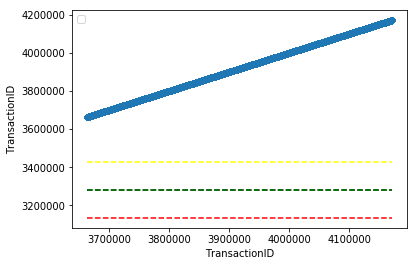

Column Name is TransactionDT:


No handles with labels found to put in legend.


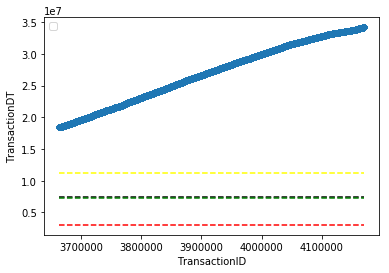

Column Name is TransactionAmt:


No handles with labels found to put in legend.


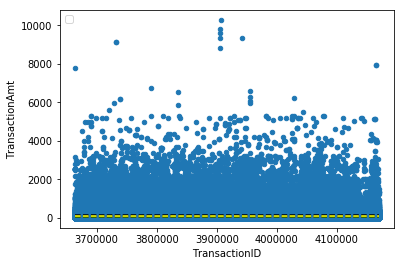

Column Name is ProductCD:
['W' 'C' 'S' 'H' 'R']
[360987, 69266, 11418, 29373, 35647]


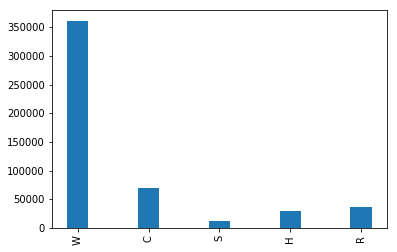

Column Name is card1:


No handles with labels found to put in legend.


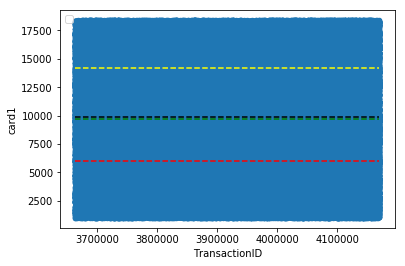

Column Name is card2:


No handles with labels found to put in legend.


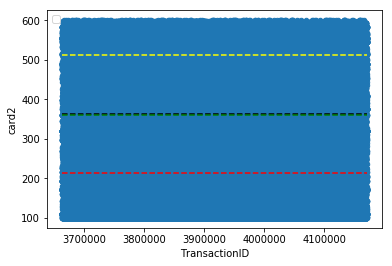

Column Name is card3:


No handles with labels found to put in legend.


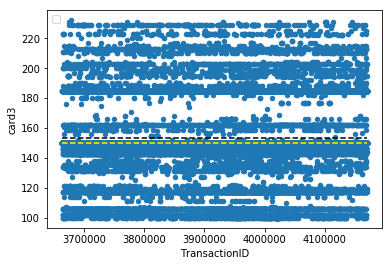

Column Name is card4:
['visa' 'mastercard' 'american express' 'discover']
[334882, 158169, 7681, 2873]


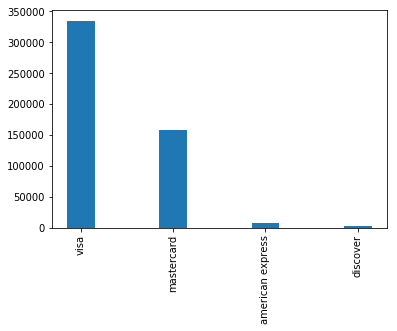

Column Name is card5:


No handles with labels found to put in legend.


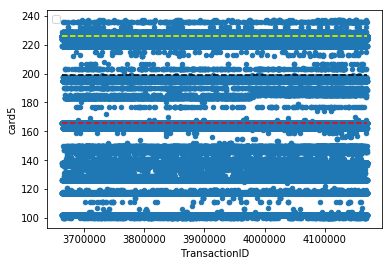

Column Name is card6:
['debit' 'credit' 'charge card']
[385021, 118662, 1]


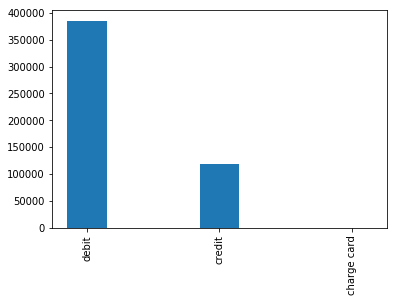

Column Name is addr1:


No handles with labels found to put in legend.


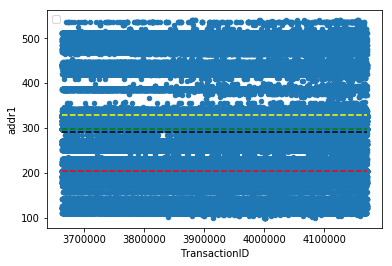

Column Name is addr2:


No handles with labels found to put in legend.


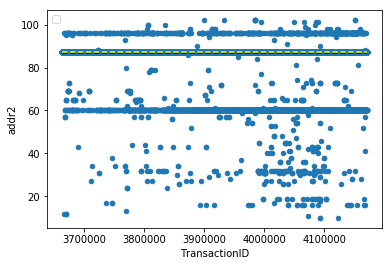

Column Name is P_emaildomain:
['gmail.com' 'aol.com' 'hotmail.com' 'att.net' 'twc.com' 'yahoo.com'
 'verizon.net' 'anonymous.com' 'msn.com' 'q.com' 'outlook.com'
 'icloud.com' 'bellsouth.net' 'sbcglobal.net' 'web.de' 'live.com.mx'
 'ymail.com' 'comcast.net' 'mail.com' 'cox.net' 'me.com' 'aim.com'
 'charter.net' 'rocketmail.com' 'outlook.es' 'centurylink.net' 'live.com'
 'yahoo.de' 'cfl.rr.com' 'mac.com' 'frontier.com' 'netzero.net'
 'frontiernet.net' 'juno.com' 'windstream.net' 'yahoo.fr' 'netzero.com'
 'optonline.net' 'yahoo.co.uk' 'cableone.net' 'roadrunner.com' 'sc.rr.com'
 'earthlink.net' 'gmail' 'hotmail.de' 'yahoo.com.mx' 'suddenlink.net'
 'yahoo.es' 'embarqmail.com' 'hotmail.es' 'ptd.net' 'hotmail.co.uk'
 'protonmail.com' 'live.fr' 'prodigy.net.mx' 'yahoo.co.jp' 'hotmail.fr'
 'gmx.de' 'servicios-ta.com' 'scranton.edu']
[207448, 24048, 40399, 3614, 209, 81850, 2306, 34064, 3388, 173, 4838, 6049, 1528, 2797, 278, 721, 1679, 6586, 597, 1264, 1191, 153, 627, 441, 425, 181, 2679, 63,

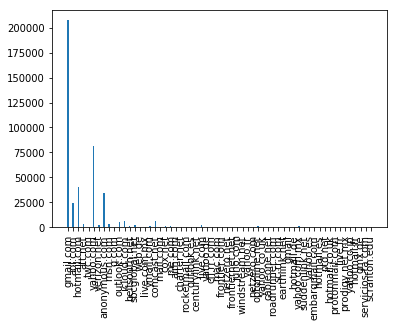

Column Name is C1:


No handles with labels found to put in legend.


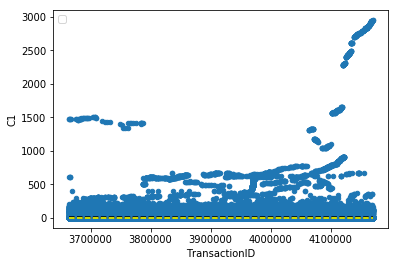

Column Name is C2:


No handles with labels found to put in legend.


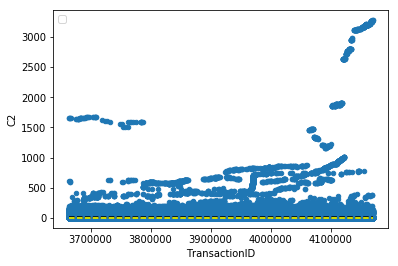

Column Name is C3:


No handles with labels found to put in legend.


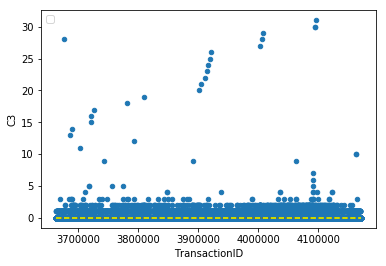

Column Name is C4:


No handles with labels found to put in legend.


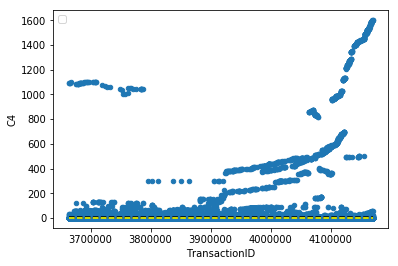

Column Name is C5:


No handles with labels found to put in legend.


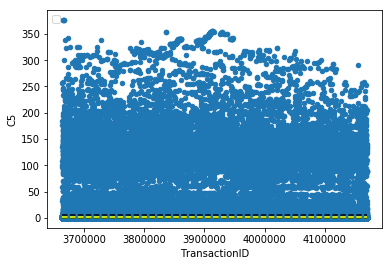

Column Name is C6:


No handles with labels found to put in legend.


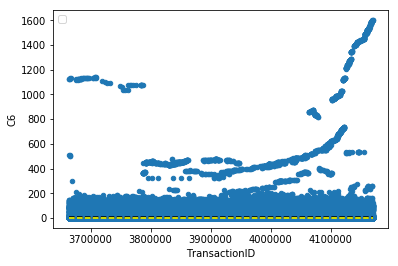

Column Name is C7:


No handles with labels found to put in legend.


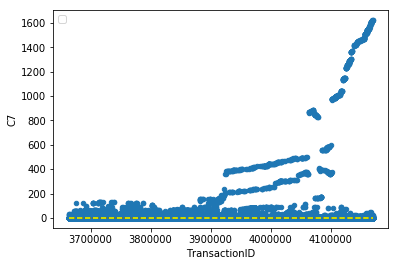

Column Name is C8:


No handles with labels found to put in legend.


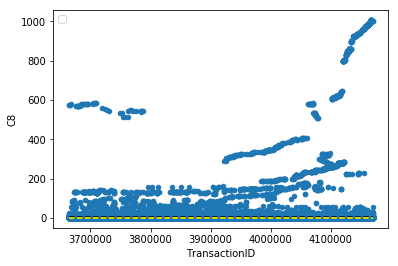

Column Name is C9:


No handles with labels found to put in legend.


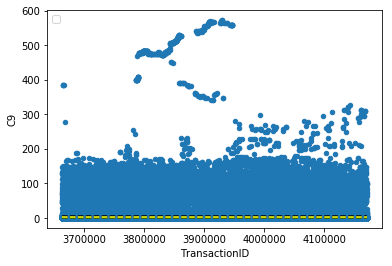

Column Name is C10:


No handles with labels found to put in legend.


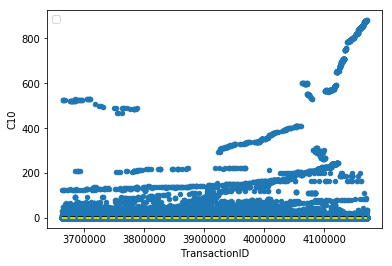

Column Name is C11:


No handles with labels found to put in legend.


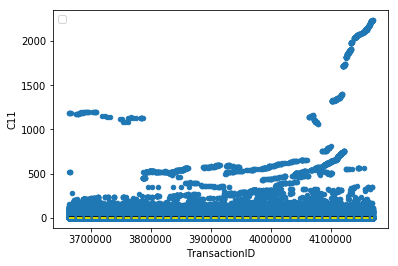

Column Name is C12:


No handles with labels found to put in legend.


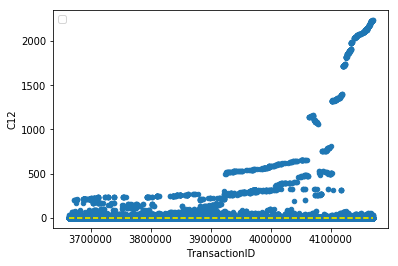

Column Name is C13:


No handles with labels found to put in legend.


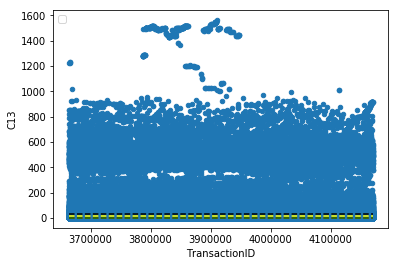

Column Name is C14:


No handles with labels found to put in legend.


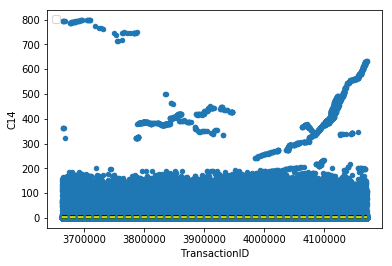

Column Name is D1:


No handles with labels found to put in legend.


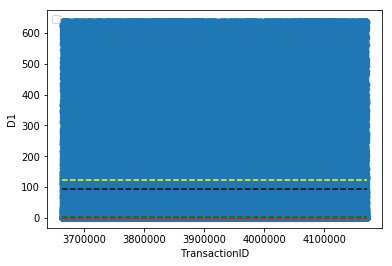

Column Name is D4:


No handles with labels found to put in legend.


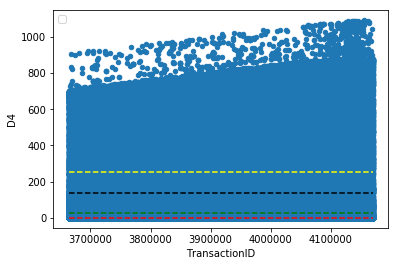

Column Name is D10:


No handles with labels found to put in legend.


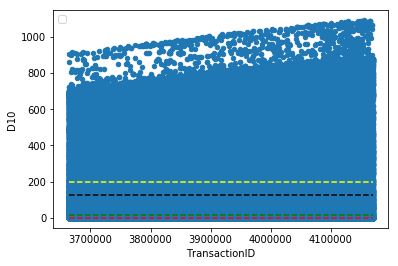

Column Name is D15:


No handles with labels found to put in legend.


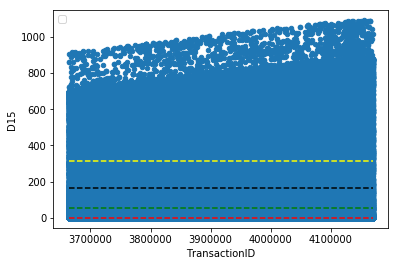

Column Name is M6:
['F' 'T']
[191577, 156175]


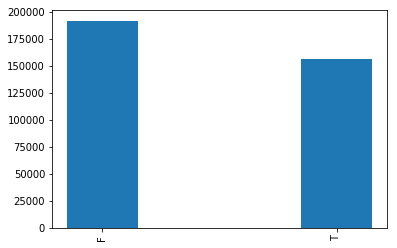

Column Name is V12:


No handles with labels found to put in legend.


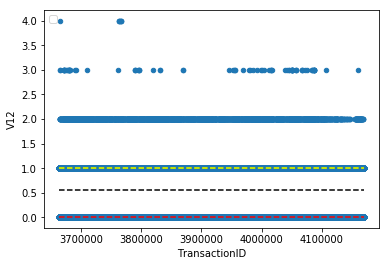

Column Name is V13:


No handles with labels found to put in legend.


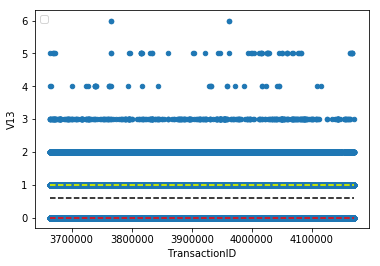

Column Name is V14:


No handles with labels found to put in legend.


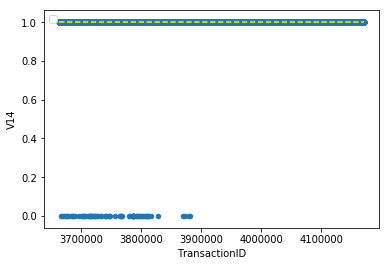

Column Name is V15:


No handles with labels found to put in legend.


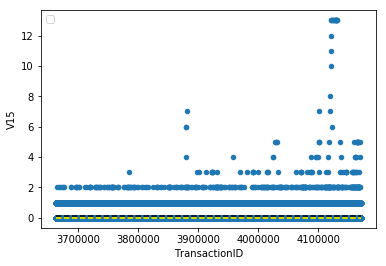

Column Name is V16:


No handles with labels found to put in legend.


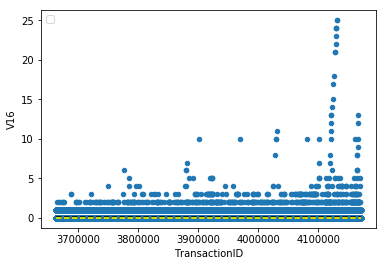

Column Name is V17:


No handles with labels found to put in legend.


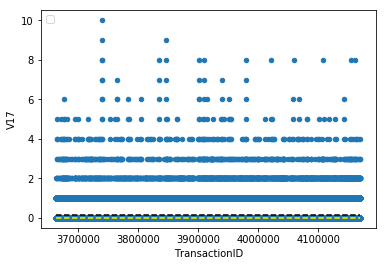

Column Name is V18:


No handles with labels found to put in legend.


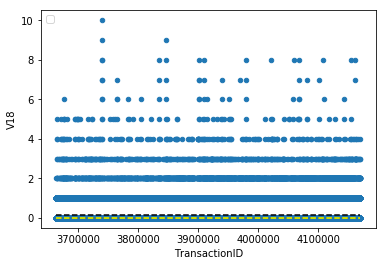

Column Name is V19:


No handles with labels found to put in legend.


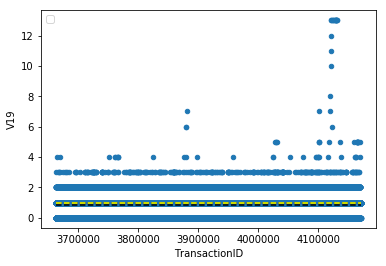

Column Name is V20:


No handles with labels found to put in legend.


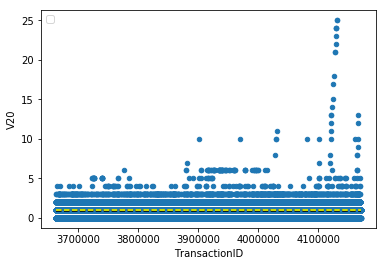

Column Name is V21:


No handles with labels found to put in legend.


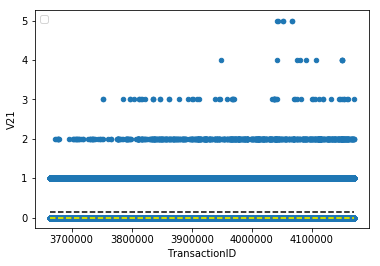

Column Name is V22:


No handles with labels found to put in legend.


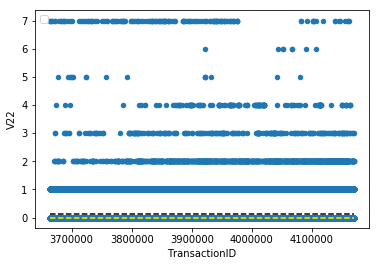

Column Name is V23:


No handles with labels found to put in legend.


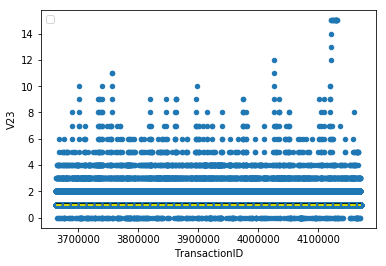

Column Name is V24:


No handles with labels found to put in legend.


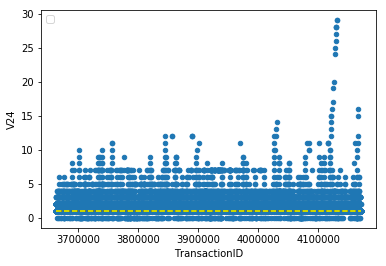

Column Name is V25:


No handles with labels found to put in legend.


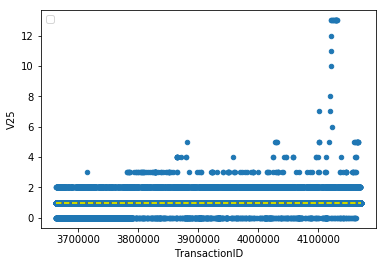

Column Name is V26:


No handles with labels found to put in legend.


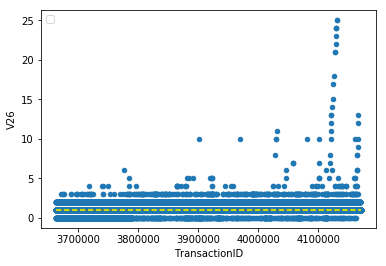

Column Name is V27:


No handles with labels found to put in legend.


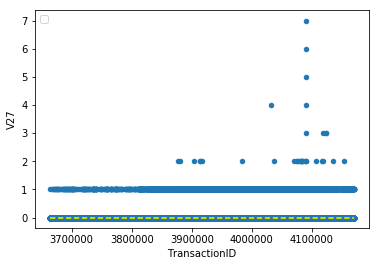

Column Name is V28:


No handles with labels found to put in legend.


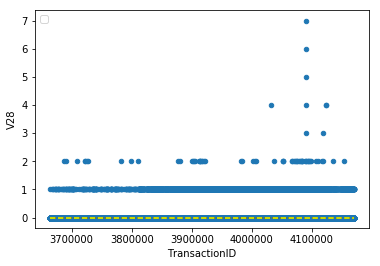

Column Name is V29:


No handles with labels found to put in legend.


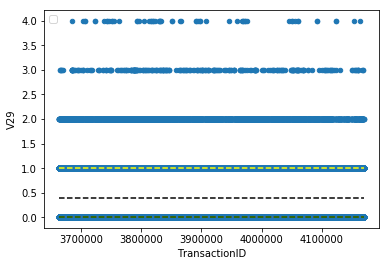

Column Name is V30:


No handles with labels found to put in legend.


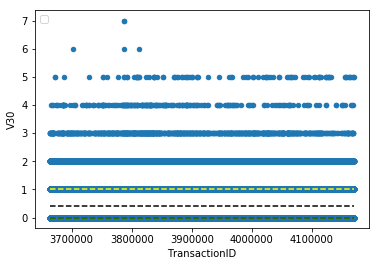

Column Name is V31:


No handles with labels found to put in legend.


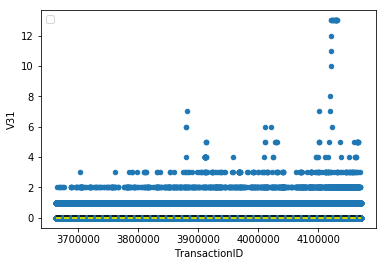

Column Name is V32:


No handles with labels found to put in legend.


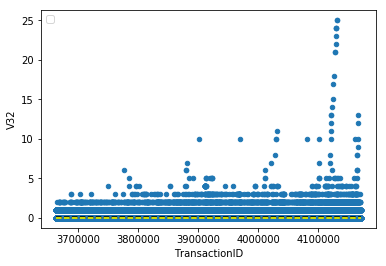

Column Name is V33:


No handles with labels found to put in legend.


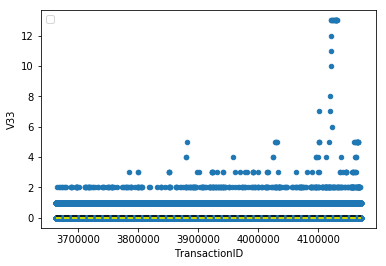

Column Name is V34:


No handles with labels found to put in legend.


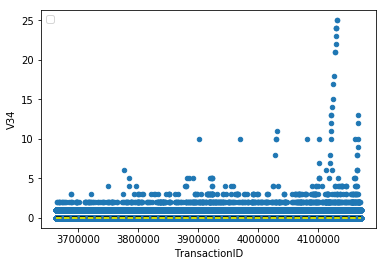

Column Name is V35:


No handles with labels found to put in legend.


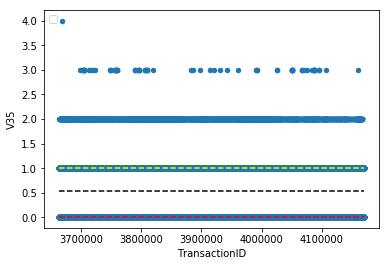

Column Name is V36:


No handles with labels found to put in legend.


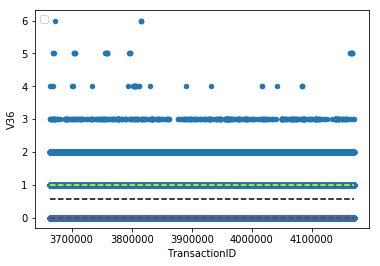

Column Name is V37:


No handles with labels found to put in legend.


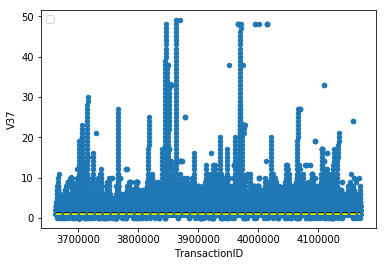

Column Name is V38:


No handles with labels found to put in legend.


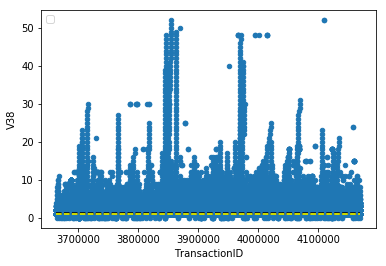

Column Name is V39:


No handles with labels found to put in legend.


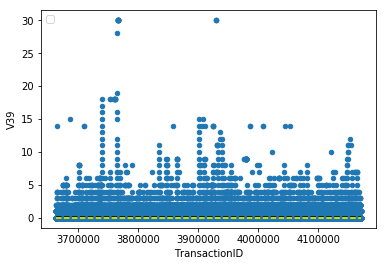

Column Name is V40:


No handles with labels found to put in legend.


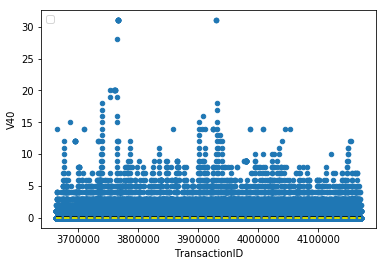

Column Name is V41:


No handles with labels found to put in legend.


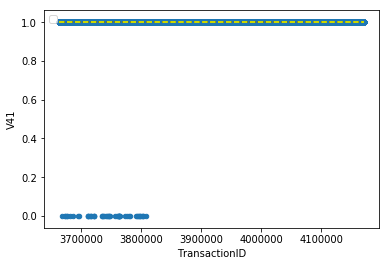

Column Name is V42:


No handles with labels found to put in legend.


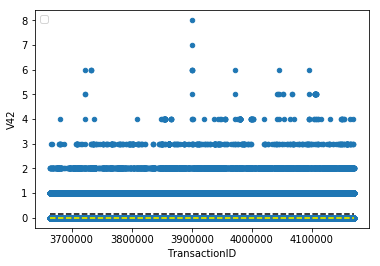

Column Name is V43:


No handles with labels found to put in legend.


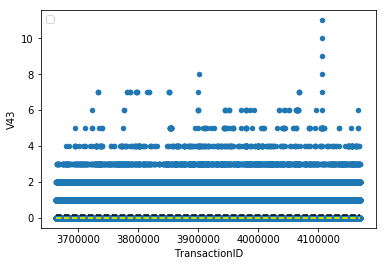

Column Name is V44:


No handles with labels found to put in legend.


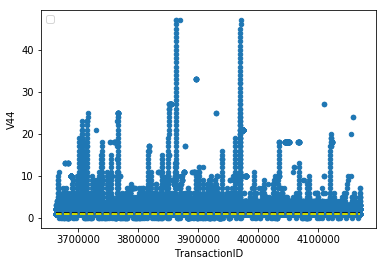

Column Name is V45:


No handles with labels found to put in legend.


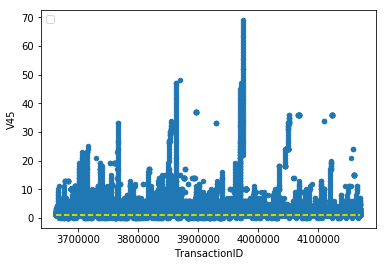

Column Name is V46:


No handles with labels found to put in legend.


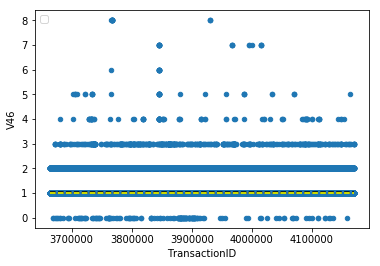

Column Name is V47:


No handles with labels found to put in legend.


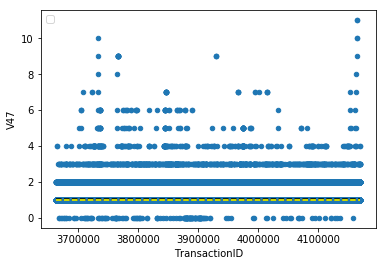

Column Name is V48:


No handles with labels found to put in legend.


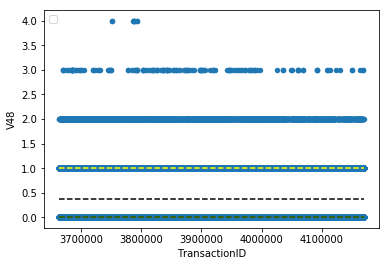

Column Name is V49:


No handles with labels found to put in legend.


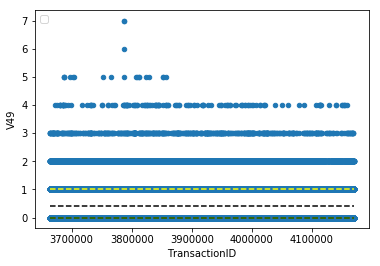

Column Name is V50:


No handles with labels found to put in legend.


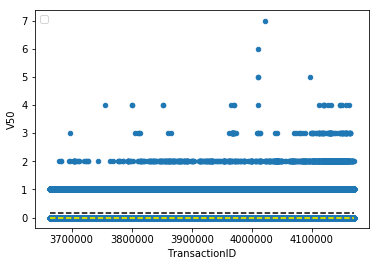

Column Name is V51:


No handles with labels found to put in legend.


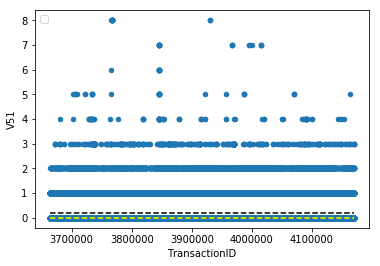

Column Name is V52:


No handles with labels found to put in legend.


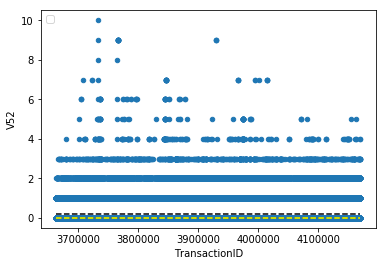

Column Name is V53:


No handles with labels found to put in legend.


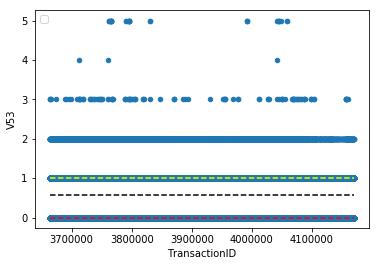

Column Name is V54:


No handles with labels found to put in legend.


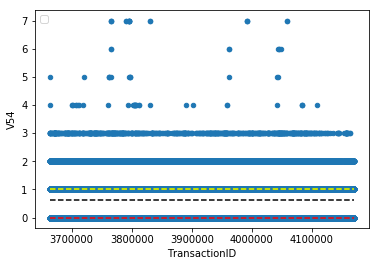

Column Name is V55:


No handles with labels found to put in legend.


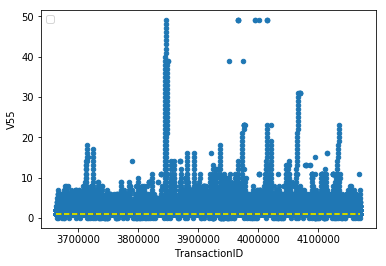

Column Name is V56:


No handles with labels found to put in legend.


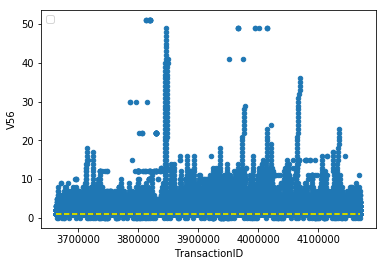

Column Name is V57:


No handles with labels found to put in legend.


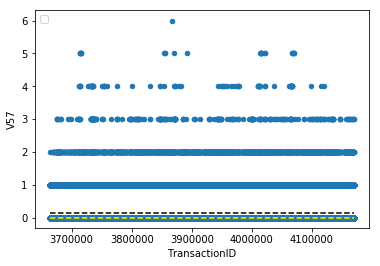

Column Name is V58:


No handles with labels found to put in legend.


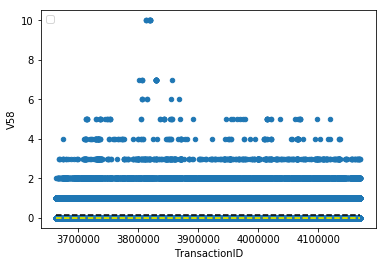

Column Name is V59:


No handles with labels found to put in legend.


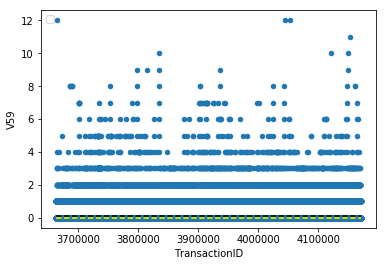

Column Name is V60:


No handles with labels found to put in legend.


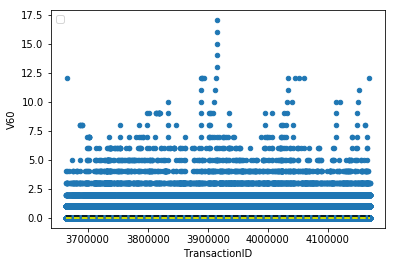

Column Name is V61:


No handles with labels found to put in legend.


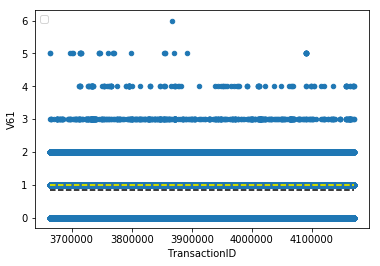

Column Name is V62:


No handles with labels found to put in legend.


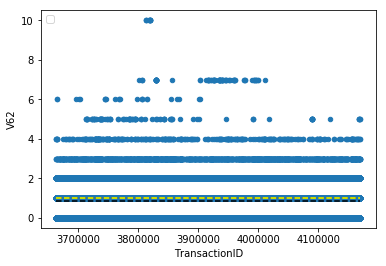

Column Name is V63:


No handles with labels found to put in legend.


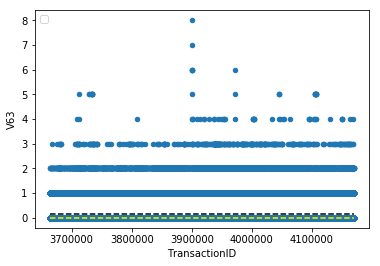

Column Name is V64:


No handles with labels found to put in legend.


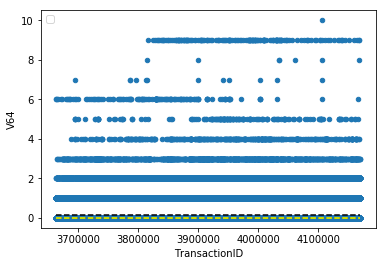

Column Name is V65:


No handles with labels found to put in legend.


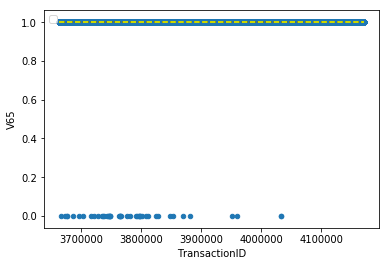

Column Name is V66:


No handles with labels found to put in legend.


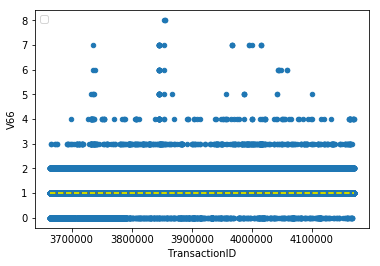

Column Name is V67:


No handles with labels found to put in legend.


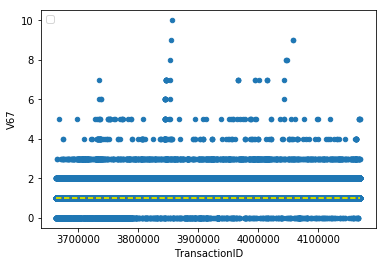

Column Name is V68:


No handles with labels found to put in legend.


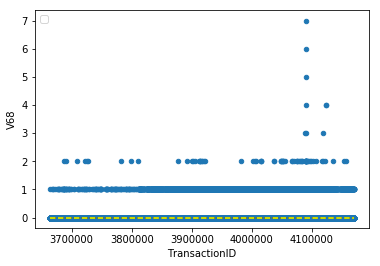

Column Name is V69:


No handles with labels found to put in legend.


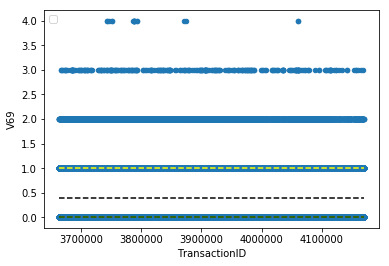

Column Name is V70:


No handles with labels found to put in legend.


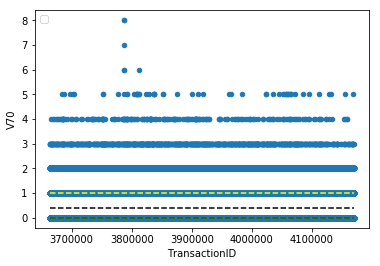

Column Name is V71:


No handles with labels found to put in legend.


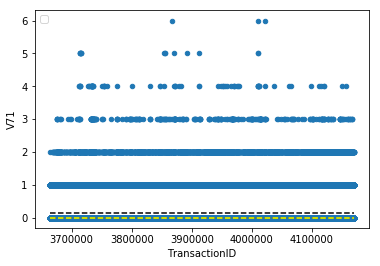

Column Name is V72:


No handles with labels found to put in legend.


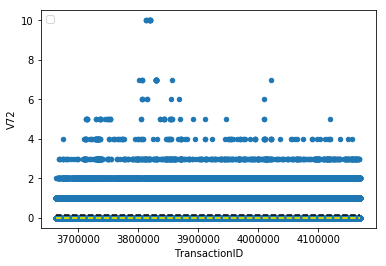

Column Name is V73:


No handles with labels found to put in legend.


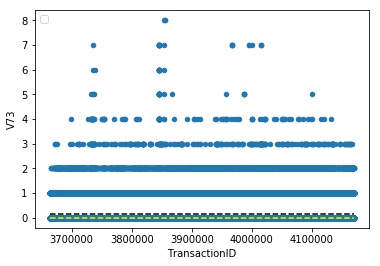

Column Name is V74:


No handles with labels found to put in legend.


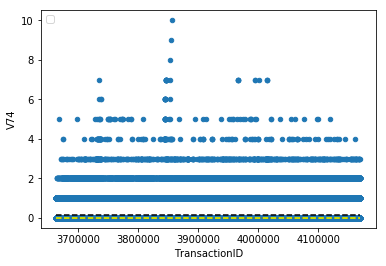

Column Name is V75:


No handles with labels found to put in legend.


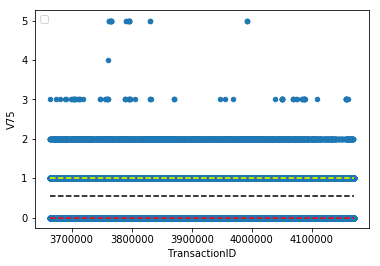

Column Name is V76:


No handles with labels found to put in legend.


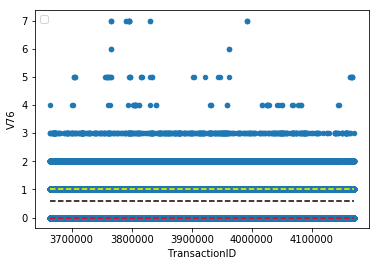

Column Name is V77:


No handles with labels found to put in legend.


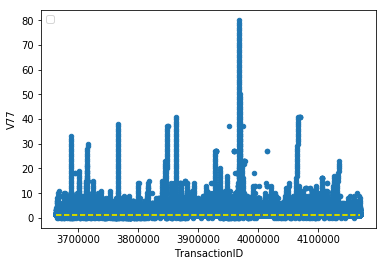

Column Name is V78:


No handles with labels found to put in legend.


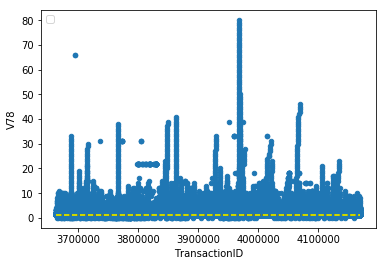

Column Name is V79:


No handles with labels found to put in legend.


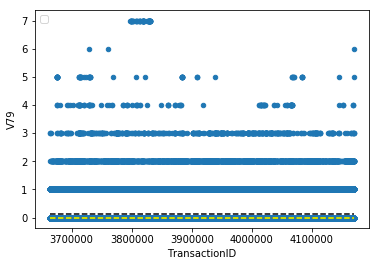

Column Name is V80:


No handles with labels found to put in legend.


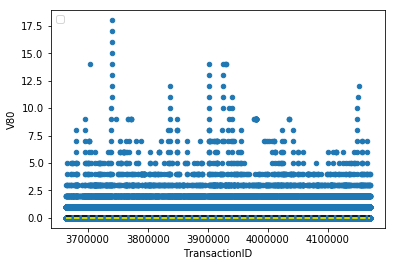

Column Name is V81:


No handles with labels found to put in legend.


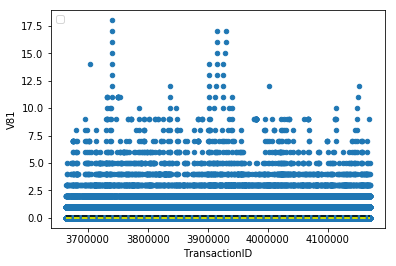

Column Name is V82:


No handles with labels found to put in legend.


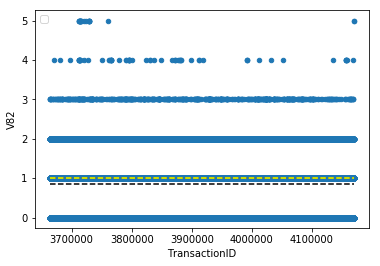

Column Name is V83:


No handles with labels found to put in legend.


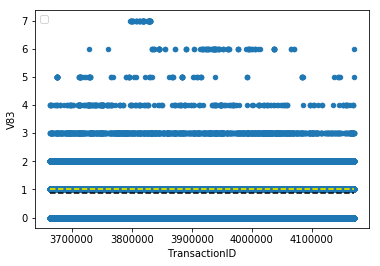

Column Name is V84:


No handles with labels found to put in legend.


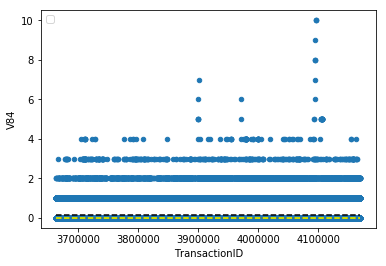

Column Name is V85:


No handles with labels found to put in legend.


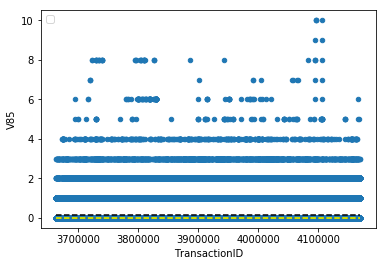

Column Name is V86:


No handles with labels found to put in legend.


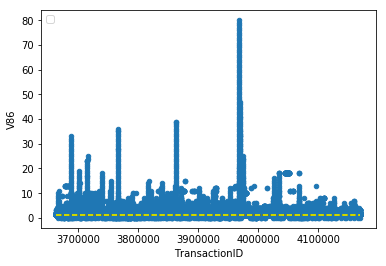

Column Name is V87:


No handles with labels found to put in legend.


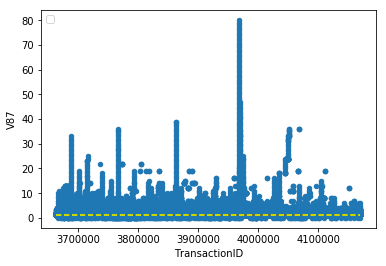

Column Name is V88:


No handles with labels found to put in legend.


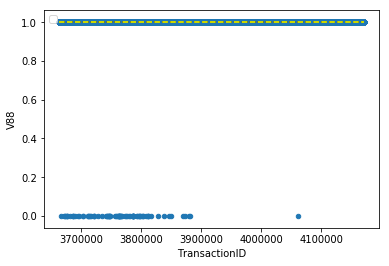

Column Name is V89:


No handles with labels found to put in legend.


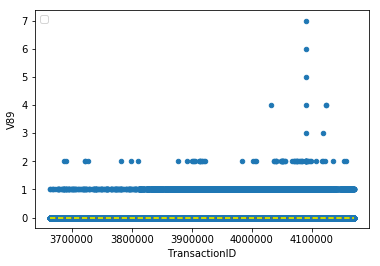

Column Name is V90:


No handles with labels found to put in legend.


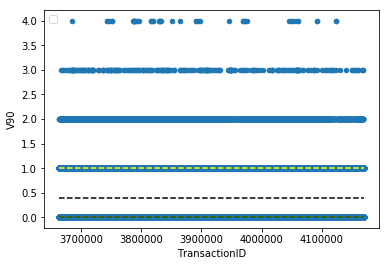

Column Name is V91:


No handles with labels found to put in legend.


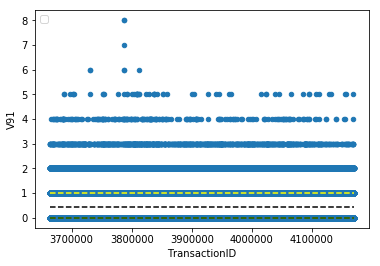

Column Name is V92:


No handles with labels found to put in legend.


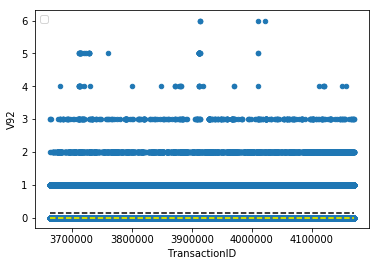

Column Name is V93:


No handles with labels found to put in legend.


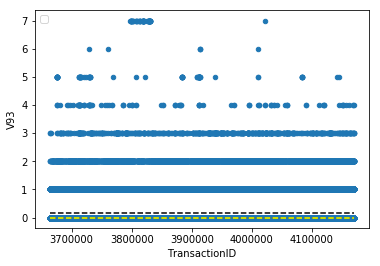

Column Name is V94:


No handles with labels found to put in legend.


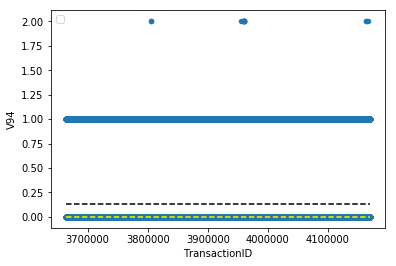

Column Name is V95:


No handles with labels found to put in legend.


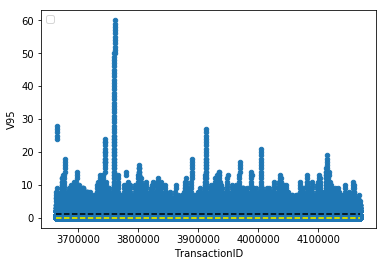

Column Name is V96:


No handles with labels found to put in legend.


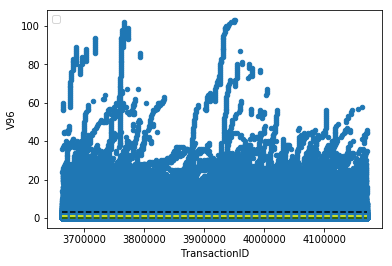

Column Name is V97:


No handles with labels found to put in legend.


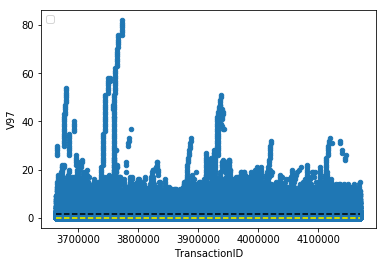

Column Name is V98:


No handles with labels found to put in legend.


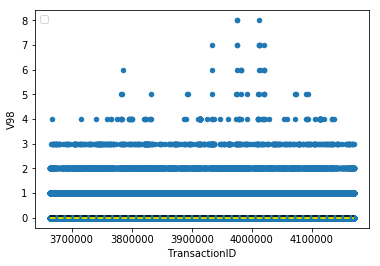

Column Name is V99:


No handles with labels found to put in legend.


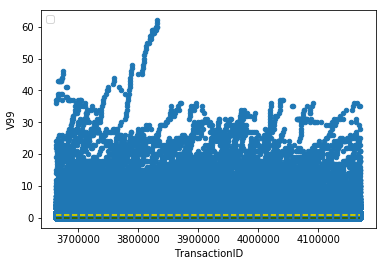

Column Name is V100:


No handles with labels found to put in legend.


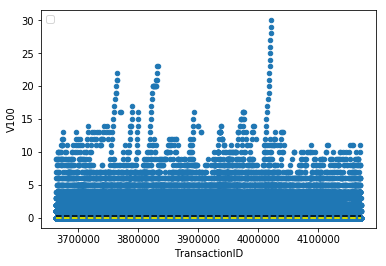

Column Name is V101:


No handles with labels found to put in legend.


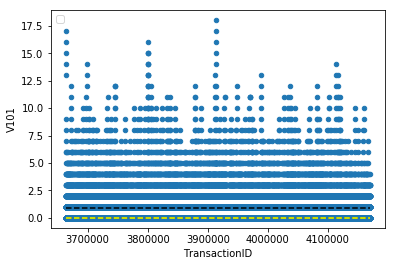

Column Name is V102:


No handles with labels found to put in legend.


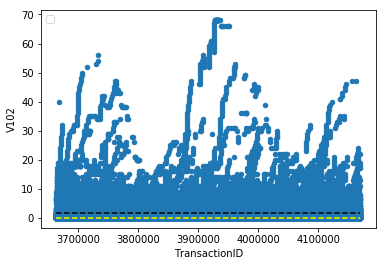

Column Name is V103:


No handles with labels found to put in legend.


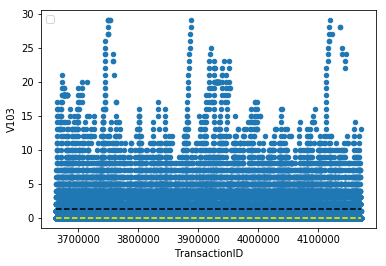

Column Name is V104:


No handles with labels found to put in legend.


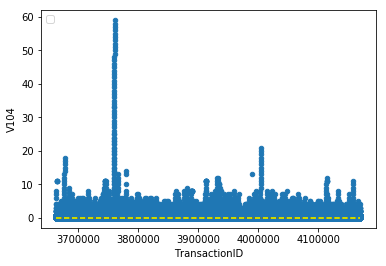

Column Name is V105:


No handles with labels found to put in legend.


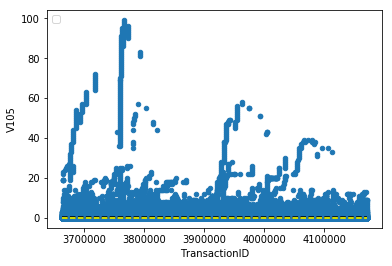

Column Name is V106:


No handles with labels found to put in legend.


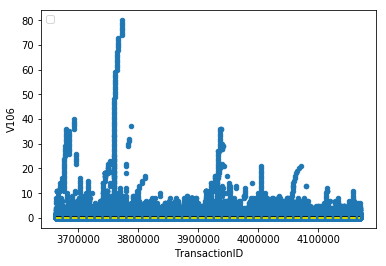

Column Name is V107:


No handles with labels found to put in legend.


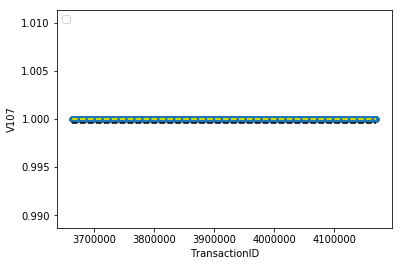

Column Name is V108:


No handles with labels found to put in legend.


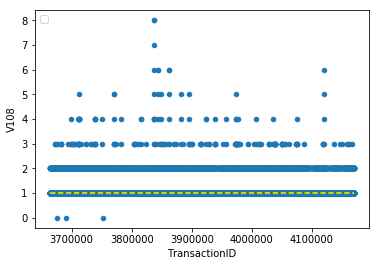

Column Name is V109:


No handles with labels found to put in legend.


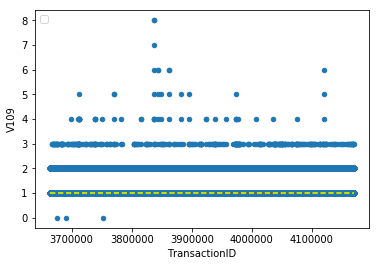

Column Name is V110:


No handles with labels found to put in legend.


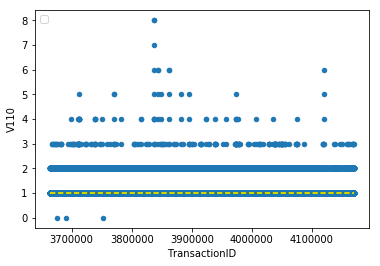

Column Name is V111:


No handles with labels found to put in legend.


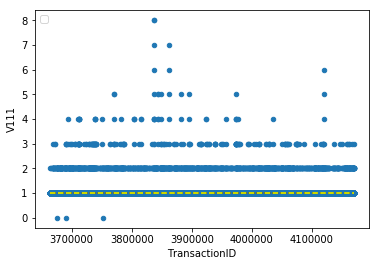

Column Name is V112:


No handles with labels found to put in legend.


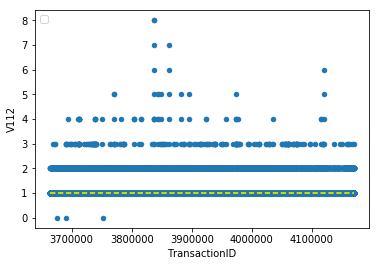

Column Name is V113:


No handles with labels found to put in legend.


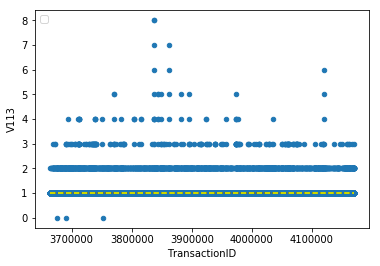

Column Name is V114:


No handles with labels found to put in legend.


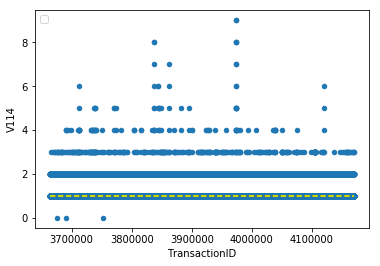

Column Name is V115:


No handles with labels found to put in legend.


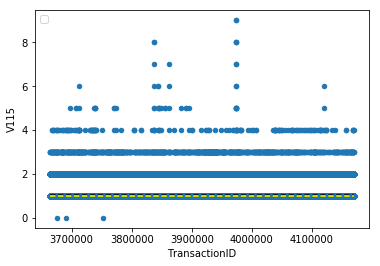

Column Name is V116:


No handles with labels found to put in legend.


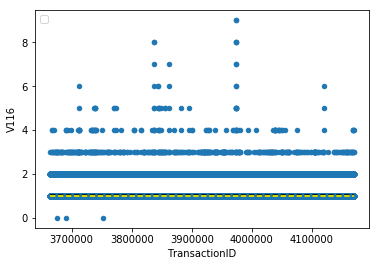

Column Name is V117:


No handles with labels found to put in legend.


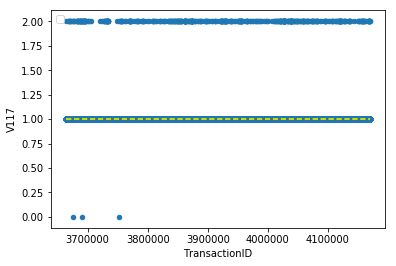

Column Name is V118:


No handles with labels found to put in legend.


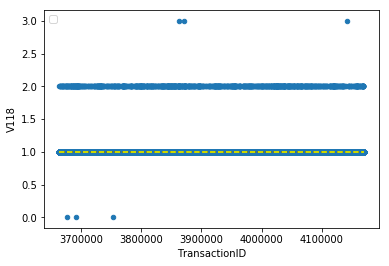

Column Name is V119:


No handles with labels found to put in legend.


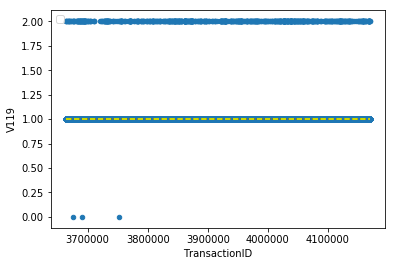

Column Name is V120:


No handles with labels found to put in legend.


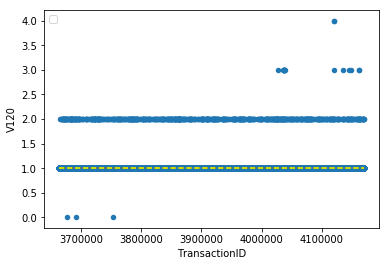

Column Name is V121:


No handles with labels found to put in legend.


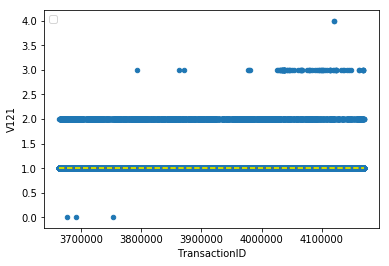

Column Name is V122:


No handles with labels found to put in legend.


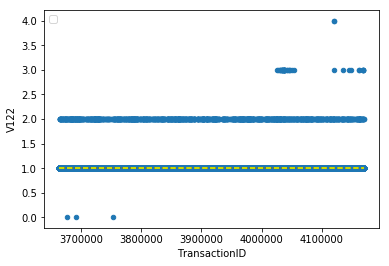

Column Name is V123:


No handles with labels found to put in legend.


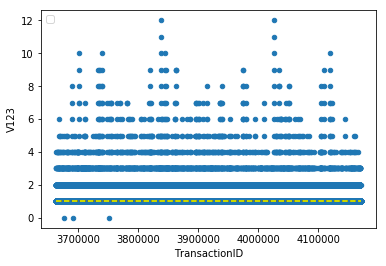

Column Name is V124:


No handles with labels found to put in legend.


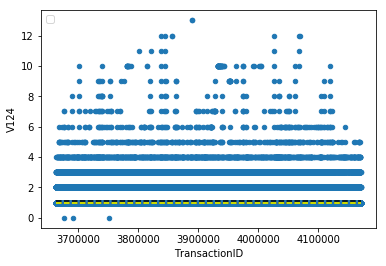

Column Name is V125:


No handles with labels found to put in legend.


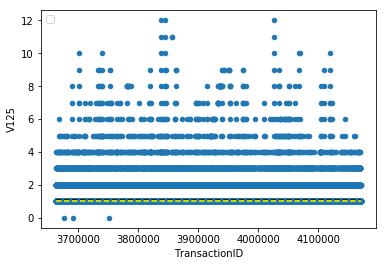

Column Name is V126:


No handles with labels found to put in legend.


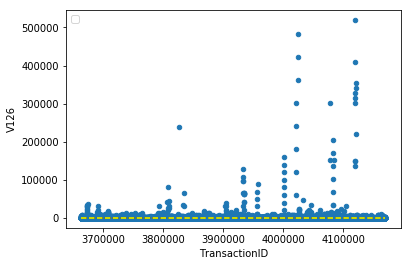

Column Name is V127:


No handles with labels found to put in legend.


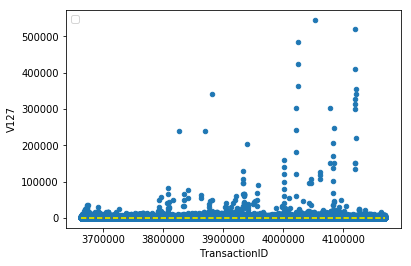

Column Name is V128:


No handles with labels found to put in legend.


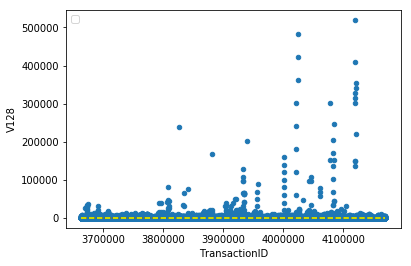

Column Name is V129:


No handles with labels found to put in legend.


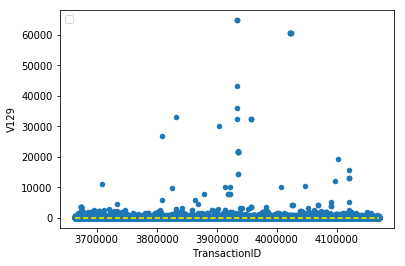

Column Name is V130:


No handles with labels found to put in legend.


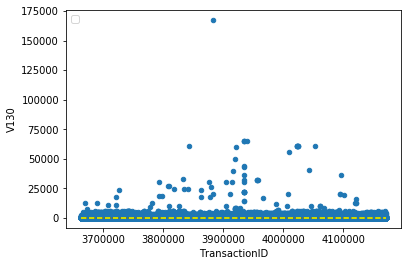

Column Name is V131:


No handles with labels found to put in legend.


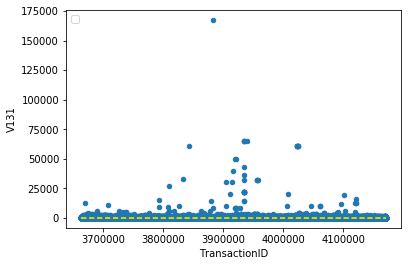

Column Name is V132:


No handles with labels found to put in legend.


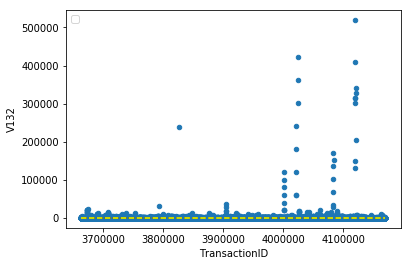

Column Name is V133:


No handles with labels found to put in legend.


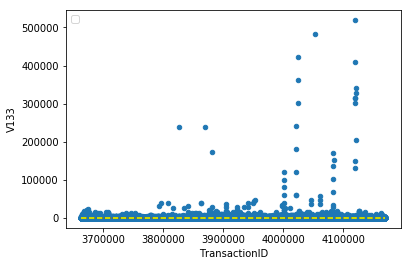

Column Name is V134:


No handles with labels found to put in legend.


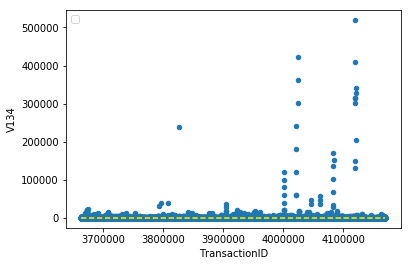

Column Name is V135:


No handles with labels found to put in legend.


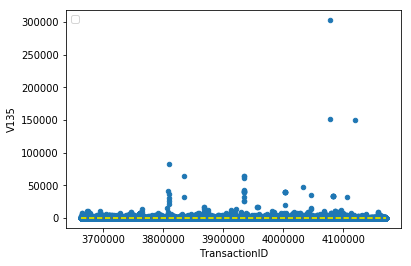

Column Name is V136:


No handles with labels found to put in legend.


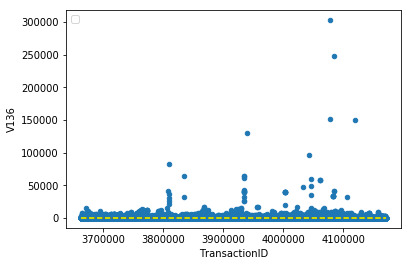

Column Name is V137:


No handles with labels found to put in legend.


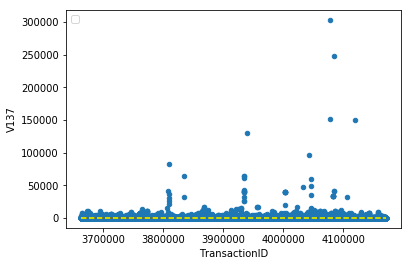

Column Name is V279:


No handles with labels found to put in legend.


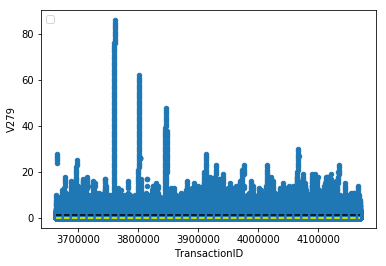

Column Name is V280:


No handles with labels found to put in legend.


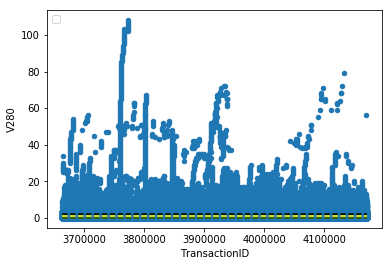

Column Name is V281:


No handles with labels found to put in legend.


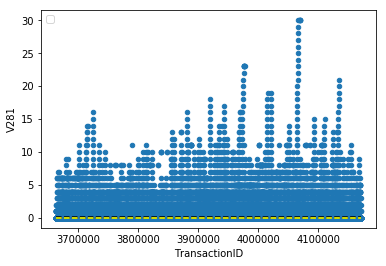

Column Name is V282:


No handles with labels found to put in legend.


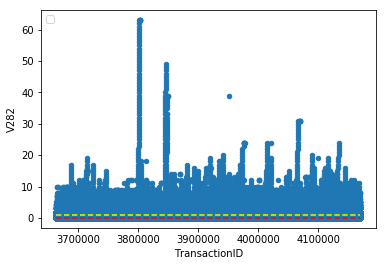

Column Name is V283:


No handles with labels found to put in legend.


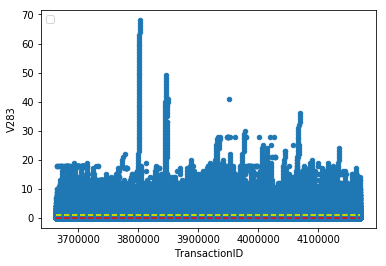

Column Name is V284:


No handles with labels found to put in legend.


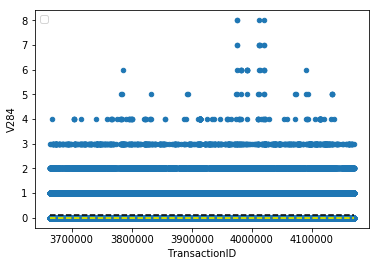

Column Name is V285:


No handles with labels found to put in legend.


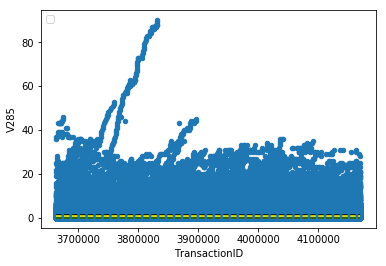

Column Name is V286:


No handles with labels found to put in legend.


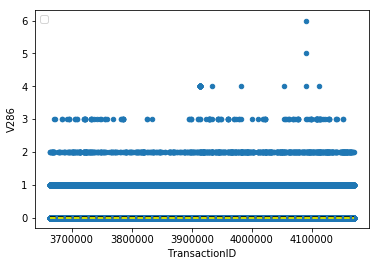

Column Name is V287:


No handles with labels found to put in legend.


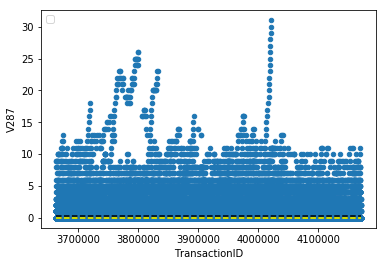

Column Name is V288:


No handles with labels found to put in legend.


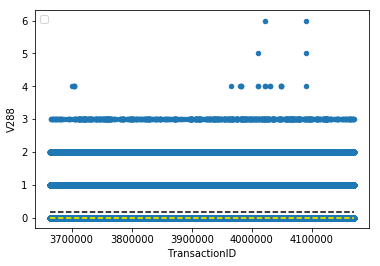

Column Name is V289:


No handles with labels found to put in legend.


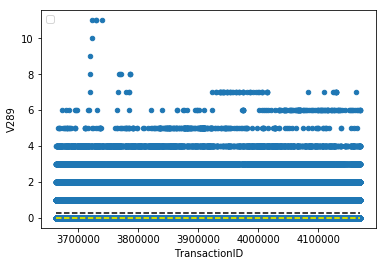

Column Name is V290:


No handles with labels found to put in legend.


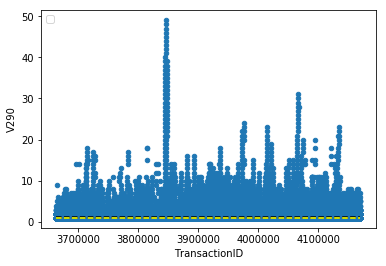

Column Name is V291:


No handles with labels found to put in legend.


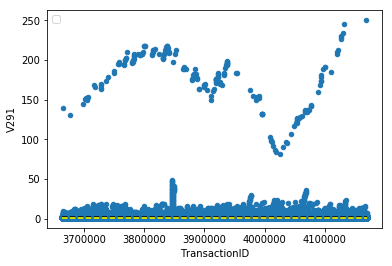

Column Name is V292:


No handles with labels found to put in legend.


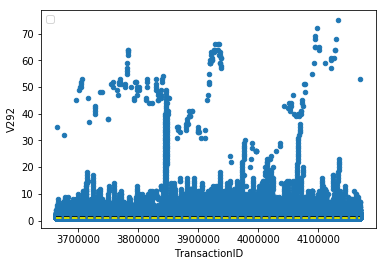

Column Name is V293:


No handles with labels found to put in legend.


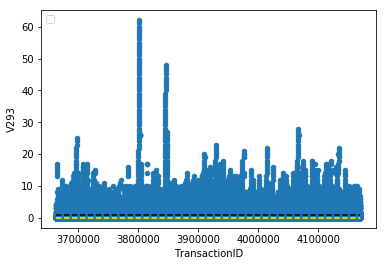

Column Name is V294:


No handles with labels found to put in legend.


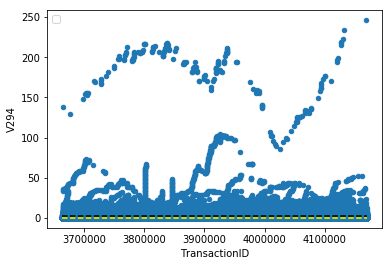

Column Name is V295:


No handles with labels found to put in legend.


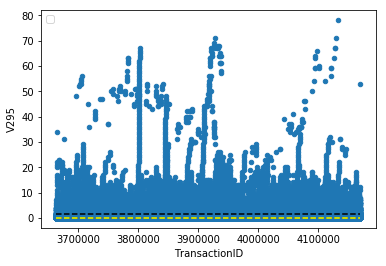

Column Name is V296:


No handles with labels found to put in legend.


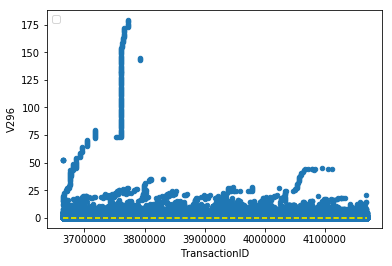

Column Name is V297:


No handles with labels found to put in legend.


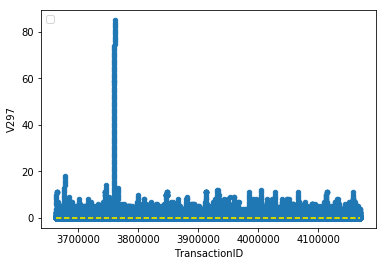

Column Name is V298:


No handles with labels found to put in legend.


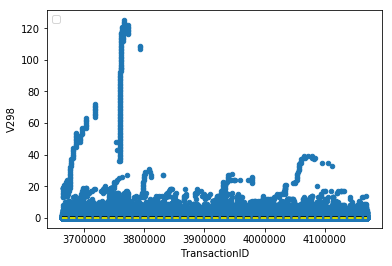

Column Name is V299:


No handles with labels found to put in legend.


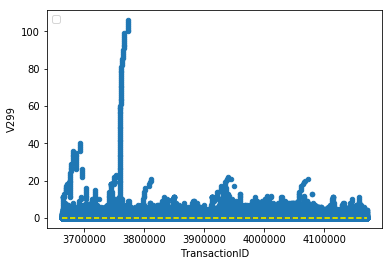

Column Name is V300:


No handles with labels found to put in legend.


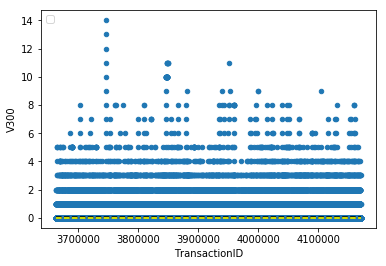

Column Name is V301:


No handles with labels found to put in legend.


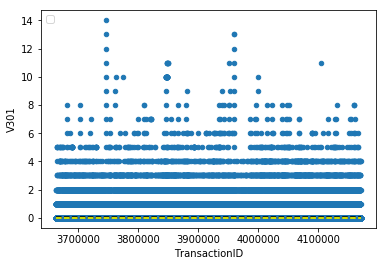

Column Name is V302:


No handles with labels found to put in legend.


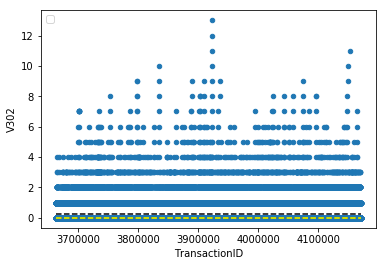

Column Name is V303:


No handles with labels found to put in legend.


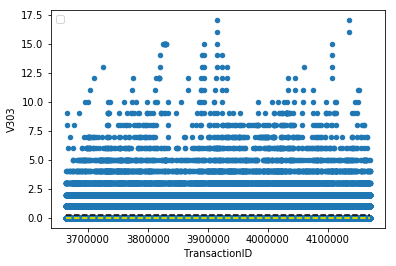

Column Name is V304:


No handles with labels found to put in legend.


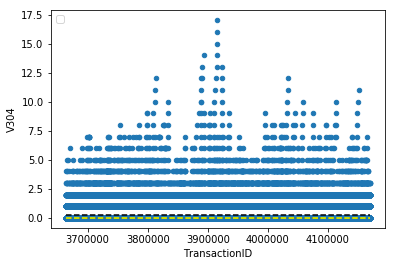

Column Name is V305:


No handles with labels found to put in legend.


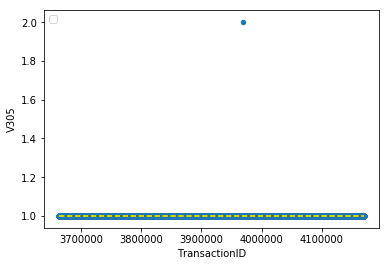

Column Name is V306:


No handles with labels found to put in legend.


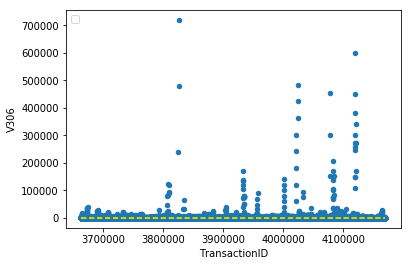

Column Name is V307:


No handles with labels found to put in legend.


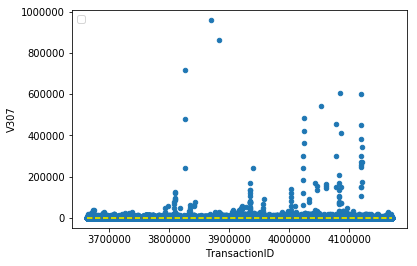

Column Name is V308:


No handles with labels found to put in legend.


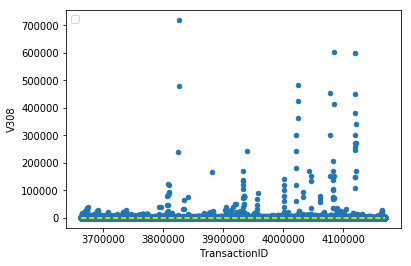

Column Name is V309:


No handles with labels found to put in legend.


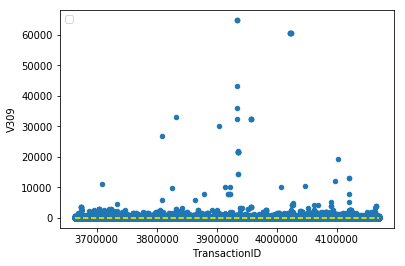

Column Name is V310:


No handles with labels found to put in legend.


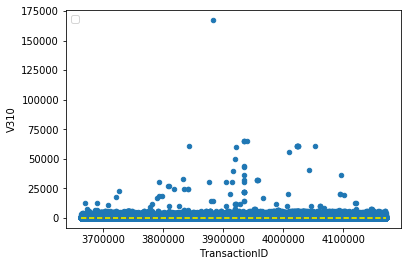

Column Name is V311:


No handles with labels found to put in legend.


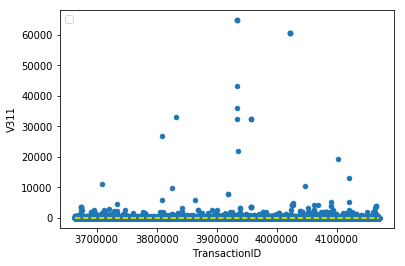

Column Name is V312:


No handles with labels found to put in legend.


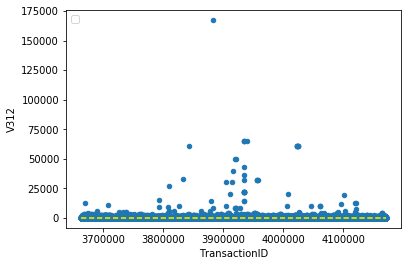

Column Name is V313:


No handles with labels found to put in legend.


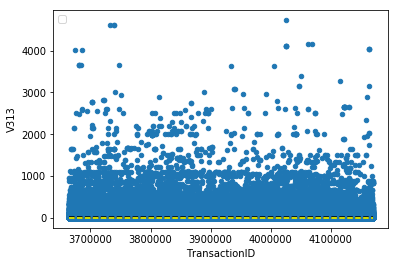

Column Name is V314:


No handles with labels found to put in legend.


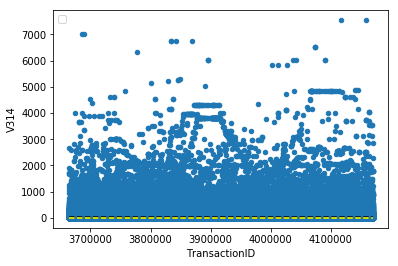

Column Name is V315:


No handles with labels found to put in legend.


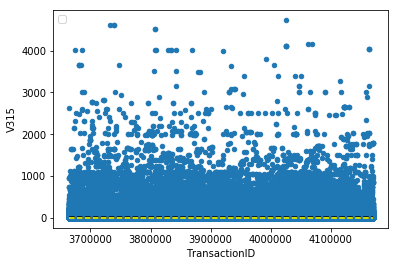

Column Name is V316:


No handles with labels found to put in legend.


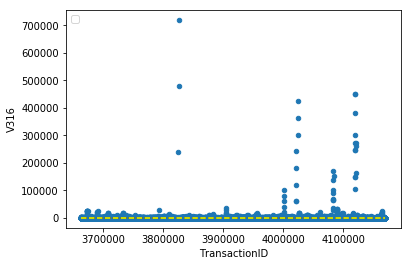

Column Name is V317:


No handles with labels found to put in legend.


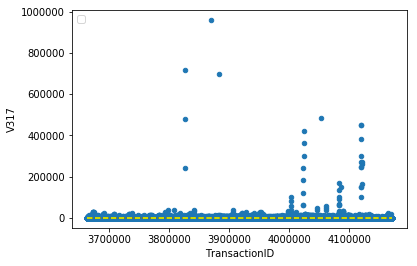

Column Name is V318:


No handles with labels found to put in legend.


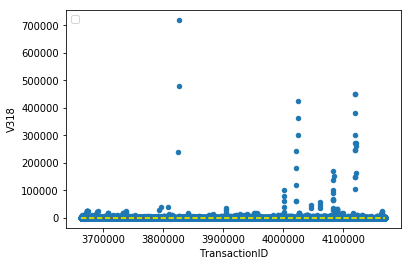

Column Name is V319:


No handles with labels found to put in legend.


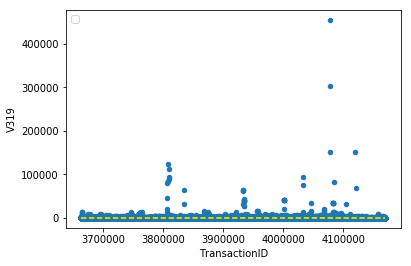

Column Name is V320:


No handles with labels found to put in legend.


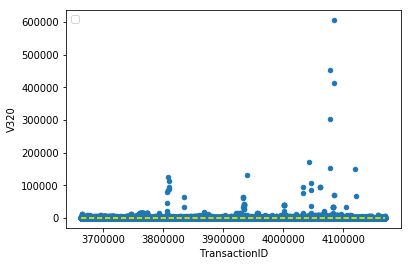

Column Name is V321:


No handles with labels found to put in legend.


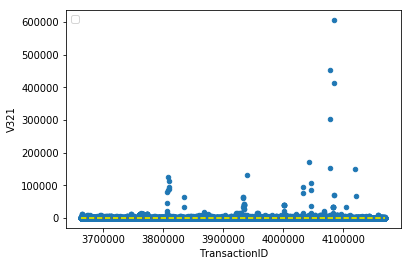

In [88]:
visualization(nan_test, df_test_describe)

In [76]:
for tmp_column in nan_test.columns:
    if nan_test[tmp_column].dtype != np.object:
        nan_test[tmp_column].fillna(value=df_train_describe[tmp_column]["mean"], inplace=True)
    else:
        nan_test[tmp_column].fillna(nan_fill_dict["string"][tmp_column], inplace=True)

In [77]:
outlier(time_of_mean_limitation, nan_test, df_train_describe, nan_fill_dict)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [78]:
encode(nan_test)

ProductCD
card4
card6


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


P_emaildomain
M6


In [79]:
nan_test["P_emaildomain"].loc[nan_test["P_emaildomain"] != 0] = 1

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [80]:
prediction = train_model.predict(nan_test[train_label])

In [81]:
submission = pd.DataFrame({ 'TransactionID': nan_test["TransactionID"],
                            'isFraud': prediction})

In [82]:
submission.to_csv("submission.csv", index=False)

In [83]:
submission.shape

(506691, 2)